In [1]:
import pandas as pd
import numpy as np

from utils.feature_engineering import *

from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier # Or other model that handles NaNs
from sklearn.metrics import accuracy_score, classification_report, f1_score


from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
import time # To handle geocoding rate limits
import warnings # To manage potential warnings

# Ignore warnings for cleaner output, but be cautious in real applications
warnings.filterwarnings('ignore')

2025-05-04 19:45:17.349996: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-04 19:45:17.578602: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load the data

In [2]:
import pandas as pd 
pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.width', None)         # Don't wrap lines
# pd.set_option('display.max_colwidth', None)  # Don't truncate column contents
df = pd.read_excel('Dataset_2.0_Akkodis.xlsx')

df

,ID,Candidate State,Age Range,Residence,Sex,Protected category,TAG,Study area,Study Title,Years Experience,Sector,Last Role,Year of insertion,Year of Recruitment,Recruitment Request,Assumption Headquarters,Job Family Hiring,Job Title Hiring,event_type__val,event_feedback,linked_search__key,Overall,Job Description,Candidate Profile,Years Experience.1,Minimum Ral,Ral Maximum,Study Level,Study Area.1,Akkodis headquarters,Current Ral,Expected Ral,Technical Skills,Standing/Position,Comunication,Maturity,Dynamism,Mobility,English
0,71470,Hired,31 - 35 years,TURIN » Turin ~ Piedmont,Male,NaN,"AUTOSAR, CAN, C, C++, MATLAB/SIMULINK, VECTOR/...",Automation/Mechatronics Engineering,Five-year degree,[1-3],Automotive,Diagnostic/Test engineer,[2018],[2021],E/E Diagnostic Integration Engineer - Automotive,Milan,Engineering,Consultant,Candidate notification,NaN,NaN,NaN,"The candidate, inserted within a multidiscipli...",The ideal candidate has a degree in Electronic...,[1-3],26-28K,30-32K,Five-year degree,electronic Engineering,Modena,22-24 K,24-26 K,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,71470,Hired,31 - 35 years,TURIN » Turin ~ Piedmont,Male,NaN,"AUTOSAR, CAN, C, C++, MATLAB/SIMULINK, VECTOR/...",Automation/Mechatronics Engineering,Five-year degree,[1-3],Automotive,Diagnostic/Test engineer,[2018],[2021],E/E Diagnostic Integration Engineer - Automotive,Milan,Engineering,Consultant,BM interview,NaN,RS18.0145,NaN,"The candidate, inserted within a multidiscipli...",The ideal candidate has a degree in Electronic...,[1-3],26-28K,30-32K,Five-year degree,electronic Engineering,Modena,22-24 K,24-26 K,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,71470,Hired,31 - 35 years,TURIN » Turin ~ Piedmont,Male,NaN,"AUTOSAR, CAN, C, C++, MATLAB/SIMULINK, VECTOR/...",Automation/Mechatronics Engineering,Five-year degree,[1-3],Automotive,Diagnostic/Test engineer,[2018],[2021],E/E Diagnostic Integration Engineer - Automotive,Milan,Engineering,Consultant,Contact note,NaN,NaN,NaN,"The candidate, inserted within a multidiscipli...",The ideal candidate has a degree in Electronic...,[1-3],26-28K,30-32K,Five-year degree,electronic Engineering,Modena,22-24 K,24-26 K,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,71470,Hired,31 - 35 years,TURIN » Turin ~ Piedmont,Male,NaN,"AUTOSAR, CAN, C, C++, MATLAB/SIMULINK, VECTOR/...",Automation/Mechatronics Engineering,Five-year degree,[1-3],Automotive,Diagnostic/Test engineer,[2018],[2021],E/E Diagnostic Integration Engineer - Automotive,Milan,Engineering,Consultant,BM interview,OK,RS18.0114,~ 2 - Medium,"The candidate, inserted within a multidiscipli...",The ideal candidate has a degree in Electronic...,[1-3],26-28K,30-32K,Five-year degree,electronic Engineering,Modena,22-24 K,24-26 K,2.0,2.0,1.0,2.0,2.0,3.0,3.0
4,71470,Hired,31 - 35 years,TURIN » Turin ~ Piedmont,Male,NaN,"AUTOSAR, CAN, C, C++, MATLAB/SIMULINK, VECTOR/...",Automation/Mechatronics Engineering,Five-year degree,[1-3],Automotive,Diagnostic/Test engineer,[2018],[2021],E/E Diagnostic Integration Engineer - Automotive,Milan,Engineering,Consultant,Commercial note,NaN,NaN,NaN,"The candidate, inserted within a multidiscipli...",The ideal candidate has a degree in Electronic...,[1-3],26-28K,30-32K,Five-year degree,electronic Engineering,Modena,22-24 K,24-26 K,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21372,79993,Hired,26 - 30 years,TORRE ANNUNZIATA » Naples ~ Campania,Male,NaN,X,chemical engineering,Five-year degree,[0],Others,Graduating student,[2023],[2023],Junior Project Engineer (C&Q),Pomezia,Tech Consulting & Solutions,Consultant,HR interview,OK,RS23.0793,~ 3 - High,"The resource, included in a team dedicated to ...",The ideal candidate has a Master's Degree in C...,[0],- 20K,- 20K,Five-year degree,chemical engineering,Pomezia,Not available,Not available,2.0,2.0,3.0,3.0,3.0,3.0,3.0
21373,79993,Hired,26 - 30 years,TORRE ANNUNZIATA » Naples ~ Campania,Male,NaN,X,chemic

## Remove rows

### Drop duplicates

In [3]:
df = df.drop_duplicates().reset_index(drop=True)

### Clean the columns' names

In [4]:
df.columns = [c.strip() for c in df.columns]
df.columns = [c.encode('ascii', 'ignore').decode().strip() for c in df.columns]
df.columns

Index(['ID', 'Candidate State', 'Age Range', 'Residence', 'Sex',
       'Protected category', 'TAG', 'Study area', 'Study Title',
       'Years Experience', 'Sector', 'Last Role', 'Year of insertion',
       'Year of Recruitment', 'Recruitment Request', 'Assumption Headquarters',
       'Job Family Hiring', 'Job Title Hiring', 'event_type__val',
       'event_feedback', 'linked_search__key', 'Overall', 'Job Description',
       'Candidate Profile', 'Years Experience.1', 'Minimum Ral', 'Ral Maximum',
       'Study Level', 'Study Area.1', 'Akkodis headquarters', 'Current Ral',
       'Expected Ral', 'Technical Skills', 'Standing/Position', 'Comunication',
       'Maturity', 'Dynamism', 'Mobility', 'English'],
      dtype='object')

In [5]:
set(df['Candidate State'])

{'Economic proposal',
 'First contact',
 'Hired',
 'Imported',
 'In selection',
 'QM',
 'Vivier'}

In [6]:
for c in list(set(df['Candidate State'])):
    print(c,len(df[df['Candidate State']==c]))

First contact 3858
Hired 2143
In selection 5508
QM 832
Imported 7514
Economic proposal 403
Vivier 108


In [7]:
df[df['Candidate State']!='Hired'][[
        'Recruitment Request', 'Job Family Hiring', 'Job Title Hiring',
        'Job Description', 'Candidate Profile',
        'Years Experience.1', 'Minimum Ral', 'Ral Maximum',
        'Study Level', 'Study Area.1'
    ]].isna().sum(), len(df[df['Candidate State']!='Hired'])

(Recruitment Request    18223
 Job Family Hiring      18223
 Job Title Hiring       18223
 Job Description        18223
 Candidate Profile      18223
 Years Experience.1     18223
 Minimum Ral            18223
 Ral Maximum            18223
 Study Level            18223
 Study Area.1           18223
 dtype: int64,
 18223)

### Create new IDs and separate different people with duplicating IDs

In [8]:
import pandas as pd

unique_ids_before = df['ID'].nunique()

invariant_columns = [
    'ID', 'Sex',
      'Job Title Hiring', 'Study Area.1', 'Assumption Headquarters',
      'Year of insertion', 'Age Range',
    'Study area', 'Study Title', 'Years Experience', 'Residence'
]

# Create a backup of original IDs to avoid unintentional merging
df['Original_ID'] = df['ID']

def split_id(group):
    # Use `drop_duplicates` to check for uniqueness in invariant_columns
    unique_combinations = group[invariant_columns].drop_duplicates()
    
    if len(unique_combinations) == 1:
        # All rows have the same invariant values; no split needed
        group['New_ID'] = group['Original_ID'].iloc[0]
    else:
        # Split into subgroups based on unique combinations of invariant_columns
        for idx, (_, subgroup) in enumerate(group.groupby(invariant_columns, dropna=False)):
            group.loc[subgroup.index, 'New_ID'] = f"{group['Original_ID'].iloc[0]}_{idx + 1}"
    
    return group

# Apply splitting logic
df = df.groupby('Original_ID', group_keys=False).apply(split_id)

# Update ID with New_ID where applicable
df['ID'] = df['New_ID'].fillna(df['Original_ID'])

# Cleanup temporary columns
df = df.drop(columns=['New_ID', 'Original_ID']).reset_index(drop=True)

# Final check
unique_ids_after = df['ID'].nunique()

print(f"🔵 Unique IDs before cleaning: {unique_ids_before}")
print(f"🟢 Unique IDs after cleaning: {unique_ids_after}")
print(f"🧮 Difference: {unique_ids_after - unique_ids_before} new IDs created")


🔵 Unique IDs before cleaning: 12263
🟢 Unique IDs after cleaning: 13372
🧮 Difference: 1109 new IDs created


### Drop redundant columns

In [9]:
df = df.drop(columns=['linked_search__key', 'Year of Recruitment'])


### Remove candidates in first stages

In [10]:
# Normalize columns
df['Candidate State'] = df['Candidate State'].str.strip().str.lower()

# Create a mask for IDs to drop
ids_to_drop = []

grouped = df.groupby('ID')

for id_value, group in grouped:
    is_single_row_group = len(group) == 1
    is_single_row_group=True
    has_imported_or_first_contact = (group['Candidate State'].isin(['imported', 'first contact', 'in selection'])).all()
    
    # Check if all 'Sector' values are NaN
    sector_all_nan = group['Sector'].isna().all()
    
    if has_imported_or_first_contact and sector_all_nan and is_single_row_group:
        ids_to_drop.append(id_value)

# Now filter out the rows with these IDs
df = df[~df['ID'].isin(ids_to_drop)]

# Reset index
df = df.reset_index(drop=True)

print(f"Dropped {len(ids_to_drop)} IDs.")


Dropped 7963 IDs.


### Removal of Candidates with Inconsistent Final Outcomes

In [11]:
state_order = ['imported', 'first contact', 'in selection', 'qm', 'economic proposal', 'vivier', 'hired']
event_order = ['cv request', 'contact note', 'hr interview', 'bm interview', 'technical interview', 
               'qualification meeting', 'economic proposal', 'candidate notification']

# Define a function to sort each group
def sort_group(group):
    # Sort the group by Candidate State and Event_Type__Val based on the specified order
    sorted_group = group.sort_values(by=['Candidate State', 'event_type__val'], 
                                     key=lambda col: col.map(lambda x: (state_order.index(x) if x in state_order else -1, 
                                                                        event_order.index(x) if x in event_order else -1)))
    return sorted_group

# Apply sorting function to each group and update the DataFrame (ordered version)
grouped = df.groupby('ID', group_keys=False).apply(sort_group)

# Reset the index after sorting
df = grouped.reset_index(drop=True)
df

,ID,Candidate State,Age Range,Residence,Sex,Protected category,TAG,Study area,Study Title,Years Experience,Sector,Last Role,Year of insertion,Recruitment Request,Assumption Headquarters,Job Family Hiring,Job Title Hiring,event_type__val,event_feedback,Overall,Job Description,Candidate Profile,Years Experience.1,Minimum Ral,Ral Maximum,Study Level,Study Area.1,Akkodis headquarters,Current Ral,Expected Ral,Technical Skills,Standing/Position,Comunication,Maturity,Dynamism,Mobility,English
0,71470,hired,31 - 35 years,TURIN » Turin ~ Piedmont,Male,NaN,"AUTOSAR, CAN, C, C++, MATLAB/SIMULINK, VECTOR/...",Automation/Mechatronics Engineering,Five-year degree,[1-3],Automotive,Diagnostic/Test engineer,[2018],E/E Diagnostic Integration Engineer - Automotive,Milan,Engineering,Consultant,Candidate notification,NaN,NaN,"The candidate, inserted within a multidiscipli...",The ideal candidate has a degree in Electronic...,[1-3],26-28K,30-32K,Five-year degree,electronic Engineering,Modena,22-24 K,24-26 K,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,71470,hired,31 - 35 years,TURIN » Turin ~ Piedmont,Male,NaN,"AUTOSAR, CAN, C, C++, MATLAB/SIMULINK, VECTOR/...",Automation/Mechatronics Engineering,Five-year degree,[1-3],Automotive,Diagnostic/Test engineer,[2018],E/E Diagnostic Integration Engineer - Automotive,Milan,Engineering,Consultant,BM interview,NaN,NaN,"The candidate, inserted within a multidiscipli...",The ideal candidate has a degree in Electronic...,[1-3],26-28K,30-32K,Five-year degree,electronic Engineering,Modena,22-24 K,24-26 K,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,71470,hired,31 - 35 years,TURIN » Turin ~ Piedmont,Male,NaN,"AUTOSAR, CAN, C, C++, MATLAB/SIMULINK, VECTOR/...",Automation/Mechatronics Engineering,Five-year degree,[1-3],Automotive,Diagnostic/Test engineer,[2018],E/E Diagnostic Integration Engineer - Automotive,Milan,Engineering,Consultant,Contact note,NaN,NaN,"The candidate, inserted within a multidiscipli...",The ideal candidate has a degree in Electronic...,[1-3],26-28K,30-32K,Five-year degree,electronic Engineering,Modena,22-24 K,24-26 K,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,71470,hired,31 - 35 years,TURIN » Turin ~ Piedmont,Male,NaN,"AUTOSAR, CAN, C, C++, MATLAB/SIMULINK, VECTOR/...",Automation/Mechatronics Engineering,Five-year degree,[1-3],Automotive,Diagnostic/Test engineer,[2018],E/E Diagnostic Integration Engineer - Automotive,Milan,Engineering,Consultant,BM interview,OK,~ 2 - Medium,"The candidate, inserted within a multidiscipli...",The ideal candidate has a degree in Electronic...,[1-3],26-28K,30-32K,Five-year degree,electronic Engineering,Modena,22-24 K,24-26 K,2.0,2.0,1.0,2.0,2.0,3.0,3.0
4,71470,hired,31 - 35 years,TURIN » Turin ~ Piedmont,Male,NaN,"AUTOSAR, CAN, C, C++, MATLAB/SIMULINK, VECTOR/...",Automation/Mechatronics Engineering,Five-year degree,[1-3],Automotive,Diagnostic/Test engineer,[2018],E/E Diagnostic Integration Engineer - Automotive,Milan,Engineering,Consultant,Commercial note,NaN,NaN,"The candidate, inserted within a multidiscipli...",The ideal candidate has a degree in Electronic...,[1-3],26-28K,30-32K,Five-year degree,electronic Engineering,Modena,22-24 K,24-26 K,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11569,62535,in selection,40 - 45 years,CHIETI » Chieti ~ Abruzzo,Female,NaN,"-, ENVIRONMENTAL QUALITY, ENVIRONMENTAL MANAGE...",Engineering for the environment and the territory,Five-year degree,[7-10],Oil and Gas,Project Engineer,[2023],NaN,NaN,NaN,NaN,Candidate notification,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26-28 K,34-36 K,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11570,79993_1,hired,26 - 30 years,TORRE ANNUNZIATA » Naples ~ Campania,Male,NaN,X,chemical engineering,Five-year degree,[0],Others,Graduating student,[2023],Junior Project Engineer (C&Q),Pomezia,Tech Consulting & Solutions,Consultant,HR interview,OK,~ 3 - High,"The resource, included in a team dedicated to ...",The ideal candidate ha

In [12]:
def remove_not_hired_valid_candidates(df):
    df['Candidate State'] = df['Candidate State'].str.strip().str.lower()
    df['event_type__val'] = df['event_type__val'].str.strip().str.lower()
    df['event_feedback'] = df['event_feedback'].str.strip()
    feedbacks_to_remove = [
        'OK (other candidate)', 
        'KO (lost availability)', 
        'OK (hired)', 
        'OK (waiting for departure)', 
        'KO (opportunity closed)', 
        'KO (retired)', 
        'KO (ral)', 
        'KO (proposed renunciation)'
    ]
    df['Hired'] = df['Candidate State'].apply(
    lambda x: True if x in [
    'hired', 
    # 'economic proposal'
    ] else False)
 
    df = df.groupby('ID', group_keys=False).apply(sort_group)
    df = df.reset_index(drop=True)
    # df = df.drop(columns=['Candidate State'])
    last_event = df.groupby('ID').tail(1)
    ids_to_remove_feedback = last_event[(last_event['event_feedback'].isin(feedbacks_to_remove)) & (last_event['Hired'] != True)]['ID'].tolist()

    ids_to_remove_event = last_event[(last_event['event_type__val'].isin(['economic proposal', 'candidate notification'])) & (last_event['Hired'] != True)]['ID'].tolist()

    all_ids_to_remove = set(ids_to_remove_feedback + ids_to_remove_event)

    print(f"Number of unique IDs to remove: {len(all_ids_to_remove)}")

    total_ids_before = df['ID'].nunique()

    df = df[~df['ID'].isin(all_ids_to_remove)].reset_index(drop=True)

    total_ids_after = df['ID'].nunique()

    print(f"Total IDs before cleaning: {total_ids_before}")
    print(f"Total IDs after cleaning: {total_ids_after}")
    print(f"Total IDs removed: {total_ids_before - total_ids_after}")

    df = df.drop(columns=['state_order', 'event_order'], errors='ignore')
    return df

df = remove_not_hired_valid_candidates(df)

Number of unique IDs to remove: 955
Total IDs before cleaning: 5409
Total IDs after cleaning: 4454
Total IDs removed: 955


In [13]:
for c in list(set(df['Candidate State'])):
    print(c,df[df['Candidate State']==c]['ID'].nunique())

in selection 1258
economic proposal 13
imported 1
first contact 2545
vivier 9
qm 114
hired 514


In [14]:
states_to_drop = ['vivier', 'economic proposal']

# Original state distribution
print("Before filtering:")
for c in list(set(df['Candidate State'])):
    print(f"{c}: {len(df[df['Candidate State']==c])} rows")
total_ids_before = df['ID'].nunique()
# Filter the dataframe
df = df[~df['Candidate State'].isin(states_to_drop)]

# Verify results
print("\nAfter filtering:")
for c in list(set(df['Candidate State'])):
    print(f"{c}: {len(df[df['Candidate State']==c])} rows")

total_ids_after = df['ID'].nunique()
print(f"Total IDs before cleaning: {total_ids_before}")
print(f"Total IDs after cleaning: {total_ids_after}")
print(f"Total IDs removed: {total_ids_before - total_ids_after}")

Before filtering:
in selection: 2683 rows
economic proposal: 46 rows
imported: 2 rows
first contact: 2738 rows
vivier: 28 rows
qm: 399 rows
hired: 2143 rows

After filtering:
in selection: 2683 rows
imported: 2 rows
first contact: 2738 rows
qm: 399 rows
hired: 2143 rows
Total IDs before cleaning: 4454
Total IDs after cleaning: 4432
Total IDs removed: 22


In [15]:
for c in list(set(df['Candidate State'])):
    print(c,df[df['Candidate State']==c]['ID'].nunique())

in selection 1258
imported 1
first contact 2545
qm 114
hired 514


## Preprocess columns

### Ral Mapping

In [16]:
df.columns

Index(['ID', 'Candidate State', 'Age Range', 'Residence', 'Sex',
       'Protected category', 'TAG', 'Study area', 'Study Title',
       'Years Experience', 'Sector', 'Last Role', 'Year of insertion',
       'Recruitment Request', 'Assumption Headquarters', 'Job Family Hiring',
       'Job Title Hiring', 'event_type__val', 'event_feedback', 'Overall',
       'Job Description', 'Candidate Profile', 'Years Experience.1',
       'Minimum Ral', 'Ral Maximum', 'Study Level', 'Study Area.1',
       'Akkodis headquarters', 'Current Ral', 'Expected Ral',
       'Technical Skills', 'Standing/Position', 'Comunication', 'Maturity',
       'Dynamism', 'Mobility', 'English', 'Hired'],
      dtype='object')

In [17]:
ral_mapping = {
    '- 20 K': 19000,
    '- 20K': 19000,
    '20-22 K': 21000,
    '20-22K': 21000,
    '22-24 K': 23000,
    '22-24K': 23000,
    '24-26 K': 25000,
    '24-26K': 25000,
    '26-28 K': 27000,
    '26-28K': 27000,
    '28-30 K': 29000,
    '28-30K': 29000,
    '30-32 K': 31000,
    '30-32K': 31000,
    '32-34 K': 33000,
    '32-34K': 33000,
    '34-36 K': 35000,
    '34-36K': 35000,
    '36-38 K': 37000,
    '36-38K': 37000,
    '38-40 K': 39000,
    '38-40K': 39000,
    '40-42 K': 41000,
    '40-42K': 41000,
    '42-44 K': 43000,
    '42-44K': 43000,
    '44-46 K': 45000,
    '44-46K': 45000,
    '46-48 K': 47000,
    '46-48K': 47000,
    '48-50 K': 49000,
    '48-50K': 49000,
    '+ 50 K': 55000,
    '+50K': 55000,
    '20K': 20000,
    'Not available': None,
    'Not Avail.': None,
    np.nan: None
}

ral_columns = ['Expected Ral', 'Minimum Ral', 'Ral Maximum', 'Current Ral']

for col in ral_columns:
    if col in df.columns:
        df[col] = df[col].astype(str).map(ral_mapping)
    else:
        print(f"Warning: Column '{col}' not found in the DataFrame.")

### Overall mapping

In [18]:
set(df['Overall'])

{'1 - Low',
 '2 - Medium',
 '3 - High',
 '4 - Top',
 nan,
 '~ 1 - Low',
 '~ 2 - Medium',
 '~ 3 - High',
 '~ 4 - Top'}

In [19]:
score_mapping = {
    '1 - Low': 1,
    '2 - Medium': 2,
    '3 - High': 3,
    '4 - Top': 4,
    '~ 1 - Low': 1,
    '~ 2 - Medium': 2,
    '~ 3 - High': 3,
    '~ 4 - Top': 4
}
df['Overall'] = df['Overall'].map(score_mapping)

### Make the `Protected category` column boolean

In [20]:
df['Protected category'] = df['Protected category'].apply(lambda x: True if 'article' in str(x).lower() else False)

### Remove invalid values from `Job Title Hiring`

In [21]:
df['Job Title Hiring'] = df['Job Title Hiring'].replace('???', None)

In [22]:
sum(df['Job Title Hiring'].isna()), len(df['Job Title Hiring']), sum(df['Job Title Hiring']==None)

(5942, 7965, 0)

### Residence Column

In [23]:
df[df['Residence'].isna()]['ID'].nunique()

0

In [24]:
df['Residence'].fillna('ITALY » (STATE) ~ Italy', inplace=True)

In [25]:
city_mapping = {'Syracuse':'Siracusa', 'Padua':'Padova',
                'Power':'Potenza',
                "Sant'agata di Militello": "Sant'Agata di Militello",
                "Reggio in Emilia": "Reggio nell'Emilia",
                "Palazzo San Gevasio": "Palazzo San Gervasio",
                "San Nicolao Valley": "Valle San Nicolao",
                "Sweaters": "Maglie",  
                "Vast": "Vasto",
                "Citta' Sant'angelo": "Città Sant'Angelo",
                "San Vito Dei Normanni": "San Vito dei Normanni",
                "Reggio di Calabria": "Reggio Calabria",
                "Acquaviva Delle Fonti": "Acquaviva delle Fonti",
                "Boxes in Pittari": "Caselle in Pittari",
                "Santo Stino di Livenza": "San Stino Livenza",
                "Seas": "Marene",
                "Sant'antonio Abate":"Sant'Antonio Abate","Lions":"Lioni",
                "Monopolies":"Monopoli", "Urago D'oglio":"Urago d'Oglio",
                "San Stino Livenza": "San Stino di Livenza",
                "Alpinolo Hospital": "Mercogliano",
                "Lower Venue": "Luino",
                "Scroll": "Scorrano",
                "Walnuts": "Noicattaro",
                "The Loggia": "La Loggia",
                "Yield": "Rende",
                "Cava De' Tirreni": "Cava de' Tirreni",
                "Trino Vercellese": "Trino",
                "San Felice Sul Panaro": "San Felice sul Panaro",
                "San Paolo Beautiful Site": "San Paolo Bel Sito",
                    "Montecatini Terme": "Montecatini Terme",
    "San Marco D'alunzio": "San Marco d'Alunzio",
    "Hospitaletto": "Hospitaletto",
    "Casalnuovo di Naples": "Casalnuovo di Napoli",
    "Pomigliano D'arco": "Pomigliano d'Arco",
    "Touch Of Casauria": "Tocco da Casauria",
    "Nardo'": "Nardò",
    "Ligurian Stone": "Pietra Ligure",
    "Dinner Below": "Cene",
    "Bornate": "Bornate",
    "Chors": "Cori",
    "Seek": "Cerda",    "Cava de' Tirreni": "Cava de' Tirreni",
    "Rivalta di Turin": "Rivalta di Torino",
    "Rounds": "Rotondi",
    "Melito di Naples": "Melito di Napoli",
    "Sant'alessio Siculo": "Sant'Alessio Siculo",
    "Canonica D'adda": "Canonica d'Adda",
    "Zane'": "Zanè",
    "Island Of Female": "Isola delle Femmine",
    "Casalnuovo di Naples": "Casalnuovo di Napoli",
    "Arzago D'adda": "Arzago d'Adda",
    "Oil Bridge": "Ponte dell'Olio",
    "Aci Sant'antonio": "Aci Sant'Antonio",
       "PO CUT": "Taglio di Porto Viro",
    "L'AQUILA": "L'Aquila",
    "VENETIAN EEL": "Padova",
    "CAVA DE' TIRRENI": "Cava de' Tirreni",
    "RIVANAZZANO TERME": "Rivanazzano Terme",
    "FARMHOUSE": "Pisa",
    "FOURTH": "Napoli",
    "BORNATE": "Bornate",
    "CATHOLIC": "Cattolica",
    "RONCHI DEI LEGIONARIE": "Ronchi dei Legionari",
    "CREAM": "Crema",
    "BORGO D'ALE": "Borgo d'Ale",
    "AFFORI": "Milano",
    "SAN STINO LIVENZA": "San Stino di Livenza",
    "MIRROR": "Specchia",
    "BARCELONA POZZO DI GOTTO": "Barcellona Pozzo di Gotto",
    "MARINE": "Roma",
    "SLOW ON THE SEVESO": "Seveso",
    "SAN GENESIO ED UNITI": "San Genesio ed Uniti",
    "FORTRESS": "Fortezza",
    "LUPIA CAMPAIGN": "Campagna Lupia",
    "VALENTINE'S DAY IN ABRUZZO CITERIORE": "Pescara",}
def city_transform(city):
    city = ' '.join([c.capitalize() if c.upper() not in ['DI','IN','DEL','A'] else c.lower() for c in city.split()])
    if city.strip() in city_mapping:
        city = city_mapping[city.strip()]
    return city

def parse_residence(residence):
    try:
        parts = residence.split('»')
    except:
        return pd.Series([None, None, None, None, False])
    city = parts[0].strip()
    if len(parts) < 2 or '~' not in parts[1]:
        italian_residence = (city.upper() == 'ITALY')  
 
        return pd.Series([None, None, None, city_transform(city), italian_residence])
    subparts = parts[1].split('~')
    province = subparts[0].strip()
    region = subparts[1].strip() if len(subparts) > 1 else None
    if province == '(COUNTRY)' or province == '(STATE)':
        country = city
    else:
        country = 'ITALY'

    country = country.capitalize()
    region = region.capitalize()
    province = province.capitalize()
    city = city_transform(city)

    if country.upper() == 'ITALY':
        italian_residence = True
    else:
        italian_residence = False
        region = None
        province = None
        city = None
    
    return pd.Series([country, region, province, city, italian_residence])

df[['Residence Country', 'Residence Italian Region', 'Residence Italian Province', 'Residence Italian City', 'Italian Residence']] = df['Residence'].apply(parse_residence)

# # Binary flags
# df['Italian Residence'] = df['Residence Country'].apply(lambda x: 1 if x.lower() == 'italy' else 0)
# df['European Residence'] = df['Residence Country'].apply(lambda x: 1 if x.lower() in ['italy', 'france', 'germany'] else 0)
european_countries = {
    'ALBANIA', 'AUSTRIA', 'BELARUS', 'BELGIUM', 'BULGARIA', 'CROATIA', 'CZECH REPUBLIC',
    'FRANCE', 'GERMANY', 'GREECE', 'LITHUANIA', 'MALTA', 'MONACO', 'NETHERLANDS',
    'PORTUGAL', 'REPUBLIC OF POLAND', 'ROMANIA', 'RUSSIAN FEDERATION', 'SAN MARINO',
    'SERBIA AND MONTENEGRO', 'SLOVAKIA', 'SPAIN', 'SWEDEN', 'SWITZERLAND', 'UKRAINE',
    'GREAT BRITAIN-NORTHERN IRELAND', 'YUGOSLAVIA', 'ITALY','TÜRKIYE', 'USSR'
}
df['European Residence'] = df['Residence Country'].apply(lambda x: x.upper() in european_countries if pd.notna(x) else False)


In [26]:
df['European Residence'].sum()/len(df), df['Italian Residence'].sum()/len(df)

(np.float64(0.9853107344632769), np.float64(0.9541745134965474))

In [27]:
df[df['Akkodis headquarters']!='not specified']['Akkodis headquarters']

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
8034    NaN
8035    NaN
8036    NaN
8037    NaN
8038    NaN
Name: Akkodis headquarters, Length: 7965, dtype: object

In [ ]:
pd.read_csv('countries.csv')

,country,latitude,longitude,name
0,AD,42.546245,1.601554,Andorra
1,AE,23.424076,53.847818,United Arab Emirates
2,AF,33.939110,67.709953,Afghanistan
3,AG,17.060816,-61.796428,Antigua and Barbuda
4,AI,18.220554,-63.068615,Anguilla
...,...,...,...,...
240,YE,15.552727,48.516388,Yemen
241,YT,-12.827500,45.166244,Mayotte
242,ZA,-30.559482,22.937506,South Africa
243,ZM,-13.133897,27.849332,Zambia


In [29]:
df['Residence Italian City']

0       Perch Dosimo
1               None
2            Bologna
3           Avezzano
4             Naples
            ...     
8034            Rome
8035           Turin
8036           Turin
8037           Turin
8038           Milan
Name: Residence Italian City, Length: 7965, dtype: object

In [30]:
import json
import urllib
import requests

where = urllib.parse.quote_plus("""
{
    "name": "Sant'Antonio Abate"
}
""")
url = 'https://parseapi.back4app.com/classes/City?limit=10&where=%s' % where
headers = {
    'X-Parse-Application-Id': 'rPfDpoNwAXlUjYrLAYtkVa6HXYcorAOJ9pefs00V', # This is the fake app's application id
    'X-Parse-Master-Key': 'rpXD45YgCcmIyLf13fwUsguY9hRPaiH4xaIPsQLT' # This is the fake app's readonly master key
}
data = json.loads(requests.get(url, headers=headers).content.decode('utf-8')) # Here you have the data that you need

data['results']

[{'objectId': 'VaNtPFh2cC',
  'location': {'__type': 'GeoPoint',
   'latitude': 40.72152,
   'longitude': 14.54021},
  'cityId': 3167393,
  'name': "Sant'Antonio Abate",
  'country': 'Italy',
  'countryCode': 'IT',
  'muni': '063074',
  'featureCode': 'PPLA3',
  'adminCode': '04',
  'population': 18859,
  'createdAt': '2019-12-13T03:16:48.483Z',
  'updatedAt': '2019-12-13T03:16:48.483Z'}]

### Aggregate Records

In [31]:
import pandas as pd
import re

def clean_text(text):
    if not isinstance(text, str) or not text.strip():
        return None
    # Remove leading dashes, bullets, and whitespace
    if text.startswith('o '):
        text = text[1:].strip()
    text = re.sub(r'^[\-\•\*]+\s*', '', text.strip())
    # Normalize multiple spaces to a single space
    text = re.sub(r'\s+', ' ', text)
    # Optionally, lowercase everything
    text = text.lower().strip()
    return text
    # from autocorrect import Speller

    # spell = Speller()
    # return spell(text)
    

for col in ['Candidate Profile','Last Role','Job Description','Candidate Profile']:
    df[col] = df[col].apply(clean_text)

In [32]:
def find_differences_by_id(df):
    ignore_columns = {'Job Description','event_feedback', 'event_type__val', "Overall", "Minimum Ral",'Ral Maximum', "Technical Skills", "Mobility", "English","Dynamism","Maturity","Comunication","Standing/Position"}
    id_groups = df.groupby('ID')
    
    for id_val, group in id_groups:
        if len(group) <= 1:
            continue

        differing_cols = []
        for col in df.columns:
            if col in ignore_columns or col == 'ID':
                continue
            unique_vals = group[col].dropna().unique()
            if len(unique_vals) > 1:
                differing_cols.append((col, unique_vals))

        if differing_cols:
            print(f"\nID: {id_val}")
            # if len(differing_cols)>1:
                # print(group)
            for col, vals in differing_cols:
                print(f"  → Column '{col}' differs: {list(vals)}")
            for v in vals:
                print(f'\t{v}')
            # print(group)

find_differences_by_id(df)



ID: 14915
  → Column 'Candidate Profile' differs: ['excellent references for product/subsystem v&v activities for the railway sector excellent references in conducting product/system validation/integration test activities good knowledge of the alstom v&v process good knowledge of the functionality of tms systems knowledge is appreciated of products good familiarity with laboratory testing activities (in particular for functional tests on targets)', 'excellent references for product/subsystem v&v activities for the railway sector excellent references in conducting product/system validation/integration test activities good knowledge of the alstom v&v process good knowledge of the functionality of tms systems knowledge is appreciated of alstom products good familiarity with laboratory testing activities (in particular for functional tests on targets)']
	excellent references for product/subsystem v&v activities for the railway sector excellent references in conducting product/system valid

In [33]:
import numpy as np
def aggregate_group(group):
    for col in group.columns:
        if col == 'ID':
            continue  
        values = group[col].dropna().unique()
        if len(values) == 0:
            continue 
        elif len(values) == 1:
            group[col] = values[0]
        else:
            if np.issubdtype(group[col].dropna().dtype, np.number):
                avg_value = group[col].dropna().astype(float).mean()
                group[col] = avg_value
            else:
                string_values = [str(v).strip() for v in values]
                filtered_values = [v for v in string_values if v]
                combined_string = "|".join(str(v) for v in filtered_values)
                group[col] = combined_string
    return group

def aggregate_all_records(df):
    df_cleaned = df.drop(columns=['event_feedback', 'event_type__val']).drop_duplicates().reset_index(drop=True)

    grouped = df_cleaned.groupby('ID')

    groups_with_multiple = grouped.filter(lambda x: len(x) > 1)

    fixed_groups = groups_with_multiple.groupby('ID', group_keys=False).apply(aggregate_group).drop_duplicates().reset_index(drop=True)
    groups_with_single = grouped.filter(lambda x: len(x) == 1)
    final_df = pd.concat([fixed_groups, groups_with_single], ignore_index=True)

    print(f"Original number of records: {len(df['ID'])}")
    print(f"Aggregated number of records: {len(final_df['ID'])}")
    return final_df


final_df = aggregate_all_records(df)
# print_pipe_entries(new_df)

Original number of records: 7965
Aggregated number of records: 4432


In [ ]:
def clean_piped_string(val):
    if isinstance(val, str) and '|' in val:
        parts = val.split('|')
        filtered_parts = [p.strip() for p in parts if p.strip()]

        if not filtered_parts:
            return '' 
        elif len(filtered_parts) == 1:
            return filtered_parts[0]
        else:
            return '|'.join(filtered_parts)
    else:
        return val

def clean_all_piped_entries(df):

    df_cleaned = df.copy() 
    string_cols = df_cleaned.select_dtypes(include=['object', 'string']).columns

    print(f"Applying cleaning to columns: {list(string_cols)}")

    for col in string_cols:
        df_cleaned[col] = df_cleaned[col].map(clean_piped_string, na_action='ignore')

    print("Cleaning complete.")
    return df_cleaned
final_df = clean_all_piped_entries(final_df)

Applying cleaning to columns: ['ID', 'Candidate State', 'Age Range', 'Residence', 'Sex', 'TAG', 'Study area', 'Study Title', 'Years Experience', 'Sector', 'Last Role', 'Year of insertion', 'Recruitment Request', 'Assumption Headquarters', 'Job Family Hiring', 'Job Title Hiring', 'Job Description', 'Candidate Profile', 'Years Experience.1', 'Study Level', 'Study Area.1', 'Akkodis headquarters', 'Residence Country', 'Residence Italian Region', 'Residence Italian Province', 'Residence Italian City']
Cleaning complete.


In [35]:
def print_pipe_entries(df):
    for idx, row in df.iterrows():
        for col in df.columns:
            val = row[col]
            if isinstance(val, str) and '|' in val:
                print(f"Column: {col}, Row ID: {idx}, Value: {val}")
                print(val.split('|'))
                print([v.strip() for v in val.split('|') if v.strip()])
print_pipe_entries(final_df)

Column: Candidate Profile, Row ID: 220, Value: excellent references for product/subsystem v&v activities for the railway sector excellent references in conducting product/system validation/integration test activities good knowledge of the alstom v&v process good knowledge of the functionality of tms systems knowledge is appreciated of products good familiarity with laboratory testing activities (in particular for functional tests on targets)|excellent references for product/subsystem v&v activities for the railway sector excellent references in conducting product/system validation/integration test activities good knowledge of the alstom v&v process good knowledge of the functionality of tms systems knowledge is appreciated of alstom products good familiarity with laboratory testing activities (in particular for functional tests on targets)
['excellent references for product/subsystem v&v activities for the railway sector excellent references in conducting product/system validation/inte

In [36]:
final_df.columns

Index(['ID', 'Candidate State', 'Age Range', 'Residence', 'Sex',
       'Protected category', 'TAG', 'Study area', 'Study Title',
       'Years Experience', 'Sector', 'Last Role', 'Year of insertion',
       'Recruitment Request', 'Assumption Headquarters', 'Job Family Hiring',
       'Job Title Hiring', 'Overall', 'Job Description', 'Candidate Profile',
       'Years Experience.1', 'Minimum Ral', 'Ral Maximum', 'Study Level',
       'Study Area.1', 'Akkodis headquarters', 'Current Ral', 'Expected Ral',
       'Technical Skills', 'Standing/Position', 'Comunication', 'Maturity',
       'Dynamism', 'Mobility', 'English', 'Hired', 'Residence Country',
       'Residence Italian Region', 'Residence Italian Province',
       'Residence Italian City', 'Italian Residence', 'European Residence'],
      dtype='object')

### Create final dataset

In [37]:
final_df.columns

Index(['ID', 'Candidate State', 'Age Range', 'Residence', 'Sex',
       'Protected category', 'TAG', 'Study area', 'Study Title',
       'Years Experience', 'Sector', 'Last Role', 'Year of insertion',
       'Recruitment Request', 'Assumption Headquarters', 'Job Family Hiring',
       'Job Title Hiring', 'Overall', 'Job Description', 'Candidate Profile',
       'Years Experience.1', 'Minimum Ral', 'Ral Maximum', 'Study Level',
       'Study Area.1', 'Akkodis headquarters', 'Current Ral', 'Expected Ral',
       'Technical Skills', 'Standing/Position', 'Comunication', 'Maturity',
       'Dynamism', 'Mobility', 'English', 'Hired', 'Residence Country',
       'Residence Italian Region', 'Residence Italian Province',
       'Residence Italian City', 'Italian Residence', 'European Residence'],
      dtype='object')

In [38]:
candidate_columns  = [
    # 'ID',
     'Year of insertion',
                       'Residence',
                        'Protected category',
                      'TAG',
                      'Study area',# used
                      'Study Title', # used
                      'Years Experience', # used
                      'Sector', 'Last Role', # used
                      'Current Ral', 'Expected Ral', # used
                      ]


In [39]:
job_columns = [
    # 'ID'
    'Year of insertion',
               'Assumption Headquarters',
               'Recruitment Request',
               'Job Family Hiring','Job Title Hiring',# used
               'Job Description','Candidate Profile',
               'Years Experience.1', #used
               'Minimum Ral', 'Ral Maximum', #used
               'Study Level', # used
               'Study Area.1', #used
               ]


In [40]:
def extract_candidate_features(df):
    # columns_to_keep = [
    #     'Age Range','Years Experience', 'Years Experience.1', 'Sex', 'Protected category', 'Minimum Ral', 'Ral Maximum',
    #     'Current Ral', 'Expected Ral', 'Technical Skills', 'Standing/Position',
    #     'Comunication', 'Maturity', 'Dynamism', 'Mobility', 'English', 'Hired',
    # ]
    columns_to_keep = df.columns
    print("Extra columns in df:", set(df.columns) - set(columns_to_keep)) 

    df_copy = df.copy()

    cat_order = {
        'Age Range': ['< 20 years', '20 - 25 years', '26 - 30 years', '31 - 35 years', '36 - 40 years', '40 - 45 years', '> 45 years'],
        'Years Experience': ['[0]', '[0-1]', '[1-3]', '[3-5]', '[5-7]', '[7-10]', '[+10]'],
        'Years Experience.1': ['[0]', '[0-1]',  '[1-3]', '[3-5]', '[5-7]', '[7-10]','[+10]'],
    }

    for col, order in cat_order.items():
        if col in df_copy.columns:
            df_copy[col+'_int'] = pd.Categorical(df_copy[col], categories=order, ordered=True)
            # Convert to numeric codes starting from 1 (instead of 0); missing values become NaN
            df_copy[col+'_int'] = df_copy[col+'_int'].cat.codes.replace(-1, pd.NA)
    
    # df_copy['Years Experience.1_int'] = df_copy['Years Experience.1'].fillna(4)
    # existing_columns = [col for col in columns_to_keep if col in df_copy.columns]
 
    df_copy['Age Range'] = df_copy['Age Range_int']

    df_copy = df_copy.drop(columns=['Age Range_int']) 
    # return df_copy[existing_columns]
    return df_copy


dataset = extract_candidate_features(final_df)
dataset

Extra columns in df: set()


,ID,Candidate State,Age Range,Residence,Sex,Protected category,TAG,Study area,Study Title,Years Experience,Sector,Last Role,Year of insertion,Recruitment Request,Assumption Headquarters,Job Family Hiring,Job Title Hiring,Overall,Job Description,Candidate Profile,Years Experience.1,Minimum Ral,Ral Maximum,Study Level,Study Area.1,Akkodis headquarters,Current Ral,Expected Ral,Technical Skills,Standing/Position,Comunication,Maturity,Dynamism,Mobility,English,Hired,Residence Country,Residence Italian Region,Residence Italian Province,Residence Italian City,Italian Residence,European Residence,Years Experience_int,Years Experience.1_int
0,137,in selection,0,NAPLES » Naples ~ Campania,Female,False,PROJECT MANAGEMENT,Management Engineering,Five-year degree,[0],Others,project manager,[2023],NaN,NaN,NaN,NaN,2.000000,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,2.000000,2.000000,2.000000,3.0,3.000000,3.0,False,Italy,Campania,Naples,Naples,True,True,0,<NA>
1,165,hired,2,SESTO FIORENTINO » Florence ~ Tuscany,Male,False,"ANGULAR, JAVASCRIPT.",Informatics,Three-year degree,[1-3],Telecom,front end developer,[2023],Front End Developer,Bologna,Tech Consulting & Solutions,Consultant,3.000000,web developer – 03/06/23 • have 2+ years of ex...,web developer – 03/06/23 • have 2+ years of ex...,[1-3],23000.0,29000.0,Three-year degree,Informatics,Milan,23000.0,27000.0,2.500000,3.000000,3.000000,3.000000,3.0,1.000000,3.0,True,Italy,Tuscany,Florence,Sesto Fiorentino,True,True,2,2
2,243,in selection,3,CARMAGNOLA » Turin ~ Piedmont,Male,False,NaN,Information Engineering,Five-year degree,[3-5],Services and Information Systems,fullstack developer,[2022],NaN,NaN,NaN,NaN,2.666667,None,None,NaN,NaN,NaN,NaN,NaN,NaN,41000.0,45000.0,2.333333,2.333333,2.333333,1.666667,2.0,2.000000,3.0,False,Italy,Piedmont,Turin,Carmagnola,True,True,3,<NA>
3,307,in selection,3,LEGNANO » Milan ~ Lombardy,Male,False,NaN,chemical engineering,Five-year degree,[7-10],Oil and Gas,process leader,[2021],NaN,NaN,NaN,NaN,3.000000,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,2.666667,3.000000,3.000000,3.0,2.666667,3.0,False,Italy,Lombardy,Milan,Legnano,True,True,5,<NA>
4,315,in selection,0,TURIN » Turin ~ Piedmont,Male,False,"JAVA, ORACLE, EXCEL, OFFICE, EDGE, VISUAL",Management Engineering,Five-year degree,[0],Consulting,student,[2023],NaN,NaN,NaN,NaN,2.000000,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.500000,2.000000,2.500000,2.000000,2.0,3.000000,2.5,False,Italy,Piedmont,Turin,Turin,True,True,0,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4427,9139_2,first contact,6,CHIETI » Chieti ~ Abruzzo,Male,False,NaN,Informatics,Five-year degree,[+10],Others,software developer,[2021],NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,45000.0,49000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Italy,Abruzzo,Chieti,Chieti,True,True,6,<NA>
4428,946_2,first contact,2,TREVISO » Treviso ~ Veneto,Male,False,NaN,Informatics,Five-year degree,[0],Others,recent graduate/internship during studies,[2023],NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Italy,Veneto,Treviso,Treviso,True,True,0,<NA>
4429,9761_2,first contact,0,TURIN » Turin ~ Piedmont,Male,False,NaN,Automation/Mechatronics Engineering,Five-year degree,[+10],Others,.,[2022],NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Italy,Piedmont,Turin,Turin,True,True,6,<NA>
4430,9912_2,first contact,2,ROME » Rome ~ Lazio,Male,False,PYTHON,computer engineering,Five-year degree,[0],Others,fresh graduate,[2023],NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Italy,Lazio,Rome,Rome,True,True,0,<NA>


### Final Features

In [41]:
job_columns = [
    # 'ID'
    'Year of insertion',
               'Assumption Headquarters',
               'Recruitment Request',
               'Job Family Hiring','Job Title Hiring',# used
               'Job Description','Candidate Profile',
               'Years Experience.1', #used
               'Minimum Ral', 'Ral Maximum', #used
               'Study Level', # used
               'Study Area.1', #used
               ]

candidate_columns  = [
    # 'ID',
     'Year of insertion',
                       'Residence',
                        'Protected category',
                      'TAG',
                      'Study area',# used
                      'Study Title', # used
                      'Years Experience', # used
                      'Sector', 'Last Role', # used
                      'Current Ral', 'Expected Ral', # used
                      ]


In [42]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import random

# Step 1: Define candidate and job columns
candidate_columns = ['Sex','Age Range','Protected category',  'Italian Residence', 'European Residence',
    'Residence', 'Protected category', 'TAG', 'Study area', 'Study Title',
    'Years Experience', 'Sector', 'Last Role', 'Current Ral', 'Expected Ral',
]+[       'Overall',
 'Technical Skills', 'Standing/Position', 'Comunication',
       'Maturity', 'Dynamism', 'Mobility', 'English', ]
job_columns = [
    'Assumption Headquarters', 'Recruitment Request', 'Job Family Hiring',
    'Job Title Hiring', 'Job Description', 'Candidate Profile',
    'Years Experience.1', 'Minimum Ral', 'Ral Maximum',
    'Study Level', 'Study Area.1',
]

# Filter valid candidates and jobs separately
candidates = final_df[candidate_columns + ['Year of insertion', 'Hired']].copy()
jobs = final_df[job_columns + ['Year of insertion']].copy()

valid_candidates = candidates[candidates[candidate_columns].notna().any(axis=1)].copy()
valid_jobs = jobs[jobs[job_columns].notna().any(axis=1)].drop_duplicates().copy()

final_df['candidate_text'] = final_df.apply(create_candidate_text, axis=1)
valid_jobs['job_text'] = valid_jobs.apply(create_job_text, axis=1)

# Step 3: Initialize model
model = SentenceTransformer('all-MiniLM-L6-v2')
valid_jobs = valid_jobs.reset_index()
# Step 4: Generate embeddings
candidate_embeddings = model.encode(final_df['candidate_text'].fillna("").tolist(), show_progress_bar=True)
job_embeddings = model.encode(valid_jobs['job_text'].fillna("").tolist(), show_progress_bar=True)

# Step 5: Compute cosine similarity
cos_sim_matrix = cosine_similarity(candidate_embeddings, job_embeddings)

# from sklearn.feature_extraction.text import TfidfVectorizer

# # Initialize TF-IDF vectorizer
# tfidf = TfidfVectorizer(
#     max_features=5000,  # Reduce dimensionality
#     ngram_range=(1, 2), # Use uni- and bi-grams
#     stop_words='english'
# )

# # Fit on combined text data
# combined_text = pd.concat([final_df['candidate_text'], valid_jobs['job_text']])
# tfidf.fit(combined_text.fillna(""))

# # Transform separately
# candidate_tfidf = tfidf.transform(final_df['candidate_text'].fillna(""))
# job_tfidf = tfidf.transform(valid_jobs['job_text'].fillna(""))

# # Compute cosine similarity
# cos_sim_matrix = cosine_similarity(candidate_tfidf, job_tfidf)

Batches:   0%|          | 0/139 [00:00<?, ?it/s]

Batches:   0%|          | 0/15 [00:00<?, ?it/s]

In [43]:
# Step 6: Build new dataset
new_dataset = []

for idx, row in tqdm(final_df.iterrows(), total=len(final_df)):
    year = row['Year of insertion']
    hired = row['Hired']
    cand_text = row['candidate_text']
    full_candidate_data = row[candidate_columns].to_dict()

    # Filter jobs from the same year
    same_year_mask = valid_jobs['Year of insertion'] == year
    year_job_indices = valid_jobs[same_year_mask].index.tolist()
   
    if not year_job_indices:
        print('No year')
        continue

    similarities = [cos_sim_matrix[idx][j] for j in year_job_indices]


    if hired == 1:
        job_data = row[job_columns].to_dict()
        new_dataset.append({**full_candidate_data, **job_data, "Hired": 1})

        low_sim_indices = sorted(zip(year_job_indices, similarities), key=lambda x: x[1])[:3]
        low_sample_idx = random.choice(low_sim_indices)[0]
        job_data_neg = valid_jobs.loc[low_sample_idx][job_columns].to_dict()
        # if random.choice([True, False]):
        new_dataset.append({**full_candidate_data, **job_data_neg, "Hired": 0})

    elif hired == 0:

        low_sim_indices = sorted(zip(year_job_indices, similarities), key=lambda x: x[1])[:3]
        high_sim_indices = sorted(zip(year_job_indices, similarities), key=lambda x: x[1], reverse=True)[:8]

        low_sample_idx = random.choice(low_sim_indices)[0]
        high_sample_idx = random.choice(high_sim_indices)[0]
        
        job_data_low = valid_jobs.loc[low_sample_idx][job_columns].to_dict()
        job_data_high = valid_jobs.loc[high_sample_idx][job_columns].to_dict()
        # if random.choice([True, False]):
        new_dataset.append({**full_candidate_data, **job_data_low, "Hired": 0})
        # if random.choice([True, False]):
        new_dataset.append({**full_candidate_data, **job_data_high, "Hired": 0})

# Step 7: Final DataFrame
final_training_df = pd.DataFrame(new_dataset)
final_training_df.head()

100%|██████████| 4432/4432 [00:07<00:00, 587.79it/s]


,Sex,Age Range,Protected category,Italian Residence,European Residence,Residence,TAG,Study area,Study Title,Years Experience,Sector,Last Role,Current Ral,Expected Ral,Overall,Technical Skills,Standing/Position,Comunication,Maturity,Dynamism,Mobility,English,Assumption Headquarters,Recruitment Request,Job Family Hiring,Job Title Hiring,Job Description,Candidate Profile,Years Experience.1,Minimum Ral,Ral Maximum,Study Level,Study Area.1,Hired
0,Female,< 20 years,False,True,True,NAPLES » Naples ~ Campania,PROJECT MANAGEMENT,Management Engineering,Five-year degree,[0],Others,project manager,NaN,NaN,2.000000,2.000000,2.000000,2.000000,2.000000,3.0,3.0,3.0,Turin,Project Vehicle Technical Leader,Tech Consulting & Solutions,Consultant,"in a vehicle/platform/module project, the miss...",junior candidate graduated in mechanical/manag...,[0-1],21000.0,25000.0,Five-year degree,Management Engineering,0
1,Female,< 20 years,False,True,True,NAPLES » Naples ~ Campania,PROJECT MANAGEMENT,Management Engineering,Five-year degree,[0],Others,project manager,NaN,NaN,2.000000,2.000000,2.000000,2.000000,2.000000,3.0,3.0,3.0,Turin,Value Optimization Engineer - Interiors,Tech Consulting & Solutions,Consultant,the resource will be responsible for managing ...,junior applications specialist degree in engin...,[0-1],NaN,25000.0,Five-year degree,Management Engineering,0
2,Male,26 - 30 years,False,True,True,SESTO FIORENTINO » Florence ~ Tuscany,"ANGULAR, JAVASCRIPT.",Informatics,Three-year degree,[1-3],Telecom,front end developer,23000.0,27000.0,3.000000,2.500000,3.000000,3.000000,3.000000,3.0,1.0,3.0,Bologna,Front End Developer,Tech Consulting & Solutions,Consultant,web developer – 03/06/23 • have 2+ years of ex...,web developer – 03/06/23 • have 2+ years of ex...,[1-3],23000.0,29000.0,Three-year degree,Informatics,1
3,Male,26 - 30 years,False,True,True,SESTO FIORENTINO » Florence ~ Tuscany,"ANGULAR, JAVASCRIPT.",Informatics,Three-year degree,[1-3],Telecom,front end developer,23000.0,27000.0,3.000000,2.500000,3.000000,3.000000,3.000000,3.0,1.0,3.0,Modena,Chassis Specialist engineer,Tech Consulting & Solutions,Consultant,the candidate will be involved as a component ...,education: engineering master's degree in vehi...,[0-1],25000.0,25000.0,Five-year degree,Automotive Engineering,0
4,Male,31 - 35 years,False,True,True,CARMAGNOLA » Turin ~ Piedmont,NaN,Information Engineering,Five-year degree,[3-5],Services and Information Systems,fullstack developer,41000.0,45000.0,2.666667,2.333333,2.333333,2.333333,1.666667,2.0,2.0,3.0,Modena,HIL TEST ENGINEER,Tech Consulting & Solutions,Consultant,the activity involves the configuration of the...,skills: - master's degree in automotive engine...,[1-3],NaN,NaN,Five-year degree,electronic Engineering,0


In [44]:

# from utils.feature_engineering import *

cat_order = {
    'Age Range': ['< 20 years', '20 - 25 years', '26 - 30 years', '31 - 35 years', '36 - 40 years', '40 - 45 years', '> 45 years'],
    'Years Experience': ['[0]', '[0-1]', '[1-3]', '[3-5]', '[5-7]', '[7-10]', '[+10]'],
    'Years Experience.1': ['[0]', '[0-1]',  '[1-3]', '[3-5]', '[5-7]', '[7-10]','[+10]'],
    'Sex': ['Female','Male'],
    'Study Level':[
        "Middle school diploma",
        "High school graduation",
        "Professional qualification",
        "Three-year degree",
        "Five-year degree",
        "master's degree",
        "Doctorate"
    ], 
    'Study Title':[
        "Middle school diploma",
        "High school graduation",
        "Professional qualification",
        "Three-year degree",
        "Five-year degree",
        "master's degree",
        "Doctorate"
    ]
}

for col, order in cat_order.items():
    if col in final_training_df.columns:
        final_training_df[col+'_int'] = pd.Categorical(final_training_df[col], categories=order, ordered=True)
        # Convert to numeric codes starting from 1 (instead of 0); missing values become NaN
        final_training_df[col+'_int'] = final_training_df[col+'_int'].cat.codes.replace(-1, pd.NA)
final_training_df['Study Level_int'] = (
final_training_df['Study Level_int']
.astype('Int64') 
)
final_training_df['Years Experience.1_int'] = final_training_df['Years Experience.1_int'].fillna(4)
final_training_df['experience_match_score'] = calculate_experience_match_score(final_training_df)

final_training_df['current_salary_fit_score'] = calculate_salary_fit_score(final_training_df, is_expected=False)
final_training_df['expected_salary_fit_score'] = calculate_salary_fit_score(final_training_df, is_expected=True)
final_training_df['study_title_score'] = calculate_study_title_score(final_training_df)
final_training_df['professional_similarity_score'] = calculate_professional_similarity_score(final_training_df)
final_training_df['study_area_score'] = calculate_study_area_score(final_training_df)



In [45]:
final_training_df = prepare_nlp_text_columns(final_training_df)

In [46]:
final_training_df['candidate_text'][0],final_training_df['job_text'][0]

('Five-year degree in Management Engineering. Worked in the Others sector. Last held the role of project manager. with [0] years of experience. Key skills include: PROJECT MANAGEMENT.',
 'Job title: Consultant. Department: Tech Consulting & Solutions. Recruitment context: Project Vehicle Technical Leader. Job description: in a vehicle/platform/module project, the mission of the technical leader, operationally attached to the vehicle technical manager, is: • lead, as a tm deputy, the technical synthesis • lead the process and the creation of connexion • prepare and lead the change management meeting (before and after tko) to follow the evolutions • contribute to the quality convergence by synchronizing the part update with the project planning. (batch, mrd) • lead the product/process convergence (mainly for welding, painting and assembly) as a tm deputy • lead the vehicle retrofit during the project from x2 saleable cars. conception phase • support the technical synthesis on project ups

In [47]:
from sentence_transformers import SentenceTransformer, util
import numpy as np

# Load model once
model = SentenceTransformer('all-MiniLM-L6-v2')

def compute_general_similarity_score(df: pd.DataFrame) -> pd.Series:
    # Cache embeddings to speed up repeated values
    embedding_cache = {}

    def get_embedding(text):
        if text in embedding_cache:
            return embedding_cache[text]
        embedding = model.encode(text, convert_to_tensor=True)
        embedding_cache[text] = embedding
        return embedding

    def similarity(row):
        candidate_text = row.get('candidate_text')
        job_text = row.get('job_text')

        if not candidate_text or not job_text:
            return np.nan

        emb_a = get_embedding(candidate_text)
        emb_b = get_embedding(job_text)
        return float(util.cos_sim(emb_a, emb_b))

    return df.apply(similarity, axis=1)
final_training_df['general_similarity_score'] = compute_general_similarity_score(final_training_df)


In [48]:
from sentence_transformers import CrossEncoder
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load a small, fast cross-encoder model
# cross_model = CrossEncoder("cross-encoder/ms-marco-MiniLM-L6-v2", device=device)
cross_model = CrossEncoder("cross-encoder/ms-marco-TinyBERT-L2-v2", device=device)
def compute_similarity_with_prompt(df: pd.DataFrame, batch_size: int = 256) -> pd.Series:
    # Drop rows with missing text
    valid_df = df[['candidate_text', 'job_text']].dropna()
    pairs = valid_df.values.tolist()
    
    tokenizer = cross_model.tokenizer
    prompted_pairs = []

    for cand, job in pairs:
        # Truncate each side to max 128 tokens
   
        # Template 2: Question-style input
        prompted_pairs.append((
            job,
            cand
        ))

    # Predict scores in batches
    scores = cross_model.predict(prompted_pairs, batch_size=batch_size, show_progress_bar=True)
    
    # Insert results into aligned Series
    result = pd.Series(np.nan, index=df.index, dtype=np.float32)
    result.loc[valid_df.index] = scores
    return result

# Example usage
final_training_df['general_similarity_score_cross'] = compute_similarity_with_prompt(final_training_df)



Batches:   0%|          | 0/35 [00:00<?, ?it/s]

In [49]:
tfidf = TfidfVectorizer(
    max_features=5000,  
    # ngram_range=(1, 10), 
    stop_words='english'
)

combined_text = pd.concat([final_training_df['candidate_text'], final_training_df['job_text']])
tfidf.fit(combined_text.fillna(""))

# Transform separately
candidate_tfidf = tfidf.transform(final_training_df['candidate_text'].fillna(""))
job_tfidf = tfidf.transform(final_training_df['job_text'].fillna(""))
from sklearn.metrics.pairwise import cosine_similarity

# Convert sparse matrices to dense arrays (if memory allows)
candidate_tfidf_dense = candidate_tfidf.toarray()
job_tfidf_dense = job_tfidf.toarray()

# Compute cosine similarity
tfidf_sim_matrix = cosine_similarity(candidate_tfidf_dense, job_tfidf_dense)

# Assign to dataframe (example: max similarity per candidate)
final_training_df['general_similarity_score_tfidf'] = tfidf_sim_matrix.max(axis=1)


In [50]:
final_training_df.columns

Index(['Sex', 'Age Range', 'Protected category', 'Italian Residence',
       'European Residence', 'Residence', 'TAG', 'Study area', 'Study Title',
       'Years Experience', 'Sector', 'Last Role', 'Current Ral',
       'Expected Ral', 'Overall', 'Technical Skills', 'Standing/Position',
       'Comunication', 'Maturity', 'Dynamism', 'Mobility', 'English',
       'Assumption Headquarters', 'Recruitment Request', 'Job Family Hiring',
       'Job Title Hiring', 'Job Description', 'Candidate Profile',
       'Years Experience.1', 'Minimum Ral', 'Ral Maximum', 'Study Level',
       'Study Area.1', 'Hired', 'Age Range_int', 'Years Experience_int',
       'Years Experience.1_int', 'Sex_int', 'Study Level_int',
       'Study Title_int', 'experience_match_score', 'current_salary_fit_score',
       'expected_salary_fit_score', 'study_title_score',
       'professional_similarity_score', 'study_area_score', 'candidate_text',
       'job_text', 'general_similarity_score',
       'general_similarit

In [51]:
columns_to_keep= ['Sex_int', 'Protected category', 
       'Overall',
 'Technical Skills', 'Standing/Position', 'Comunication',
       'Maturity', 'Dynamism', 'Mobility', 'English', 
       'Hired',
       'Italian Residence', 'European Residence', 
       'Age Range_int', 
       'experience_match_score',  'Years Experience_int',  'Years Experience.1_int',
       'current_salary_fit_score', 'Current Ral',
       'Expected Ral', 'Minimum Ral', 'Ral Maximum',
       'expected_salary_fit_score', 
       'study_title_score', 'Study Level_int', 'Study Title_int',
       'professional_similarity_score', 'study_area_score',
       'general_similarity_score', 
       'general_similarity_score_tfidf',
       'general_similarity_score_cross']

In [52]:
print(final_training_df['European Residence'].value_counts())

European Residence
True     8684
False     180
Name: count, dtype: int64


In [53]:
# Ensure 'Hired' is part of the dataframe
df_corr = final_training_df[columns_to_keep].copy()

# Convert bools to integers (if any)
bool_cols = df_corr.select_dtypes(include='bool').columns
df_corr[bool_cols] = df_corr[bool_cols].astype(int)

# Drop non-numeric columns, if any
df_corr_numeric = df_corr.select_dtypes(include=[np.number])

# Compute correlations with 'Hired'
correlations = df_corr_numeric.corr()['Hired'].sort_values(ascending=False)

# Display
print(correlations)


Hired                             1.000000
Overall                           0.185246
general_similarity_score          0.168538
Dynamism                          0.145059
Maturity                          0.128011
study_area_score                  0.120934
general_similarity_score_cross    0.120510
Comunication                      0.120175
Years Experience.1_int            0.108367
Standing/Position                 0.106520
Minimum Ral                       0.103501
Technical Skills                  0.099036
English                           0.082224
Ral Maximum                       0.070248
Mobility                          0.070210
Age Range_int                     0.055006
general_similarity_score_tfidf    0.052429
Italian Residence                 0.041995
professional_similarity_score     0.034483
European Residence                0.028876
Study Level_int                   0.022907
Years Experience_int              0.002740
Protected category               -0.002703
Study Title

In [54]:
len(final_training_df)

8864

In [55]:
for c in columns_to_keep:
    print(c,final_training_df[c].isna().sum())
len(final_training_df)

Sex_int 0
Protected category 0
Overall 4790
Technical Skills 4800
Standing/Position 4800
Comunication 4800
Maturity 4800
Dynamism 4802
Mobility 4800
English 4806
Hired 0
Italian Residence 0
European Residence 0
Age Range_int 0
experience_match_score 0
Years Experience_int 0
Years Experience.1_int 0
current_salary_fit_score 8163
Current Ral 7588
Expected Ral 7728
Minimum Ral 4102
Ral Maximum 3321
expected_salary_fit_score 8240
study_title_score 330
Study Level_int 330
Study Title_int 0
professional_similarity_score 99
study_area_score 330
general_similarity_score 0
general_similarity_score_tfidf 0
general_similarity_score_cross 0


8864

In [56]:
final_training_df

,Sex,Age Range,Protected category,Italian Residence,European Residence,Residence,TAG,Study area,Study Title,Years Experience,Sector,Last Role,Current Ral,Expected Ral,Overall,Technical Skills,Standing/Position,Comunication,Maturity,Dynamism,Mobility,English,Assumption Headquarters,Recruitment Request,Job Family Hiring,Job Title Hiring,Job Description,Candidate Profile,Years Experience.1,Minimum Ral,Ral Maximum,Study Level,Study Area.1,Hired,Age Range_int,Years Experience_int,Years Experience.1_int,Sex_int,Study Level_int,Study Title_int,experience_match_score,current_salary_fit_score,expected_salary_fit_score,study_title_score,professional_similarity_score,study_area_score,candidate_text,job_text,general_similarity_score,general_similarity_score_cross,general_similarity_score_tfidf
0,Female,< 20 years,False,True,True,NAPLES » Naples ~ Campania,PROJECT MANAGEMENT,Management Engineering,Five-year degree,[0],Others,project manager,NaN,NaN,2.000000,2.000000,2.000000,2.000000,2.000000,3.0,3.0,3.0,Turin,Project Vehicle Technical Leader,Tech Consulting & Solutions,Consultant,"in a vehicle/platform/module project, the miss...",junior candidate graduated in mechanical/manag...,[0-1],21000.0,25000.0,Five-year degree,Management Engineering,0,0,0,1,0,4,4,-0.166667,NaN,NaN,0.000000,0.395416,1.000000,Five-year degree in Management Engineering. Wo...,Job title: Consultant. Department: Tech Consul...,0.195405,-9.608708,0.467852
1,Female,< 20 years,False,True,True,NAPLES » Naples ~ Campania,PROJECT MANAGEMENT,Management Engineering,Five-year degree,[0],Others,project manager,NaN,NaN,2.000000,2.000000,2.000000,2.000000,2.000000,3.0,3.0,3.0,Turin,Value Optimization Engineer - Interiors,Tech Consulting & Solutions,Consultant,the resource will be responsible for managing ...,junior applications specialist degree in engin...,[0-1],NaN,25000.0,Five-year degree,Management Engineering,0,0,0,1,0,4,4,-0.166667,NaN,NaN,0.000000,0.395416,1.000000,Five-year degree in Management Engineering. Wo...,Job title: Consultant. Department: Tech Consul...,0.465247,-9.638138,0.467852
2,Male,26 - 30 years,False,True,True,SESTO FIORENTINO » Florence ~ Tuscany,"ANGULAR, JAVASCRIPT.",Informatics,Three-year degree,[1-3],Telecom,front end developer,23000.0,27000.0,3.000000,2.500000,3.000000,3.000000,3.000000,3.0,1.0,3.0,Bologna,Front End Developer,Tech Consulting & Solutions,Consultant,web developer – 03/06/23 • have 2+ years of ex...,web developer – 03/06/23 • have 2+ years of ex...,[1-3],23000.0,29000.0,Three-year degree,Informatics,1,2,2,2,1,3,3,0.000000,1.00,1.00,0.000000,0.431470,1.000000,Three-year degree in Informatics. Worked in th...,Job title: Consultant. Department: Tech Consul...,0.556819,-7.773809,0.207225
3,Male,26 - 30 years,False,True,True,SESTO FIORENTINO » Florence ~ Tuscany,"ANGULAR, JAVASCRIPT.",Informatics,Three-year degree,[1-3],Telecom,front end developer,23000.0,27000.0,3.000000,2.500000,3.000000,3.000000,3.000000,3.0,1.0,3.0,Modena,Chassis Specialist engineer,Tech Consulting & Solutions,Consultant,the candidate will be involved as a component ...,education: engineering master's degree in vehi...,[0-1],25000.0,25000.0,Five-year degree,Automotive Engineering,0,2,2,1,1,4,3,0.166667,-0.08,0.08,-0.166667,0.431470,0.202650,Three-year degree in Informatics. Worked in th...,Job title: Consultant. Department: Tech Consul...,0.185623,-9.124137,0.207225
4,Male,31 - 35 years,False,True,True,CARMAGNOLA » Turin ~ Piedmont,NaN,Information Engineering,Five-year degree,[3-5],Services and Information Systems,fullstack developer,41000.0,45000.0,2.666667,2.333333,2.333333,2.333333,1.666667,2.0,2.0,3.0,Modena,HIL TEST ENGINEER,Tech Consulting & Solutions,Consultant,the activity involves the configuration of the...,skills: - master's degree in automotive engine...,[1-3],NaN,NaN,Five-year degree,electronic Engineering,0,3,3,2,1,4,4,0.166667,NaN,NaN,0.000000,0.413770,0.599619,Five-year degree in Information Engineering. W...,Job title: Consultant. Department: Tech Consul.

In [57]:
final_training_df
# Drop rows where 'study_title_score', 'professional_similarity_score', or 'study_area_score' have NaN values
columns_to_check = [
    # 'study_title_score', 
    'professional_similarity_score', 
                    # 'study_area_score'
                    ]
df_cleaned = final_training_df.dropna(subset=columns_to_check)

# Verify the result
print(f"Original data shape: {final_training_df.shape,(final_training_df['Hired']==True).sum()}")
print(f"Cleaned data shape: {df_cleaned.shape,(df_cleaned['Hired']==True).sum()}")


Original data shape: ((8864, 51), np.int64(514))
Cleaned data shape: ((8765, 51), np.int64(471))


In [58]:
columns_to_keep= [
    'Sex_int', 
                  'Protected category', 
       'Overall',
 'Technical Skills', 'Standing/Position', 'Comunication',
       'Maturity', 'Dynamism', 'Mobility', 'English', 
       'Hired',
       'Italian Residence', 'European Residence', 
       'Age Range_int', 
       'experience_match_score', 
         'Years Experience_int',  'Years Experience.1_int',
       'current_salary_fit_score', 
       'Current Ral', 'Expected Ral', 'Minimum Ral', 'Ral Maximum',
       'expected_salary_fit_score', 
       'study_title_score', 'Study Level_int', 'Study Title_int',
       'professional_similarity_score', 'study_area_score',
       'general_similarity_score', 
       'general_similarity_score_tfidf',
       'general_similarity_score_cross']

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Info] Number of positive: 411, number of negative: 6680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000851 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

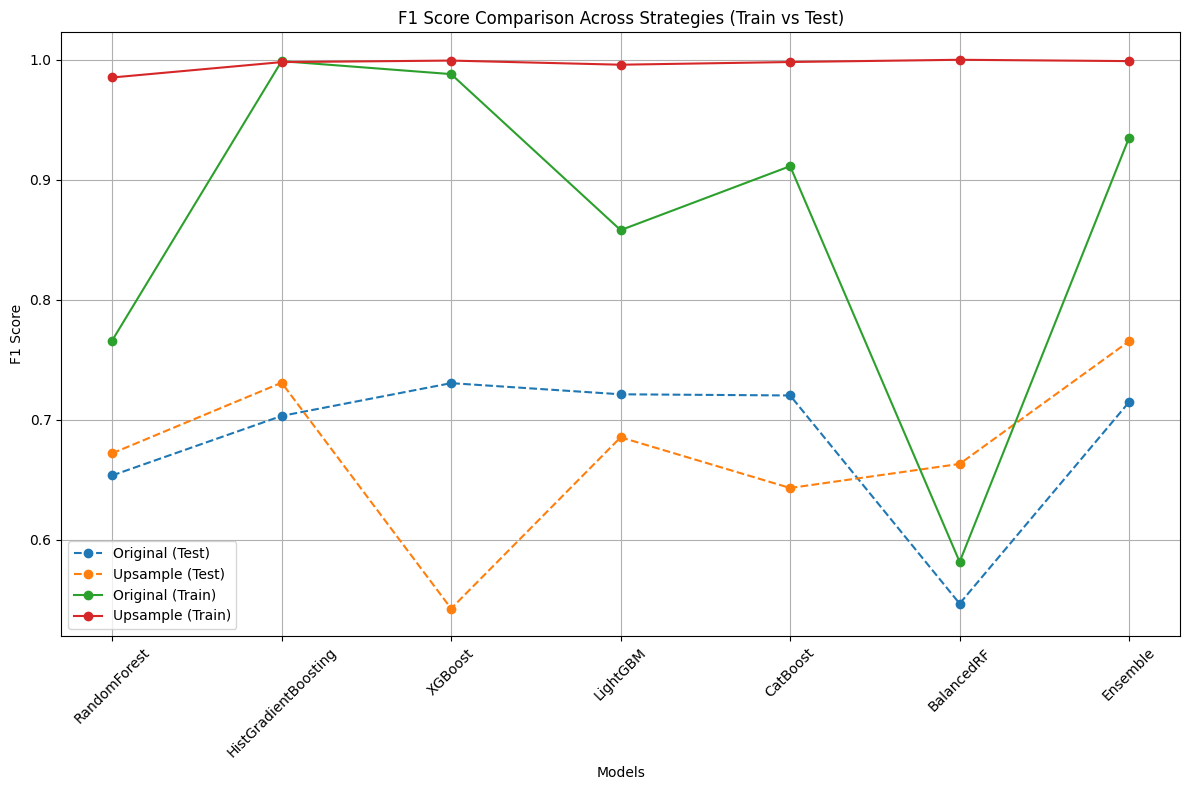

In [59]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# ----------- Step 1: Define input and output -----------
df = final_training_df[columns_to_keep].copy()

X = df.drop(columns=['Hired'])
y = df['Hired']

bool_cols = X.select_dtypes(include='bool').columns
non_bool_cols = [c for c in X.columns.difference(bool_cols) if c != 'Sex_int']

X[bool_cols] = X[bool_cols].astype(int)

scaler = StandardScaler()
X[non_bool_cols] = scaler.fit_transform(X[non_bool_cols])

# ----------- Step 2: Train-test split -----------
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# ----------- Step 3: Prepare data variants -----------
# Impute missing values for non-NaN models
imputer = SimpleImputer(strategy='mean')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Undersampling for original data (with NaNs)
undersampler_orig = RandomUnderSampler(sampling_strategy='majority', random_state=42)
X_train_under_orig, y_train_under_orig = undersampler_orig.fit_resample(X_train, y_train)

# ----------- Step 4: Sampling strategies for imputed data -----------
from imblearn.over_sampling import ADASYN
X_train_smote, y_train_smote = ADASYN().fit_resample(X_train_imputed, y_train)

undersampler_imp = RandomUnderSampler(sampling_strategy='majority', random_state=42)

X_train_undersampled, y_train_undersampled = undersampler_imp.fit_resample(X_train_imputed, y_train)

# ----------- Step 5: Model setup -----------

models = {
    'RandomForest': RandomForestClassifier(class_weight='balanced', random_state=42,max_depth=10,  # Limit tree depth
    min_samples_split=5,  # Minimum samples to split a node
    n_estimators=100),
    'HistGradientBoosting': HistGradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
                            random_state=42, use_label_encoder=False, eval_metric='logloss',max_depth=6,  # Limit tree depth
    gamma=1,  # Regularization term for tree splits
    subsample=0.8,  # Use only a subset of data for training
    colsample_bytree=0.8,  # Use only a subset of features for each tree
    lambda_=1,  # L2 regularization
    alpha=0.1,  # L1 regularization
    # early_stopping_rounds=50
    ),
    'LightGBM': LGBMClassifier(class_weight='balanced', random_state=42,max_depth=6,  # Limit tree depth
    min_data_in_leaf=20,  # Minimum samples in a leaf
    lambda_l1=0.5,  # L1 regularization
    lambda_l2=0.5,  # L2 regularization
    # early_stopping_rounds=50
      ),
}

from catboost import CatBoostClassifier
models['CatBoost'] = CatBoostClassifier(
    auto_class_weights='Balanced',
    silent=True,  # Disable logging
    random_state=42,l2_leaf_reg=3,  # Increase L2 regularization term
    iterations=500,  # Number of iterations
    depth=6,  # Limit tree depth
    learning_rate=0.05,  # Reduce learning rate for more gradual learning
    # early_stopping_rounds=50
)

from imblearn.ensemble import BalancedRandomForestClassifier
models['BalancedRF'] = BalancedRandomForestClassifier(random_state=42)

from sklearn.ensemble import VotingClassifier
ensemble = VotingClassifier(
    estimators=[
        ('xgb', models['XGBoost']),
        ('lgbm', models['LightGBM']),
        ('cat', models['CatBoost'])
    ],
    voting='soft'  # Weighted probability average
)
models['Ensemble'] = ensemble

# ----------- Step 6: Evaluation with strategy-aware data handling -----------
results_train = {}
results_test = {}

for strategy_name in ['Original', 'Upsample']:
    strategy_results_train = []
    strategy_results_test = []
    
    for model_name, model in models.items():
        # Select appropriate data based on sampling strategy
        if model_name in ['XGBoost', 'LightGBM', 'CatBoost', 'BalancedRF']:
            if strategy_name == 'Original':
                X_tr = X_train
                y_tr = y_train
            elif strategy_name == 'Upsample':
                X_tr = X_train_smote
                y_tr = y_train_smote
            X_te = X_test
        else:
            if strategy_name == 'Original':
                X_tr = X_train_imputed
                y_tr = y_train
            elif strategy_name == 'Upsample':
                X_tr = X_train_smote
                y_tr = y_train_smote
            X_te = X_test_imputed
        
        # Train and evaluate the model
        model.fit(X_tr, y_tr)
        y_pred_train = model.predict(X_tr)
        y_pred_test = model.predict(X_te)
        
        # Store results for train data
        strategy_results_train.append([
            model_name,
            f1_score(y_tr, y_pred_train),
            accuracy_score(y_tr, y_pred_train),
            precision_score(y_tr, y_pred_train),
            recall_score(y_tr, y_pred_train)
        ])
        
        # Store results for test data
        strategy_results_test.append([
            model_name,
            f1_score(y_test, y_pred_test),
            accuracy_score(y_test, y_pred_test),
            precision_score(y_test, y_pred_test),
            recall_score(y_test, y_pred_test)
        ])
    
    results_train[strategy_name] = pd.DataFrame(strategy_results_train, 
                                                columns=['Model', 'F1 Score', 'Accuracy', 'Precision', 'Recall'])
    
    results_test[strategy_name] = pd.DataFrame(strategy_results_test, 
                                               columns=['Model', 'F1 Score', 'Accuracy', 'Precision', 'Recall'])

# ----------- Step 7: Display Results for Training Data and Test Data -----------

print("\nTraining Data Results:")
for strategy_name, result_df in results_train.items():
    print(f"\nResults for {strategy_name} Sampling (Training Data):")
    print(result_df.sort_values(by='F1 Score', ascending=False).to_string(index=False))

print("\nTest Data Results:")
for strategy_name, result_df in results_test.items():
    print(f"\nResults for {strategy_name} Sampling (Test Data):")
    print(result_df.sort_values(by='F1 Score', ascending=False).to_string(index=False))

# ----------- Step 8: Plot Results -----------

plt.figure(figsize=(12, 8))
for strategy_name, result_df in results_test.items():
    plt.plot(result_df['Model'], result_df['F1 Score'], 
            label=f"{strategy_name} (Test)", marker='o', linestyle='--')

for strategy_name, result_df in results_train.items():
    plt.plot(result_df['Model'], result_df['F1 Score'], 
            label=f"{strategy_name} (Train)", marker='o', linestyle='-')

plt.title('F1 Score Comparison Across Strategies (Train vs Test)')
plt.ylabel('F1 Score')
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [61]:
from sklearn.linear_model import LogisticRegression

# Update models dictionary to include Logistic Regression
new_models = {}
new_models['LogisticRegression'] = XGBClassifier(
    # n_estimators=50,
    # max_depth=10,             # Reduce tree depth
    # learning_rate=0.05,      # Lower learning rate
    # reg_alpha=1,             # L1 regularization
    # reg_lambda=1,            # L2 regularization
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    random_state=42
)

results_train = {}
results_test = {}

for strategy_name in ['Original', 'Upsample']:
    train_results = []
    test_results = []

    for model_name, model in new_models.items():
        # Select appropriate data
        nan_models=['XGBoost', 'LightGBM', 'CatBoost', 'BalancedRF']
        if model_name in nan_models:
            if strategy_name == 'Original':
                X_tr = X_train
                y_tr = y_train
            elif strategy_name == 'Undersampled':
                X_tr = X_train_under_orig
                y_tr = y_train_under_orig
            X_te = X_test
        else:
            if strategy_name == 'Original':
                X_tr = X_train_imputed
                y_tr = y_train
            elif strategy_name == 'Undersampled':
                X_tr = X_train_undersampled
                y_tr = y_train_undersampled
            X_te = X_test_imputed
        if strategy_name == 'SMOTE':
            X_tr = X_train_smote
            y_tr = y_train_smote
            X_te = X_test_imputed

        # Train model
        model.fit(X_tr, y_tr)

        # Evaluate on train
        y_pred_train = model.predict(X_tr)
        train_results.append([
            model_name,
            f1_score(y_tr, y_pred_train),
            accuracy_score(y_tr, y_pred_train),
            precision_score(y_tr, y_pred_train),
            recall_score(y_tr, y_pred_train)
        ])

        # Evaluate on test
        y_pred_test = model.predict(X_te)
        test_results.append([
            model_name,
            f1_score(y_test, y_pred_test),
            accuracy_score(y_test, y_pred_test),
            precision_score(y_test, y_pred_test),
            recall_score(y_test, y_pred_test)
        ])

    # Save results
    results_train[strategy_name] = pd.DataFrame(train_results, columns=['Model', 'F1 Score', 'Accuracy', 'Precision', 'Recall'])
    results_test[strategy_name] = pd.DataFrame(test_results, columns=['Model', 'F1 Score', 'Accuracy', 'Precision', 'Recall'])
    break
# Print train results
print("🔹 TRAINING RESULTS")
for strategy_name, df in results_train.items():
    print(f"\nResults for {strategy_name} Sampling (Train Data):")
    print(df.sort_values(by='F1 Score', ascending=False).to_string(index=False))

# Print test results
print("\n🔹 TEST RESULTS")
for strategy_name, df in results_test.items():
    print(f"\nResults for {strategy_name} Sampling (Test Data):")
    print(df.sort_values(by='F1 Score', ascending=False).to_string(index=False))



🔹 TRAINING RESULTS

Results for Original Sampling (Train Data):
             Model  F1 Score  Accuracy  Precision  Recall
LogisticRegression  0.998785  0.999859   0.997573     1.0

🔹 TEST RESULTS

Results for Original Sampling (Test Data):
             Model  F1 Score  Accuracy  Precision   Recall
LogisticRegression  0.754717  0.970671   0.733945 0.776699


In [62]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

# Step 1: Feature selection using RandomForest
rf_selector = RandomForestClassifier(random_state=42)
rf_selector.fit(X_train_imputed, y_train)

# Create selector using median threshold
selector = SelectFromModel(rf_selector, threshold="median", prefit=True)

# Transform training and test sets
X_train_reduced = selector.transform(X_train_imputed)
X_test_reduced = selector.transform(X_test_imputed)

# (Optional) View selected feature names
selected_features = X_train_imputed.columns[selector.get_support()]
print("Selected features:\n", selected_features.tolist())

# Step 2: Train XGBoost on reduced features
xgb_reduced = XGBClassifier(
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
)
xgb_reduced.fit(X_train_reduced, y_train)

# Step 3: Evaluation
# Training data results
y_train_pred = xgb_reduced.predict(X_train_reduced)
print("\n🔹 XGBoost on Reduced Features - Training Results")
print(f"F1 Score: {f1_score(y_train, y_train_pred):.4f}")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Precision: {precision_score(y_train, y_train_pred):.4f}")
print(f"Recall: {recall_score(y_train, y_train_pred):.4f}")

# Test data results
y_test_pred = xgb_reduced.predict(X_test_reduced)
print("\n🔹 XGBoost on Reduced Features - Test Results")
print(f"F1 Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")


Selected features:
 ['Overall', 'Standing/Position', 'Comunication', 'Maturity', 'Dynamism', 'Mobility', 'English', 'experience_match_score', 'Years Experience.1_int', 'Ral Maximum', 'professional_similarity_score', 'study_area_score', 'general_similarity_score', 'general_similarity_score_tfidf', 'general_similarity_score_cross']

🔹 XGBoost on Reduced Features - Training Results
F1 Score: 0.9988
Accuracy: 0.9999
Precision: 0.9976
Recall: 1.0000

🔹 XGBoost on Reduced Features - Test Results
F1 Score: 0.7136
Accuracy: 0.9656
Precision: 0.6909
Recall: 0.7379


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import shap
import matplotlib.pyplot as plt

# ----------- Setup and Preprocessing -----------
columns_to_keep = ['Sex_int', 'Protected category', 
       'Overall', 'Technical Skills', 'Standing/Position', 'Comunication',
       'Maturity', 'Dynamism', 'Mobility', 'English', 
       'Hired', 'Italian Residence', 'European Residence', 
       'Age Range_int', 'experience_match_score', 'Years Experience_int', 
       'Years Experience.1_int', 'current_salary_fit_score', 'Current Ral',
       'Expected Ral', 'Minimum Ral', 'Ral Maximum', 'expected_salary_fit_score', 
       'study_title_score', 'Study Level_int', 'Study Title_int',
       'professional_similarity_score', 'study_area_score',
       'general_similarity_score', 'general_similarity_score_tfidf',
       'general_similarity_score_cross']

df = final_training_df[columns_to_keep].copy()

X = df.drop(columns='Hired')
y = df['Hired']

bool_cols = X.select_dtypes(include='bool').columns
non_bool_cols = [c for c in X.columns.difference(bool_cols) if c != 'Sex_int']

X[bool_cols] = X[bool_cols].astype(int)

scaler = StandardScaler()
X[non_bool_cols] = scaler.fit_transform(X[non_bool_cols])

imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# ----------- Define Ensemble and Train (Initial) -----------
base_models = [
    ('xgb', XGBClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
                          random_state=42, use_label_encoder=False, eval_metric='logloss')),
    ('lgbm', LGBMClassifier(class_weight='balanced', random_state=42)),
    ('cat', CatBoostClassifier(auto_class_weights='Balanced', silent=True, random_state=42))
]

ensemble = VotingClassifier(estimators=base_models, voting='soft')
ensemble.fit(X_train, y_train)

y_pred = ensemble.predict(X_test)
y_train_pred = ensemble.predict(X_train)
print("🔹 Initial Ensemble Performance on Training Data:")
print(f"F1 Score: {f1_score(y_train, y_train_pred):.3f}")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.3f}")
print(f"Precision: {precision_score(y_train, y_train_pred):.3f}")
print(f"Recall: {recall_score(y_train, y_train_pred):.3f}")
print("🔹 Initial Ensemble Performance:")
print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall: {recall_score(y_test, y_pred):.3f}")

# ----------- Grid Search on LightGBM (inside ensemble) -----------
param_grid = {
    'lgbm__num_leaves': [15, 31],
    'lgbm__learning_rate': [0.05, 0.1],
    'lgbm__n_estimators': [50, 100],
    'lgbm__lambda_l1': [0, 0.1, 1],
    'lgbm__lambda_l2': [0, 0.1, 1],
    'lgbm__max_depth': [-1, 5, 10],
    'lgbm__min_data_in_leaf': [20, 50],
    'lgbm__feature_fraction': [0.6, 0.8, 1],
    'lgbm__bagging_fraction': [0.6, 0.8, 1]
}
grid = GridSearchCV(ensemble, param_grid, scoring='f1', cv=3, n_jobs=-1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
y_pred_grid = best_model.predict(X_test)

y_train_pred_grid = best_model.predict(X_train)
print("\n🔹 Post Grid Search Performance on Training Data:")
print(f"F1 Score: {f1_score(y_train, y_train_pred_grid):.3f}")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred_grid):.3f}")
print(f"Precision: {precision_score(y_train, y_train_pred_grid):.3f}")
print(f"Recall: {recall_score(y_train, y_train_pred_grid):.3f}")
print("\n🔹 Post Grid Search Performance:")
print(f"F1 Score: {f1_score(y_test, y_pred_grid):.3f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_grid):.3f}")
print(f"Precision: {precision_score(y_test, y_pred_grid):.3f}")
print(f"Recall: {recall_score(y_test, y_pred_grid):.3f}")

# ----------- SHAP Analysis using LightGBM -----------
explainer = shap.TreeExplainer(best_model.named_estimators_['lgbm'])
shap_values = explainer.shap_values(X_test)

print("\n🔹 SHAP Summary Plot:")
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, max_display=35)

# ----------- Fairness Metrics by Sex and Protected Category -----------
X_test_eval = X_test.copy()
X_test_eval['y_true'] = y_test
X_test_eval['y_pred'] = y_pred_grid
X_test_eval['Sex_int'] = final_training_df.loc[X_test.index, 'Sex_int'].values
X_test_eval['Protected category'] = final_training_df.loc[X_test.index, 'Protected category'].values

# ----------- Extended Fairness Analysis -----------

# Merge sensitive attributes from original dataset
X_test_eval['Age Range_int'] = final_training_df.loc[X_test.index, 'Age Range_int'].values
X_test_eval['European Residence'] = final_training_df.loc[X_test.index, 'European Residence'].values
X_test_eval['Italian Residence'] = final_training_df.loc[X_test.index, 'Italian Residence'].values
X_test_eval['Current Ral'] = final_training_df.loc[X_test.index, 'Current Ral'].values
X_test_eval['Expected Ral'] = final_training_df.loc[X_test.index, 'Expected Ral'].values

# Bin salary ranges for fairness analysis
X_test_eval['Current Ral Bin'] = pd.qcut(X_test_eval['Current Ral'], q=3, duplicates='drop')
X_test_eval['Expected Ral Bin'] = pd.qcut(X_test_eval['Expected Ral'], q=3, duplicates='drop')

sensitive_attributes = [
    'Sex_int', 'Protected category', 'Age Range_int', 
    'European Residence', 'Italian Residence', 
    'Current Ral Bin', 'Expected Ral Bin'
]

for attr in sensitive_attributes:
    print(f"\n🔹 Fairness by {attr}")
    for val, grp in X_test_eval.groupby(attr):
        if len(grp) < 5:  # avoid small sample bias
            continue
        print(f"{attr} = {val}")
        print(f"  Count: {len(grp)}")
        print(f"  F1 Score: {f1_score(grp['y_true'], grp['y_pred']):.3f}")
        print(f"  Precision: {precision_score(grp['y_true'], grp['y_pred']):.3f}")
        print(f"  Recall: {recall_score(grp['y_true'], grp['y_pred']):.3f}")



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 411, number of negative: 6680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1626
[LightGBM] [Info] Number of data points in the train set: 7091, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
🔹 Initial Ensemble Performance on Training Data:
F1 Score: 0.983
Accuracy: 0.998
Precision: 0.967
Recall: 1.000
🔹 Initial Ensemble Performance:
F1 Score: 0.715
Accuracy: 0.964
Precision: 0.669
Recall: 0.767


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [

/home/lyudmil/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:59:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/lyudmil/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:59:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambd

/home/lyudmil/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:59:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/lyudmil/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:59:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/lyudmil/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:59:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/lyudmil/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:59:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/lyudmil/.local/lib/python3.10/site-packages/xgboost/tr

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [

/home/lyudmil/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:59:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/lyudmil/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:59:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 274, number of negative: 4453
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored

In [88]:
shap_values.shape, len(columns_to_keep)

((1773, 30), 31)

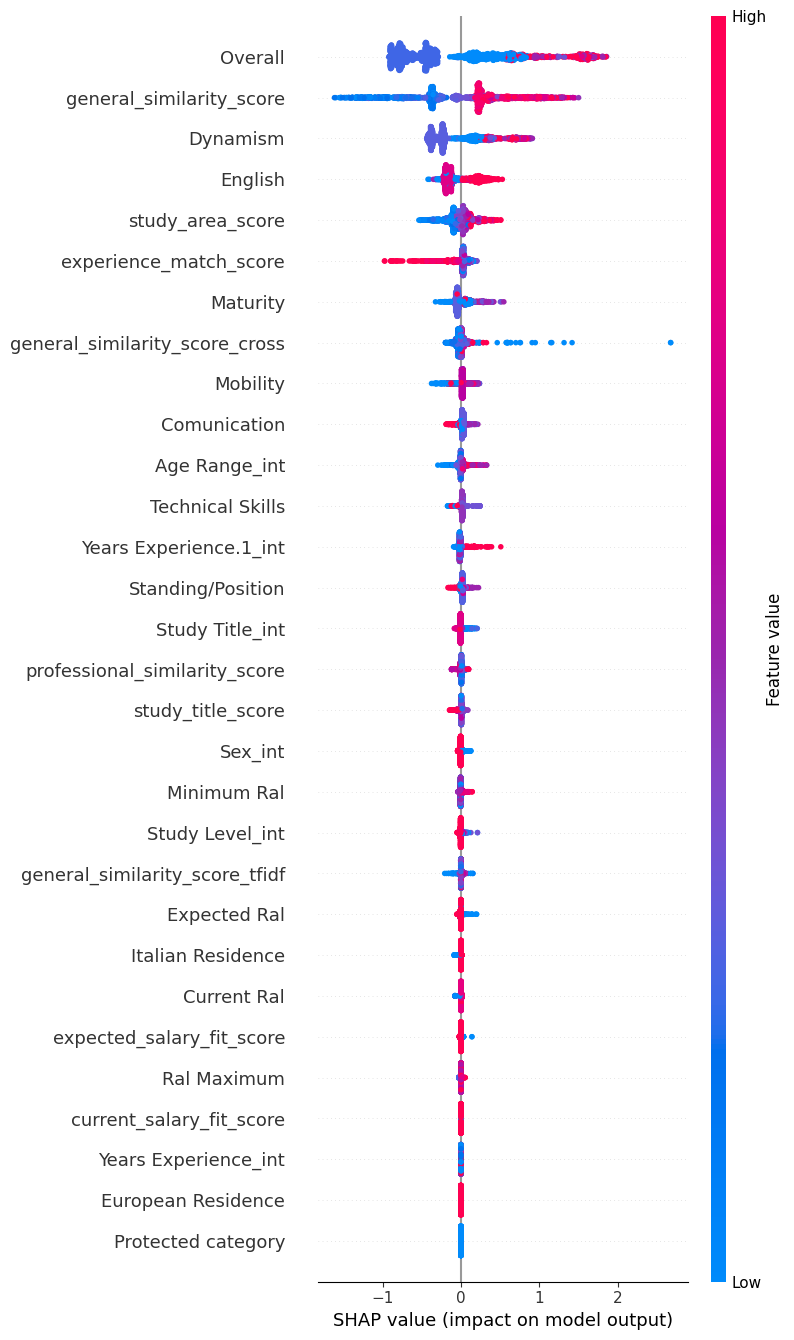

In [ ]:
# Limiting the number of features in the SHAP summary plot
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, max_display=35)


In [60]:
df['Hired'].sum(), len(df)

(np.int64(514), 8864)

In [ ]:
from sklearn.model_selection import GridSearchCV

# Update model configurations with parameter grids
model_configs = {
    'HistGradientBoosting': {
        'estimator': HistGradientBoostingClassifier(random_state=42),
        'params': {
            'learning_rate': [0.05, 0.1],
            'max_iter': [100, 200, 500],
            'max_depth': [4, 8, 16],
            'l2_regularization': [0, 0.1, 0.5]
        }
    },
    'XGBoost': {
        'estimator': XGBClassifier(
            random_state=42,
            use_label_encoder=False,
            eval_metric='logloss'
        ),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [4, 8, 16],
            'learning_rate': [0.01, 0.05, 0.1],
            'subsample': [0.8, 1.0]
        }
    },
    # 'LightGBM': {
    #     'estimator': LGBMClassifier(random_state=42),
    #     'params': {
    #         'n_estimators': [100, 200, 300],
    #         'max_depth': [4, 8, 16],
    #         'learning_rate': [0.01, 0.05, 0.1],
    #         'class_weight': ['balanced', None]
    #     }
    # }
}

# Updated evaluation with grid search
results = {}

# for strategy_name in ['Original', 'SMOTE', 'Undersampled']:
for strategy_name in ['Original']:
    strategy_results = []
    from tqdm import tqdm
    for model_name, config in tqdm(model_configs.items()):
        # Skip SMOTE for NaN-handling models
        if strategy_name == 'SMOTE' and model_name in nan_models:
            continue
            
        # Select appropriate data
        if model_name in nan_models:
            if strategy_name == 'Original':
                X_tr = X_train
                y_tr = y_train
                X_te = X_test
            elif strategy_name == 'Undersampled':
                X_tr = X_train_under_orig
                y_tr = y_train_under_orig
                X_te = X_test
        else:
            if strategy_name == 'Original':
                X_tr = X_train_imputed
                y_tr = y_train
            elif strategy_name == 'SMOTE':
                X_tr = X_train_smote
                y_tr = y_train_smote
            elif strategy_name == 'Undersampled':
                X_tr = X_train_undersampled
                y_tr = y_train_undersampled
            X_te = X_test_imputed

        # Dynamic parameter adjustment for XGBoost
        if model_name == 'XGBoost':
            config['estimator'].set_params(
                scale_pos_weight=(y_tr == 0).sum() / (y_tr == 1).sum())
        
        # Setup grid search
        grid = GridSearchCV(
            estimator=config['estimator'],
            param_grid=config['params'],
            scoring='f1',
            cv=3,
            n_jobs=-1,
            verbose=0
        )
        
        # Train and evaluate
        grid.fit(X_tr, y_tr)
        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_te)
        
        strategy_results.append({
            'Model': model_name,
            'F1 Score': f1_score(y_test, y_pred),
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'Best Params': grid.best_params_
        })
    
    results[strategy_name] = pd.DataFrame(strategy_results)

# Display results with best parameters
for strategy_name, result_df in results.items():
    print(f"\n--- {strategy_name} Strategy Results with Grid Search ---")
    print(result_df.sort_values(by='F1 Score', ascending=False).to_string(index=False))

# Plotting remains the same
plt.figure(figsize=(12, 8))
for strategy_name, result_df in results.items():
    plt.plot(result_df['Model'], result_df['F1 Score'], 
            label=strategy_name, marker='o', linestyle='--')

plt.title('F1 Score Comparison with Grid Search Tuning')
plt.ylabel('F1 Score')
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

  0%|          | 0/2 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

KeyboardInterrupt: 

==== Dataset Fairness Audit ====


--- Sex ---
        Selection Rate  Group Size  Disparate Impact  Statistical Parity Diff
Sex                                                                          
Female        0.082040        1804          0.631904                -0.030199
Male          0.051841        7060          0.631904                -0.030199


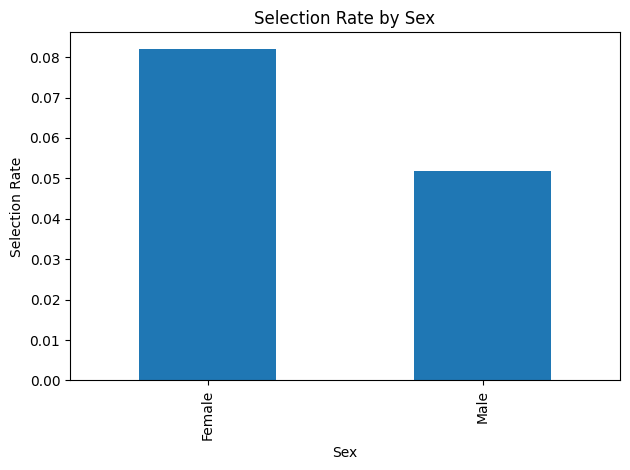


--- Protected category ---
                    Selection Rate  Group Size  Disparate Impact  \
Protected category                                                 
False                     0.058047        8786          0.883459   
True                      0.051282          78          0.883459   

                    Statistical Parity Diff  
Protected category                           
False                             -0.006765  
True                              -0.006765  


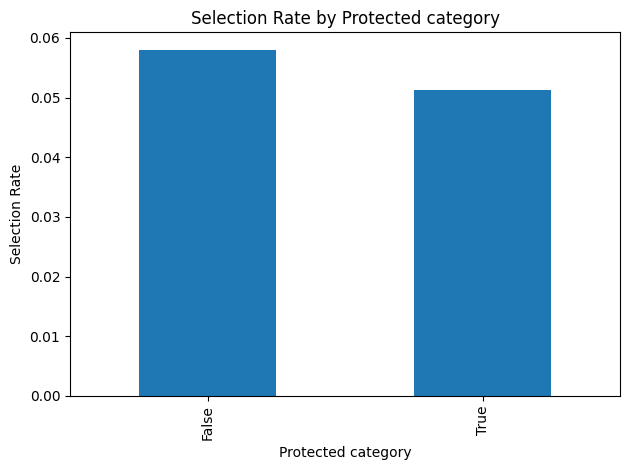


--- Age Range ---
               Selection Rate  Group Size  Disparate Impact  \
Age Range                                                     
20 - 25 years        0.037755         980          0.366499   
26 - 30 years        0.060712        3146          0.366499   
31 - 35 years        0.082474        1164          0.366499   
36 - 40 years        0.082043         646          0.366499   
40 - 45 years        0.078947         418          0.366499   
< 20 years           0.030227        1588          0.366499   
> 45 years           0.060738         922          0.366499   

               Statistical Parity Diff  
Age Range                               
20 - 25 years                -0.052248  
26 - 30 years                -0.052248  
31 - 35 years                -0.052248  
36 - 40 years                -0.052248  
40 - 45 years                -0.052248  
< 20 years                   -0.052248  
> 45 years                   -0.052248  


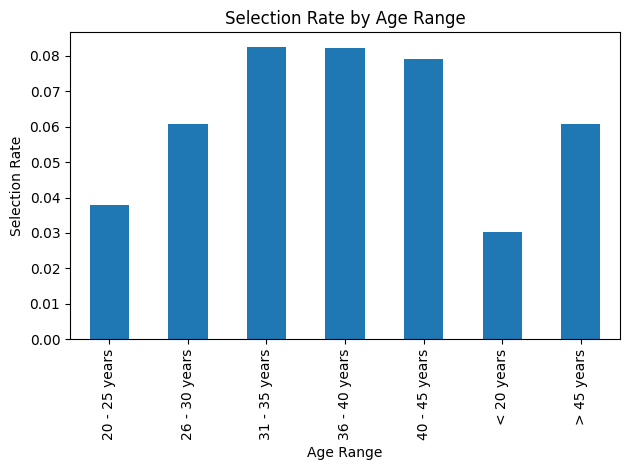


--- Italian Residence ---
                   Selection Rate  Group Size  Disparate Impact  \
Italian Residence                                                 
False                    0.017928         502          0.296864   
True                     0.060392        8362          0.296864   

                   Statistical Parity Diff  
Italian Residence                           
False                            -0.042464  
True                             -0.042464  


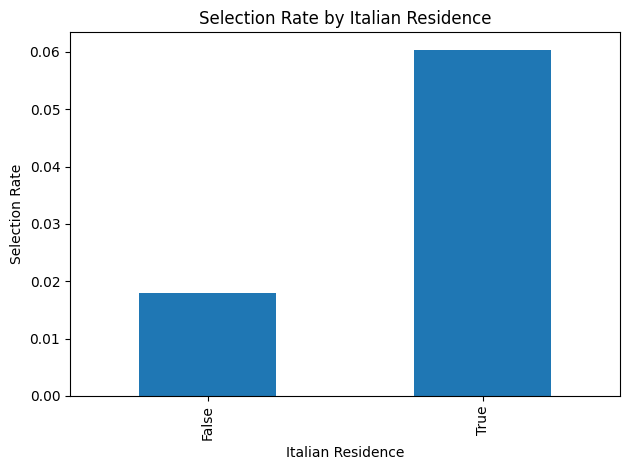


--- European Residence ---
                    Selection Rate  Group Size  Disparate Impact  \
European Residence                                                 
False                     0.011111         180          0.188455   
True                      0.058959        8684          0.188455   

                    Statistical Parity Diff  
European Residence                           
False                             -0.047848  
True                              -0.047848  


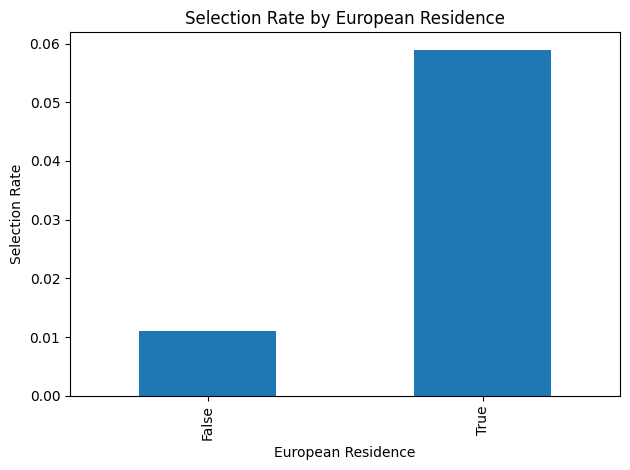


================== XGBoost Fairness ==================

--- Fairness for Sex_int ---
         Selection Rate       TPR       FPR       FNR  Precision
Sex_int                                                         
0              0.055851  0.684211  0.022409  0.315789   0.619048
1              0.066571  0.750000  0.022848  0.250000   0.677419
Demographic Parity Difference: 0.011
Equalized Odds Difference: 0.066


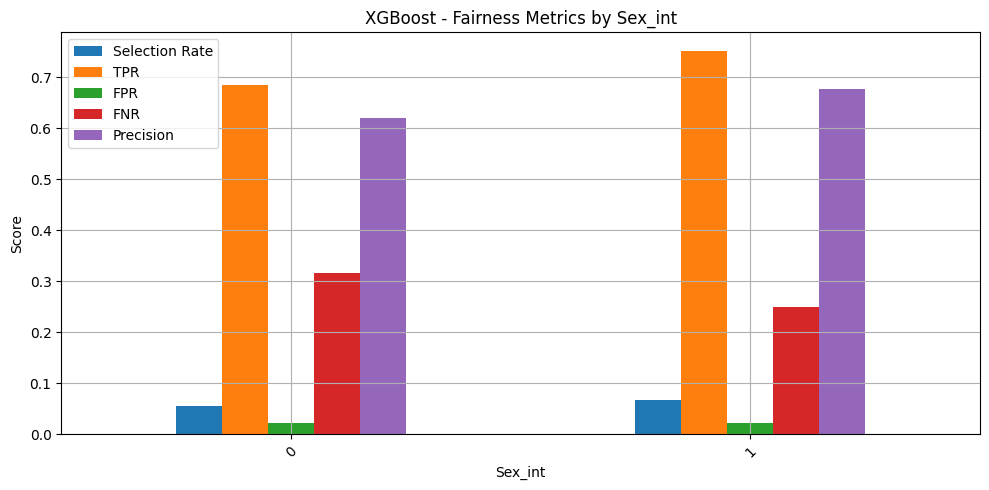


--- Fairness for Protected category ---
                    Selection Rate       TPR      FPR       FNR  Precision
Protected category                                                        
False                     0.064314  0.737864  0.02237  0.262136   0.672566
True                      0.062500  0.000000  0.06250  0.000000   0.000000
Demographic Parity Difference: 0.002
Equalized Odds Difference: 0.738


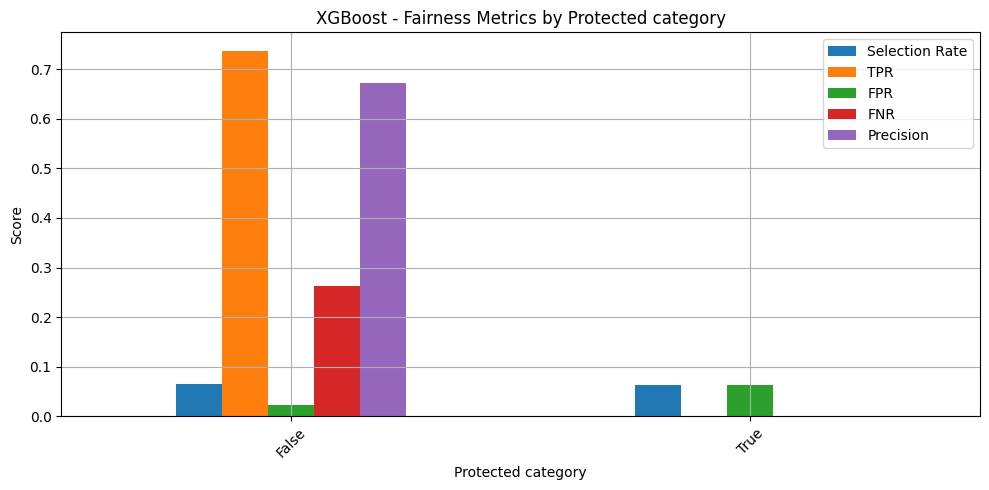


--- Fairness for Age Range_int ---
               Selection Rate       TPR       FPR       FNR  Precision
Age Range_int                                                         
0                    0.073171  0.916667  0.029915  0.083333   0.611111
1                    0.088608  0.900000  0.033784  0.100000   0.642857
2                    0.060472  0.704545  0.015773  0.295455   0.756098
3                    0.054422  0.615385  0.028470  0.384615   0.500000
4                    0.069767  0.545455  0.025424  0.454545   0.666667
5                    0.091837  1.000000  0.043011  0.000000   0.555556
6                    0.041176  0.750000  0.006173  0.250000   0.857143
Demographic Parity Difference: 0.051
Equalized Odds Difference: 0.455


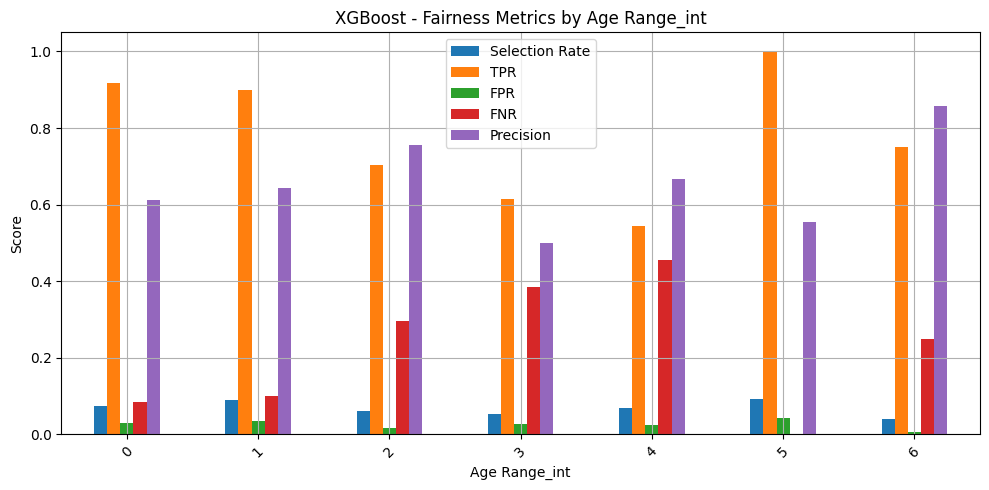


--- Fairness for Italian Residence ---
                   Selection Rate       TPR       FPR       FNR  Precision
Italian Residence                                                         
False                    0.033333  1.000000  0.000000  0.000000   1.000000
True                     0.065382  0.732673  0.023573  0.267327   0.660714
Demographic Parity Difference: 0.032
Equalized Odds Difference: 0.267


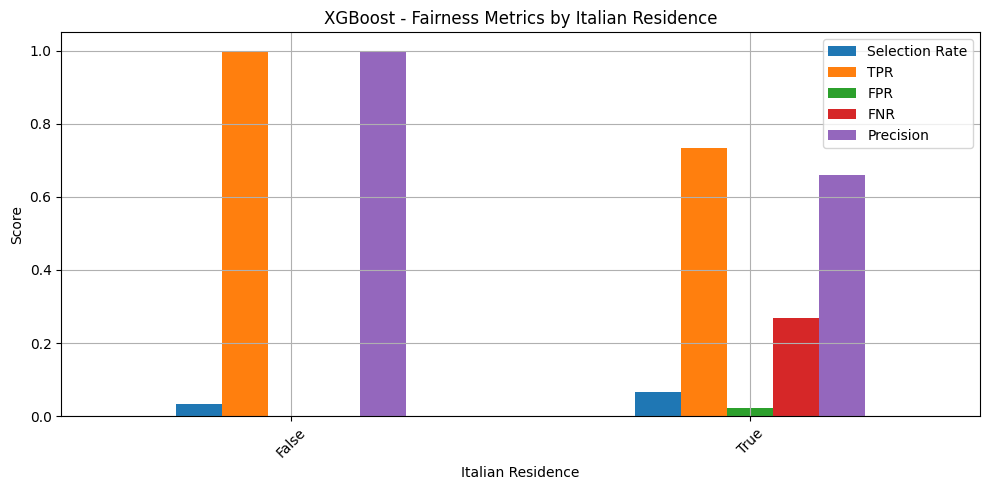


--- Fairness for European Residence ---
                    Selection Rate       TPR       FPR       FNR  Precision
European Residence                                                         
False                     0.000000  0.000000  0.000000  0.000000   0.000000
True                      0.064663  0.737864  0.022892  0.262136   0.666667
Demographic Parity Difference: 0.065
Equalized Odds Difference: 0.738


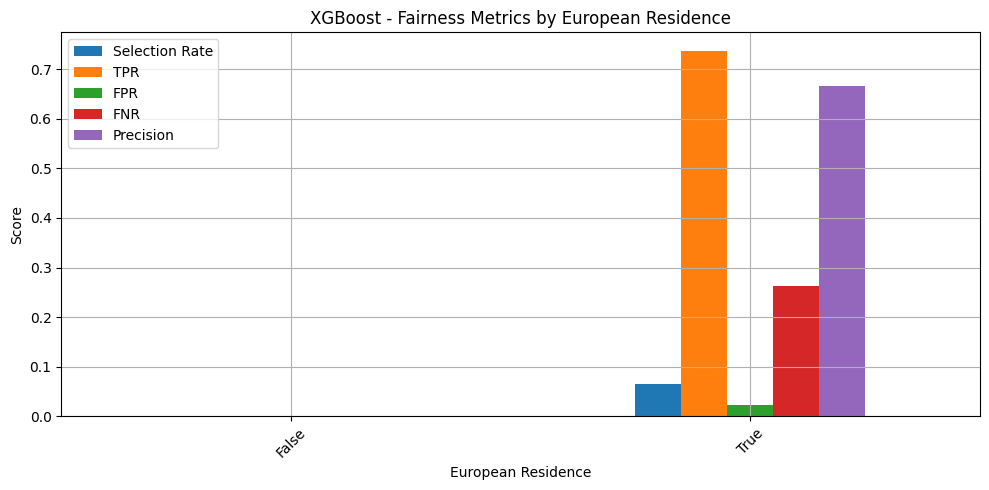


================== LightGBM Fairness ==================
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 411, number of negative: 6680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 7091, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000

--- Fairness for Sex_int ---
         Selection Rate       TPR       FPR       FNR  Precision
Sex_int                                                         
0              0.069149  0.736842  0.033613  0.263158   0.538462
1              0.079456  0.833333  0.031226  0.166667   0.630631
Demographic Parity Difference: 0.010
Equalized Odds Difference: 0.096


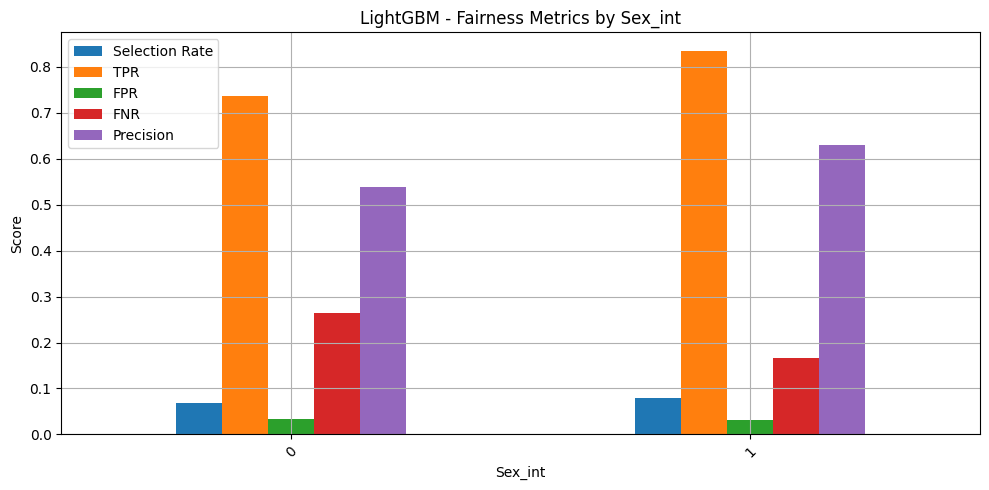


--- Fairness for Protected category ---
                    Selection Rate       TPR       FPR       FNR  Precision
Protected category                                                         
False                     0.076836  0.815534  0.030834  0.184466   0.622222
True                      0.125000  0.000000  0.125000  0.000000   0.000000
Demographic Parity Difference: 0.048
Equalized Odds Difference: 0.816


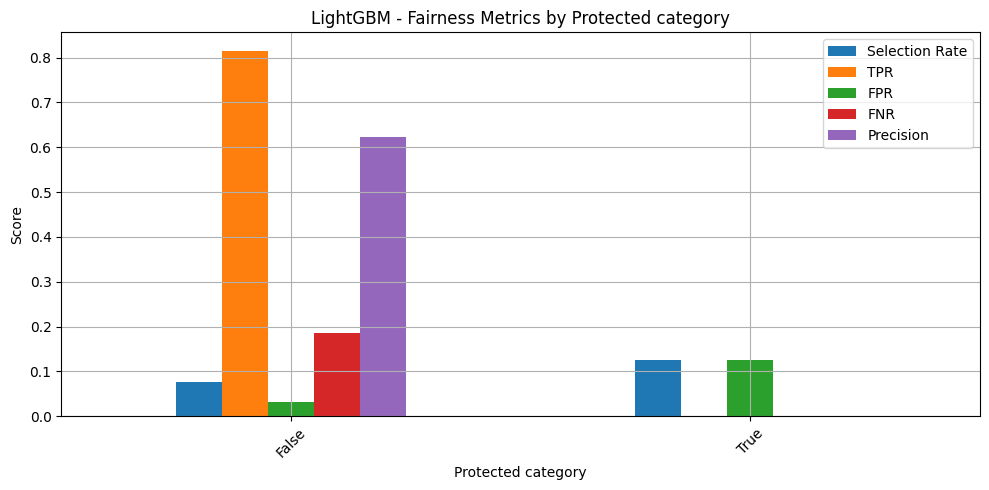


--- Fairness for Age Range_int ---
               Selection Rate       TPR       FPR       FNR  Precision
Age Range_int                                                         
0                    0.069106  1.000000  0.021368  0.000000   0.705882
1                    0.101266  0.900000  0.047297  0.100000   0.562500
2                    0.078171  0.818182  0.026814  0.181818   0.679245
3                    0.071429  0.846154  0.035587  0.153846   0.523810
4                    0.062016  0.454545  0.025424  0.545455   0.625000
5                    0.102041  1.000000  0.053763  0.000000   0.500000
6                    0.070588  0.750000  0.037037  0.250000   0.500000
Demographic Parity Difference: 0.040
Equalized Odds Difference: 0.545


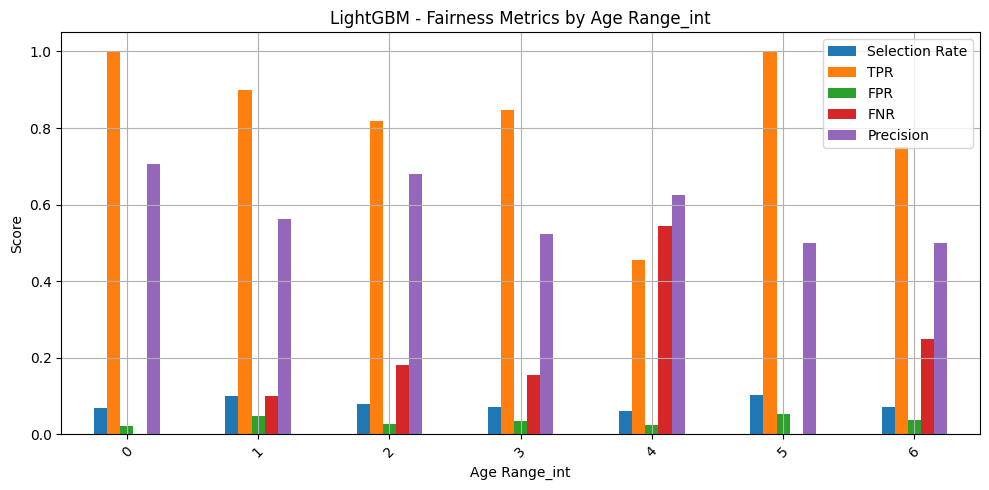


--- Fairness for Italian Residence ---
                   Selection Rate       TPR       FPR       FNR  Precision
Italian Residence                                                         
False                    0.066667  1.000000  0.034483  0.000000   0.500000
True                     0.077642  0.811881  0.031638  0.188119   0.616541
Demographic Parity Difference: 0.011
Equalized Odds Difference: 0.188


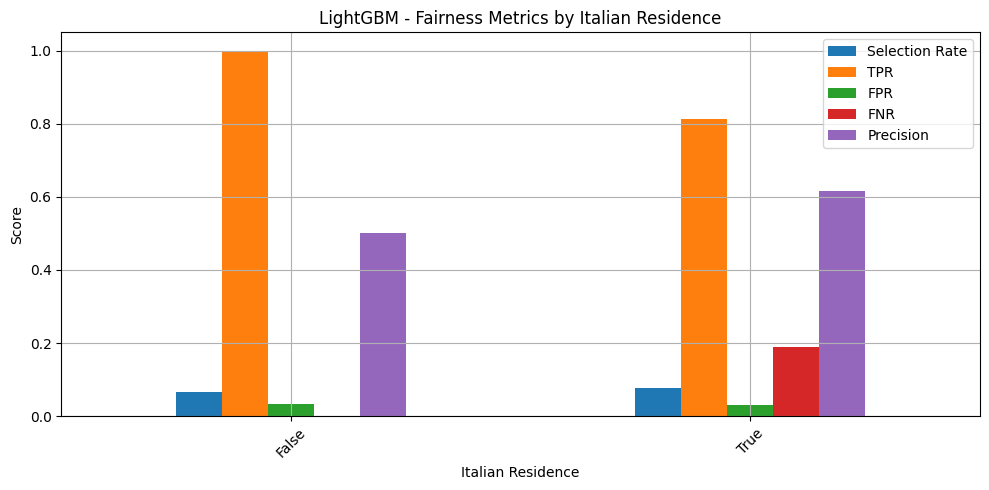


--- Fairness for European Residence ---
                    Selection Rate       TPR       FPR       FNR  Precision
European Residence                                                         
False                     0.100000  0.000000  0.100000  0.000000   0.000000
True                      0.077141  0.815534  0.031325  0.184466   0.617647
Demographic Parity Difference: 0.023
Equalized Odds Difference: 0.816


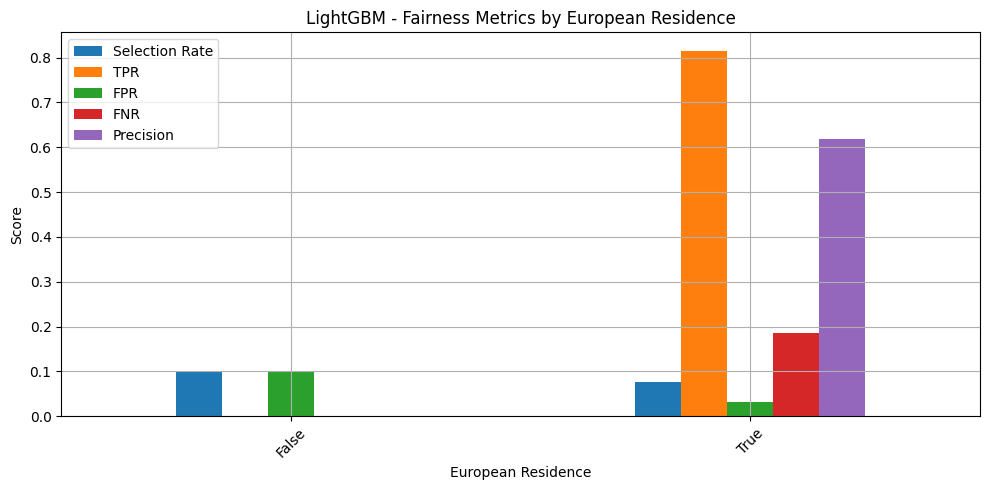

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 411, number of negative: 6680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 7091, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


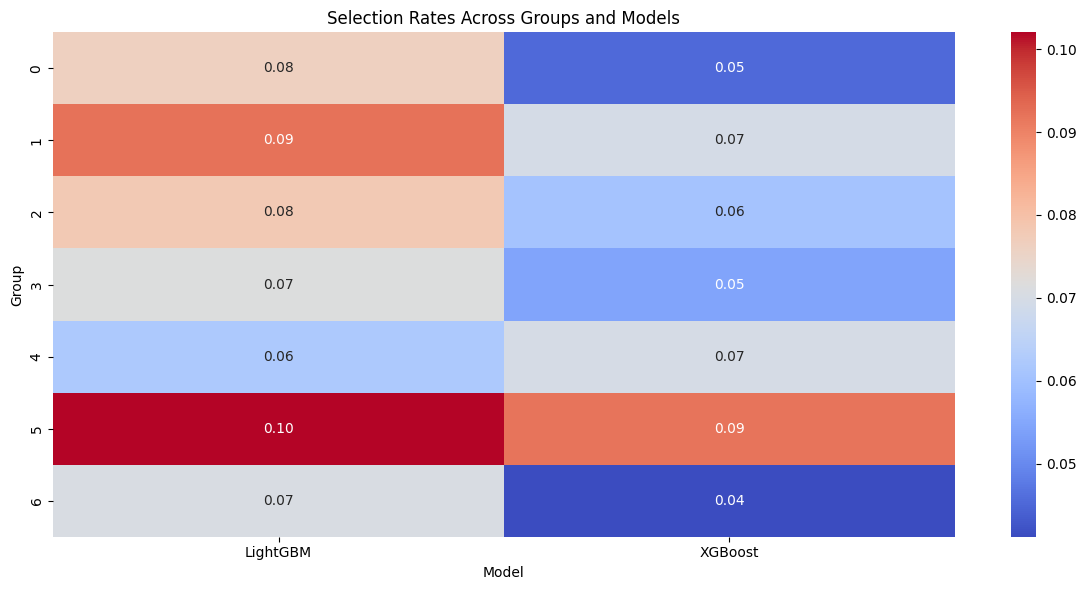

In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fairlearn.metrics import (
    MetricFrame, selection_rate, true_positive_rate, false_positive_rate,
    demographic_parity_difference, equalized_odds_difference, false_negative_rate

)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# =================== PART 1: ENHANCED DATASET BIAS CHECK ===================

df = final_training_df.copy()

protected_attributes = [
    'Sex', 'Protected category', 'Age Range',
    'Italian Residence', 'European Residence'
]

# Drop rows with missing target or any protected attribute
df = df.dropna(subset=protected_attributes + ['Hired'])

print("==== Dataset Fairness Audit ====\n")

for attr in protected_attributes:
    print(f"\n--- {attr} ---")
    group_stats = df.groupby(attr)['Hired'].agg(['mean', 'count'])
    group_stats.columns = ['Selection Rate', 'Group Size']
    
    privileged = group_stats['Selection Rate'].max()
    unprivileged = group_stats['Selection Rate'].min()

    group_stats['Disparate Impact'] = unprivileged / privileged if privileged > 0 else 0
    group_stats['Statistical Parity Diff'] = unprivileged - privileged

    print(group_stats)

    # Visualize selection rate
    group_stats['Selection Rate'].plot(kind='bar', title=f'Selection Rate by {attr}')
    plt.ylabel("Selection Rate")
    plt.xlabel(attr)
    plt.tight_layout()
    plt.show()

# =================== PART 2: MODEL FAIRNESS EVALUATION ===================

df = df[columns_to_keep]

X = df.drop(columns=['Hired'])
y = df['Hired']

bool_cols = X.select_dtypes(include='bool').columns
non_bool_cols = [c for c in X.columns.difference(bool_cols)]

X[bool_cols] = X[bool_cols].astype(int)
scaler = StandardScaler()
X[non_bool_cols] = scaler.fit_transform(X[non_bool_cols])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42)

# Impute
imputer = SimpleImputer(strategy='mean')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X.columns)

# Models
models = {
    'XGBoost': XGBClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
                             random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(class_weight='balanced', random_state=42)
}

# =================== Fairness Evaluation ===================
protected_attributes = [
    'Sex_int', 'Protected category', 'Age Range_int',
    'Italian Residence', 'European Residence'
]
for name, model in models.items():
    print(f"\n================== {name} Fairness ==================")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    for attr in protected_attributes:
        print(f"\n--- Fairness for {attr} ---")
        sensitive = df.loc[X_test.index, attr]

        metric_frame = MetricFrame(
            metrics={
                'Selection Rate': selection_rate,
                'TPR': true_positive_rate,
                'FPR': false_positive_rate,
                'FNR': false_negative_rate,
                'Precision': precision_score
            },
            y_true=y_test,
            y_pred=y_pred,
            sensitive_features=sensitive
        )

        print(metric_frame.by_group)

        # Additional group disparity metrics
        dpd = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive)
        eod = equalized_odds_difference(y_test, y_pred, sensitive_features=sensitive)
        print(f"Demographic Parity Difference: {dpd:.3f}")
        print(f"Equalized Odds Difference: {eod:.3f}")

        # ---- Visualization ----
        fig, ax = plt.subplots(figsize=(10, 5))
        metric_frame.by_group.plot(kind='bar', ax=ax)
        plt.title(f'{name} - Fairness Metrics by {attr}')
        plt.ylabel('Score')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# =================== OPTIONAL: HEATMAP SUMMARY ===================

summary_scores = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    for attr in protected_attributes:
        sensitive = df.loc[X_test.index, attr]
        metric_frame = MetricFrame(metrics=selection_rate, y_true=y_test, y_pred=y_pred,
                                   sensitive_features=sensitive)
        for group, rate in metric_frame.by_group.items():
            summary_scores.append({'Model': name, 'Attribute': attr, 'Group': group, 'Selection Rate': rate})

summary_df = pd.DataFrame(summary_scores)

plt.figure(figsize=(12, 6))
heatmap_data = summary_df.pivot_table(index='Group', columns='Model', values='Selection Rate', aggfunc='mean')

sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('Selection Rates Across Groups and Models')
plt.tight_layout()
plt.show()


In [62]:
# import torch
# import torch.nn as nn
# from transformers import AutoTokenizer, AutoModel
# from torch.utils.data import Dataset, DataLoader
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
# import pandas as pd
# from tqdm import tqdm
# import numpy as np

# # Configuration
# MODEL_NAME = 'bert-base-uncased'
# MAX_LENGTH = 128
# BATCH_SIZE = 32
# EMBEDDING_SIZE = 768  # For BERT-base
# HIDDEN_SIZE = 256
# EPOCHS = 10
# LEARNING_RATE = 2e-5
# df = final_training_df.copy()
# # Split data (train 60%, val 20%, test 20%)
# train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42, stratify=df['Hired'])
# val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['Hired'])

# # Dataset class
# class CandidateJobDataset(Dataset):
#     def __init__(self, df, tokenizer, max_length):
#         self.df = df
#         self.tokenizer = tokenizer
#         self.max_length = max_length
        
#     def __len__(self):
#         return len(self.df)
    
#     def __getitem__(self, idx):
#         row = self.df.iloc[idx]
#         candidate_text = str(row['candidate_text'])
#         job_text = str(row['job_text'])
#         label = int(row['Hired'])
        
#         candidate_enc = self.tokenizer(
#             candidate_text,
#             max_length=self.max_length,
#             padding='max_length',
#             truncation=True,
#             return_tensors='pt'
#         )
        
#         job_enc = self.tokenizer(
#             job_text,
#             max_length=self.max_length,
#             padding='max_length',
#             truncation=True,
#             return_tensors='pt'
#         )
        
#         return {
#             'candidate_input_ids': candidate_enc['input_ids'].squeeze(0),
#             'candidate_attention_mask': candidate_enc['attention_mask'].squeeze(0),
#             'job_input_ids': job_enc['input_ids'].squeeze(0),
#             'job_attention_mask': job_enc['attention_mask'].squeeze(0),
#             'label': torch.tensor(label, dtype=torch.long)
#         }

# # Initialize tokenizer
# tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# # Create datasets and dataloaders
# train_dataset = CandidateJobDataset(train_df, tokenizer, MAX_LENGTH)
# val_dataset = CandidateJobDataset(val_df, tokenizer, MAX_LENGTH)
# test_dataset = CandidateJobDataset(test_df, tokenizer, MAX_LENGTH)

# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# # Model architecture
# class CandidateJobClassifier(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.bert = AutoModel.from_pretrained(MODEL_NAME)
        
#         # Freeze BERT parameters (optional - can fine-tune if you have enough data)
#         for param in self.bert.parameters():
#             param.requires_grad = False
            
#         self.candidate_proj = nn.Sequential(
#             nn.Linear(EMBEDDING_SIZE, HIDDEN_SIZE),
#             nn.ReLU(),
#             nn.Dropout(0.1)
#         )
        
#         self.job_proj = nn.Sequential(
#             nn.Linear(EMBEDDING_SIZE, HIDDEN_SIZE),
#             nn.ReLU(),
#             nn.Dropout(0.1)
#         )
        
#         self.classifier = nn.Sequential(
#             nn.Linear(HIDDEN_SIZE * 2, HIDDEN_SIZE),
#             nn.ReLU(),
#             nn.Dropout(0.1),
#             nn.Linear(HIDDEN_SIZE, 1),
#             nn.Sigmoid()
#         )
        
#     def forward(self, candidate_input_ids, candidate_attention_mask, 
#                 job_input_ids, job_attention_mask):
#         # Get candidate embedding
#         candidate_outputs = self.bert(
#             input_ids=candidate_input_ids,
#             attention_mask=candidate_attention_mask
#         )
#         candidate_pooled = candidate_outputs.last_hidden_state[:, 0, :]  # CLS token
#         candidate_proj = self.candidate_proj(candidate_pooled)
        
#         # Get job embedding
#         job_outputs = self.bert(
#             input_ids=job_input_ids,
#             attention_mask=job_attention_mask
#         )
#         job_pooled = job_outputs.last_hidden_state[:, 0, :]
#         job_proj = self.job_proj(job_pooled)
        
#         # Combine features
#         combined = torch.cat([candidate_proj, job_proj], dim=1)
#         output = self.classifier(combined)
#         return output.squeeze(-1)

# # Initialize model, loss, optimizer
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = CandidateJobClassifier().to(device)
# pos_weight = torch.tensor([(len(train_df) - sum(train_df['Hired'])) / sum(train_df['Hired'])])
# criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device)) 
# # criterion = nn.BCELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# # Function to calculate all metrics
# def calculate_metrics(outputs, labels):
#     predicted = (outputs > 0.5).float().cpu().numpy()
#     labels = labels.cpu().numpy()
    
#     acc = accuracy_score(labels, predicted)
#     f1 = f1_score(labels, predicted)
#     precision = precision_score(labels, predicted)
#     recall = recall_score(labels, predicted)
    
#     return acc, f1, precision, recall

# # Training loop
# def train_epoch(model, dataloader, criterion, optimizer, device):
#     model.train()
#     running_loss = 0.0
#     all_outputs = []
#     all_labels = []
    
#     for batch in tqdm(dataloader, desc="Training"):
#         candidate_input_ids = batch['candidate_input_ids'].to(device)
#         candidate_attention_mask = batch['candidate_attention_mask'].to(device)
#         job_input_ids = batch['job_input_ids'].to(device)
#         job_attention_mask = batch['job_attention_mask'].to(device)
#         labels = batch['label'].float().to(device)
        
#         optimizer.zero_grad()
        
#         outputs = model(
#             candidate_input_ids, candidate_attention_mask,
#             job_input_ids, job_attention_mask
#         )
        
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
        
#         running_loss += loss.item()
#         all_outputs.append(outputs.detach())
#         all_labels.append(labels.detach())
    
#     # Concatenate all batches
#     all_outputs = torch.cat(all_outputs)
#     all_labels = torch.cat(all_labels)
    
#     # Calculate metrics
#     epoch_loss = running_loss / len(dataloader)
#     acc, f1, precision, recall = calculate_metrics(all_outputs, all_labels)
    
#     return epoch_loss, acc, f1, precision, recall

# def eval_epoch(model, dataloader, criterion, device):
#     model.eval()
#     running_loss = 0.0
#     all_outputs = []
#     all_labels = []
    
#     with torch.no_grad():
#         for batch in tqdm(dataloader, desc="Evaluating"):
#             candidate_input_ids = batch['candidate_input_ids'].to(device)
#             candidate_attention_mask = batch['candidate_attention_mask'].to(device)
#             job_input_ids = batch['job_input_ids'].to(device)
#             job_attention_mask = batch['job_attention_mask'].to(device)
#             labels = batch['label'].float().to(device)
            
#             outputs = model(
#                 candidate_input_ids, candidate_attention_mask,
#                 job_input_ids, job_attention_mask
#             )
            
#             loss = criterion(outputs, labels)
#             running_loss += loss.item()
#             all_outputs.append(outputs)
#             all_labels.append(labels)
    
#     # Concatenate all batches
#     all_outputs = torch.cat(all_outputs)
#     all_labels = torch.cat(all_labels)
    
#     # Calculate metrics
#     epoch_loss = running_loss / len(dataloader)
#     acc, f1, precision, recall = calculate_metrics(all_outputs, all_labels)
    
#     return epoch_loss, acc, f1, precision, recall

# # Training
# best_val_f1 = 0.0
# for epoch in range(EPOCHS):
#     print(f"\nEpoch {epoch + 1}/{EPOCHS}")
#     train_loss, train_acc, train_f1, train_precision, train_recall = train_epoch(
#         model, train_loader, criterion, optimizer, device)
#     val_loss, val_acc, val_f1, val_precision, val_recall = eval_epoch(
#         model, val_loader, criterion, device)
    
#     print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train F1: {train_f1:.4f} | "
#           f"Precision: {train_precision:.4f} | Recall: {train_recall:.4f}")
#     print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f} | "
#           f"Precision: {val_precision:.4f} | Recall: {val_recall:.4f}")
    
#     if val_f1 > best_val_f1:
#         best_val_f1 = val_f1
#         torch.save(model.state_dict(), 'best_model.pth')
#         print("Saved best model")

# print(f"\nBest Validation F1 Score: {best_val_f1:.4f}")

# # Test the best model
# print("\nEvaluating on Test Set...")
# model.load_state_dict(torch.load('best_model.pth'))
# test_loss, test_acc, test_f1, test_precision, test_recall = eval_epoch(
#     model, test_loader, criterion, device)

# print(f"\nFinal Test Results:")
# print(f"Loss: {test_loss:.4f}")
# print(f"Accuracy: {test_acc:.4f}")
# print(f"F1 Score: {test_f1:.4f}")
# print(f"Precision: {test_precision:.4f}")
# print(f"Recall: {test_recall:.4f}")

# # Print class distribution in test set for reference
# test_labels = test_df['Hired'].values
# print(f"\nTest Set Class Distribution:")
# print(f"Positive (Hired): {sum(test_labels)} ({sum(test_labels)/len(test_labels):.2%})")
# print(f"Negative (Not Hired): {len(test_labels) - sum(test_labels)} ({(len(test_labels)-sum(test_labels))/len(test_labels):.2%})")


Epoch 1/10


Evaluating: 100%|██████████| 56/56 [01:55<00:00,  2.06s/it]


Train Loss: 1.3343 | Train Acc: 0.9082 | Train F1: 0.0317 | Precision: 0.0408 | Recall: 0.0260
Val Loss: 1.3117 | Val Acc: 0.9419 | Val F1: 0.0000 | Precision: 0.0000 | Recall: 0.0000

Epoch 2/10


Evaluating: 100%|██████████| 56/56 [01:55<00:00,  2.05s/it]


Train Loss: 1.2988 | Train Acc: 0.9421 | Train F1: 0.0000 | Precision: 0.0000 | Recall: 0.0000
Val Loss: 1.3002 | Val Acc: 0.9419 | Val F1: 0.0000 | Precision: 0.0000 | Recall: 0.0000

Epoch 3/10


Training:  11%|█         | 18/167 [00:37<05:10,  2.09s/it]


KeyboardInterrupt: 

In [61]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import pandas as pd

# ----------- Step 1: Define input and output -----------
# Assuming final_training_df and columns_to_keep are already defined
df = final_training_df[columns_to_keep].copy()

X = df.drop(columns=['Hired'])
y = df['Hired']

# Preprocess text columns
def create_candidate_text(row):
    parts = []
    for col in ['Study Title','Study area', 'Sector', 'Last Role']:
        if pd.notna(row.get(col)):
            parts.append(f"{col}: {row[col]}")
    if pd.notna(row.get('Years Experience')):
        parts.append(f"Experience: {row['Years Experience']} years")
    if pd.notna(row.get('TAG')):
        parts.append(f"Skills: {row['TAG']}")
    return ". ".join(parts)

def create_job_text(row):
    parts = []
    for col in ['Job Family Hiring','Job Title Hiring', 'Recruitment Request','Job Description', 'Candidate Profile','Study Level', 'Study Area.1']:
        if pd.notna(row.get(col)):
            parts.append(f"{col}: {row[col]}")
    if pd.notna(row.get('Years Experience.1')):
        parts.append(f"Required Experience: {row['Years Experience.1']} years")
    return ". ".join(parts)

# ----------- Step 2: Split the data into training and testing sets -----------
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['Hired'], random_state=42)

# Format the input text for training
def format_input(candidate_text, job_text):
    return f"Candidate: {candidate_text} [SEP] Job: {job_text}"

# Prepare training data
train_data = []
for index, row in df_train.iterrows():
    candidate_text = create_candidate_text(row)
    job_text = create_job_text(row)
    combined_text = format_input(candidate_text, job_text)
    train_data.append((combined_text, row['Hired']))

# Prepare test data
test_data = []
for index, row in df_test.iterrows():
    candidate_text = create_candidate_text(row)
    job_text = create_job_text(row)
    combined_text = format_input(candidate_text, job_text)
    test_data.append((combined_text, row['Hired']))

# ----------- Step 3: Initialize Tokenizer and Model -----------
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)

# ----------- Step 4: Prepare Dataset Class -----------
class CandidateJobDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text, label = self.data[idx]
        # Tokenize the input text
        encoding = self.tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt")
        return encoding, torch.tensor(label, dtype=torch.float)

# Create Dataset and DataLoader
train_dataset = CandidateJobDataset(train_data, tokenizer)
test_dataset = CandidateJobDataset(test_data, tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# ----------- Step 5: Define Optimizer and Loss Function -----------
optimizer = AdamW(model.parameters(), lr=1e-5)
loss_fn = nn.BCEWithLogitsLoss()  # Since it's a binary classification task

# ----------- Step 6: Training Loop -----------
epochs = 3  # You can adjust the number of epochs based on your dataset size

for epoch in range(epochs):
    model.train()
    total_loss = 0

    all_preds = []
    all_labels = []

    for batch in train_dataloader:
        encoding, labels = batch
        input_ids = encoding['input_ids'].squeeze(1)
        attention_mask = encoding['attention_mask'].squeeze(1)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits.squeeze(-1)

        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Collect predictions and labels
        preds = (torch.sigmoid(logits) > 0.5).long().cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    # Calculate metrics after each epoch
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    avg_loss = total_loss / len(train_dataloader)

    print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, Accuracy={accuracy:.4f}, F1={f1:.4f}, Precision={precision:.4f}, Recall={recall:.4f}")
# ----------- Step 7: Evaluate the Model on Test Data -----------
model.eval()
test_predictions = []
test_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        encoding, labels = batch
        input_ids = encoding['input_ids'].squeeze(1)
        attention_mask = encoding['attention_mask'].squeeze(1)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits.squeeze(-1)
        
        predictions = (torch.sigmoid(logits) > 0.5).long()
        test_predictions.extend(predictions.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Evaluation Metrics
accuracy = accuracy_score(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions)

# Print the results
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# ----------- Step 8: Plot the Results -----------
metrics = {'Accuracy': accuracy, 'F1 Score': f1, 'Precision': precision, 'Recall': recall}

# Plotting the results
plt.figure(figsize=(10, 6))
plt.bar(metrics.keys(), metrics.values(), color='blue')
plt.ylabel('Score')
plt.title('Performance of Fine-Tuned BERT Model')
plt.show()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: Loss=0.2277, Accuracy=0.9420, F1=0.0000, Precision=0.0000, Recall=0.0000
Epoch 2: Loss=0.2229, Accuracy=0.9420, F1=0.0000, Precision=0.0000, Recall=0.0000


KeyboardInterrupt: 

  0%|          | 0/2 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 


--- Original Strategy Results with Grid Search ---
               Model  F1 Score  Accuracy  Precision   Recall                                                                       Best Params
             XGBoost  0.397394  0.896184   0.299020 0.592233     {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 1.0}
HistGradientBoosting  0.344371  0.944444   0.541667 0.252427 {'l2_regularization': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'max_iter': 200}


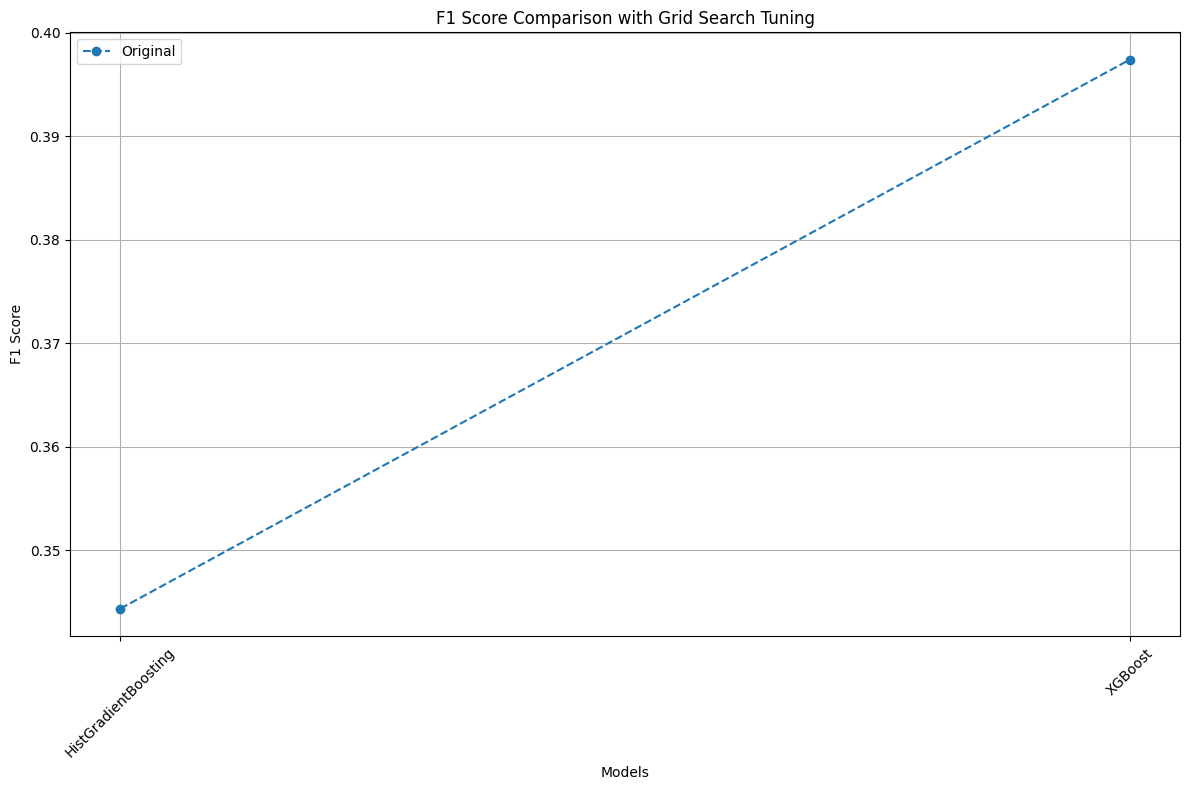

In [271]:
from sklearn.model_selection import GridSearchCV

# Update model configurations with parameter grids
model_configs = {
    'HistGradientBoosting': {
        'estimator': HistGradientBoostingClassifier(random_state=42),
        'params': {
            'learning_rate': [0.05, 0.1],
            'max_iter': [100, 200],
            'max_depth': [3, 5],
            'l2_regularization': [0, 0.1]
        }
    },
    'XGBoost': {
        'estimator': XGBClassifier(
            random_state=42,
            use_label_encoder=False,
            eval_metric='logloss'
        ),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 6],
            'learning_rate': [0.01, 0.1],
            'subsample': [0.8, 1.0]
        }
    },
    # 'LightGBM': {
    #     'estimator': LGBMClassifier(random_state=42),
    #     'params': {
    #         'n_estimators': [100, 200],
    #         'max_depth': [5, 10],
    #         'learning_rate': [0.05, 0.1],
    #         'class_weight': ['balanced', None]
    #     }
    # }
}

# Updated evaluation with grid search
results = {}

# for strategy_name in ['Original', 'SMOTE', 'Undersampled']:
for strategy_name in ['Original']:
    strategy_results = []
    from tqdm import tqdm
    for model_name, config in tqdm(model_configs.items()):
        # Skip SMOTE for NaN-handling models
        if strategy_name == 'SMOTE' and model_name in nan_models:
            continue
            
        # Select appropriate data
        if model_name in nan_models:
            if strategy_name == 'Original':
                X_tr = X_train
                y_tr = y_train
                X_te = X_test
            elif strategy_name == 'Undersampled':
                X_tr = X_train_under_orig
                y_tr = y_train_under_orig
                X_te = X_test
        else:
            if strategy_name == 'Original':
                X_tr = X_train_imputed
                y_tr = y_train
            elif strategy_name == 'SMOTE':
                X_tr = X_train_smote
                y_tr = y_train_smote
            elif strategy_name == 'Undersampled':
                X_tr = X_train_undersampled
                y_tr = y_train_undersampled
            X_te = X_test_imputed

        # Dynamic parameter adjustment for XGBoost
        if model_name == 'XGBoost':
            config['estimator'].set_params(
                scale_pos_weight=(y_tr == 0).sum() / (y_tr == 1).sum())
        
        # Setup grid search
        grid = GridSearchCV(
            estimator=config['estimator'],
            param_grid=config['params'],
            scoring='f1',
            cv=3,
            n_jobs=-1,
            verbose=0
        )
        
        # Train and evaluate
        grid.fit(X_tr, y_tr)
        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_te)
        
        strategy_results.append({
            'Model': model_name,
            'F1 Score': f1_score(y_test, y_pred),
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'Best Params': grid.best_params_
        })
    
    results[strategy_name] = pd.DataFrame(strategy_results)

# Display results with best parameters
for strategy_name, result_df in results.items():
    print(f"\n--- {strategy_name} Strategy Results with Grid Search ---")
    print(result_df.sort_values(by='F1 Score', ascending=False).to_string(index=False))

# Plotting remains the same
plt.figure(figsize=(12, 8))
for strategy_name, result_df in results.items():
    plt.plot(result_df['Model'], result_df['F1 Score'], 
            label=strategy_name, marker='o', linestyle='--')

plt.title('F1 Score Comparison with Grid Search Tuning')
plt.ylabel('F1 Score')
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
len(final_training_df)

,Sex_int,Protected category,Overall,Technical Skills,Standing/Position,Comunication,Maturity,Dynamism,Mobility,English,Italian Residence,European Residence,Age Range_int,experience_match_score,current_salary_fit_score,expected_salary_fit_score,study_title_score,professional_similarity_score,study_area_score
0,1,0,-0.466675,-0.314656,-0.498286,-0.551532,-0.522977,1.351495,1.059375,0.492727,1,0,-1.323435,-0.685377,NaN,NaN,-0.103831,0.551762,-0.117481
1,1,0,-0.466675,-0.314656,-0.498286,-0.551532,-0.522977,1.351495,1.059375,0.492727,1,0,-1.323435,-0.685377,NaN,NaN,0.602778,0.336576,1.664649
2,2,0,1.527302,0.537744,1.360345,1.277814,1.344487,1.351495,-1.565678,0.492727,1,0,-0.206720,-0.301611,-0.18637,-0.293607,-0.103831,0.788148,1.664649
3,2,0,1.527302,0.537744,1.360345,1.277814,1.344487,1.351495,-1.565678,0.492727,1,0,-0.206720,-0.301611,NaN,NaN,-0.810440,0.788148,-0.735218
4,2,0,0.862643,0.253611,0.121257,0.058250,-1.145465,-0.532881,-0.253151,0.492727,1,0,0.351637,0.082156,NaN,NaN,-0.103831,0.672097,0.340252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8903,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,-1.323435,1.617222,NaN,NaN,0.602778,-1.778886,-1.409446
8904,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,-0.206720,-1.069144,NaN,NaN,-0.103831,-0.690903,0.265640
8905,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,-0.206720,-1.069144,NaN,NaN,0.602778,-0.690903,1.106640
8906,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,-1.323435,-0.301611,NaN,NaN,1.309386,-0.161487,-0.725094


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 411, number of negative: 6715
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 502
[LightGBM] [Info] Number of data points in the train set: 7126, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 411, number of negative: 411
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 396
[LightGBM] [Info] Number of 

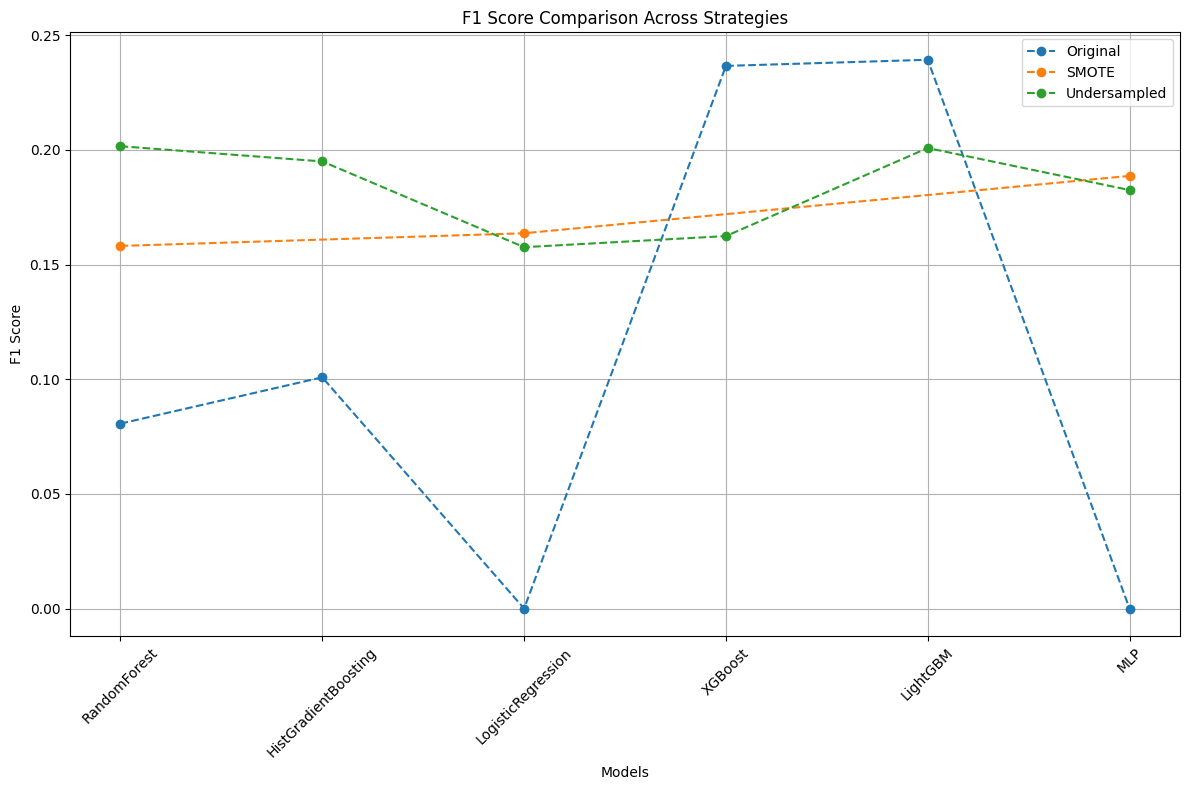

In [ ]:
# ... [Previous code steps 1-7 as provided] ...

# ----------- Step 8: Define models with their hyperparameter grids -----------
from sklearn.model_selection import GridSearchCV

model_configs = [
    {
        'name': 'RandomForest',
        'estimator': RandomForestClassifier(random_state=42),
        'param_grid': {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5],
            'class_weight': ['balanced', None]
        }
    },
    {
        'name': 'HistGradientBoosting',
        'estimator': HistGradientBoostingClassifier(random_state=42),
        'param_grid': {
            'learning_rate': [0.1, 0.05],
            'max_iter': [100, 200],
            'max_depth': [3, 5],
            'l2_regularization': [0, 0.1]
        }
    },
    # {
    #     'name': 'LogisticRegression',
    #     'estimator': LogisticRegression(max_iter=1000, random_state=42),
    #     'param_grid': {
    #         'C': [0.1, 1, 10],
    #         'penalty': ['l2', 'none'],
    #         'solver': ['lbfgs', 'saga'],
    #         'class_weight': ['balanced', None]
    #     }
    # },
    {
        'name': 'XGBoost',
        'estimator': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
        'param_grid': {
            'n_estimators': [100, 200],
            'max_depth': [3, 6],
            'learning_rate': [0.01, 0.1]
        }
    },
    # {
    #     'name': 'LightGBM',
    #     'estimator': LGBMClassifier(random_state=42),
    #     'param_grid': {
    #         'n_estimators': [100, 200],
    #         'max_depth': [5, 10],
    #         'learning_rate': [0.05, 0.1],
    #         'class_weight': ['balanced', None]
    #     }
    # },
    {
        'name': 'MLP',
        'estimator': MLPClassifier(max_iter=300, random_state=42),
        'param_grid': {
            'hidden_layer_sizes': [(100,50), (50,)],
            'activation': ['relu', 'tanh'],
            'alpha': [0.0001, 0.001],
            'learning_rate_init': [0.001, 0.01]
        }
    }
]

# ----------- Step 9: Perform Grid Search for Each Model and Sampling Strategy -----------
results = {}

for strategy_name, (X_train_strategy, y_train_strategy) in sampling_strategies.items():
    strategy_results = []
    print(strategy_name)
    for model_config in model_configs:
        
        model_name = model_config['name']
        print(f'Model: {model_name}')
        estimator = model_config['estimator']
        param_grid = model_config['param_grid']
        
        # Adjust XGBoost's scale_pos_weight based on current class distribution
        if model_name == 'XGBoost':
            scale_pos = (y_train_strategy == 0).sum() / (y_train_strategy == 1).sum()
            estimator.set_params(scale_pos_weight=scale_pos)
        
        # Setup GridSearchCV
        grid = GridSearchCV(
            estimator=estimator,
            param_grid=param_grid,
            scoring='f1',
            cv=3,
            # n_jobs=-1,
            verbose=0
        )
        grid.fit(X_train_strategy, y_train_strategy)
        
        # Evaluate best model
        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_test_imputed)
        
        # Store metrics and parameters
        print(f'Strategy {strategy_name}, Model {model_name}, F1 Score {f1_score(y_test, y_pred)}')
        strategy_results.append({
            'Model': model_name,
            'F1 Score': f1_score(y_test, y_pred),
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'Best Params': grid.best_params_
        })
    
    # Convert results to DataFrame
    results[strategy_name] = pd.DataFrame(strategy_results)

# ----------- Step 10: Display and Visualize Results -----------
for strategy_name, result_df in results.items():
    print(f"\n--- {strategy_name} Sampling Strategy Results ---")
    print(result_df.sort_values(by='F1 Score', ascending=False).to_string(index=False))

# Plot F1 Scores comparison
plt.figure(figsize=(12, 8))
for strategy_name, result_df in results.items():
    plt.plot(result_df['Model'], result_df['F1 Score'], marker='o', linestyle='--', label=strategy_name)

plt.title('Model F1 Scores Across Sampling Strategies with Hyperparameter Tuning')
plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Original
Model: RandomForest
Strategy Original, Model RandomForest, F1 Score 0.20297029702970298
Model: HistGradientBoosting
Strategy Original, Model HistGradientBoosting, F1 Score 0.10526315789473684
Model: XGBoost
Strategy Original, Model XGBoost, F1 Score 0.25609756097560976
Model: MLP
Strategy Original, Model MLP, F1 Score 0.03508771929824561
SMOTE
Model: RandomForest


KeyboardInterrupt: 

In [ ]:
!pip install --upgrade ctgan


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def evaluate_model(name, model, X_test, y_test, results_dict):
    y_pred = model.predict(X_test)
    results_dict[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1 Score': f1_score(y_test, y_pred, zero_division=0)
    }

# Reinitialize results dict
results = {}

# Models that support NaNs directly
evaluate_model('HistGradientBoosting', hgbc, X_test, y_test, results)
evaluate_model('LightGBM', lgbm, X_test, y_test, results)

# Models on imputed data
evaluate_model('RandomForest', rf, X_test_imputed, y_test, results)
evaluate_model('LogisticRegression', lr, X_test_imputed, y_test, results)
evaluate_model('XGBoost', xgb, X_test_imputed, y_test, results)
evaluate_model('MLP', mlp, X_test_scaled, y_test, results)

# Display results
result_df = pd.DataFrame(results).T.sort_values(by='F1 Score', ascending=False)
print(result_df)

                      Accuracy  Precision    Recall  F1 Score
HistGradientBoosting  0.943322   0.545455  0.116505  0.192000
LightGBM              0.942761   0.523810  0.106796  0.177419
MLP                   0.935466   0.300000  0.087379  0.135338
RandomForest          0.937710   0.318182  0.067961  0.112000
XGBoost               0.937710   0.318182  0.067961  0.112000
LogisticRegression    0.941639   0.333333  0.009709  0.018868


In [193]:
print(df['Hired'].value_counts(normalize=True))

Hired
0    0.942299
1    0.057701
Name: proportion, dtype: float64


In [ ]:
!pip install lightgbm

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 22.2 MB/s eta 0:00:0000:0100:01


In [80]:
df.columns

Index(['ID', 'Age Range', 'Residence', 'Sex', 'Protected category', 'TAG',
       'Study area', 'Study Title', 'Years Experience', 'Sector', 'Last Role',
       'Year of insertion', 'Recruitment Request', 'Assumption Headquarters',
       'Job Family Hiring', 'Job Title Hiring', 'event_type__val',
       'event_feedback', 'Overall', 'Job Description', 'Candidate Profile',
       'Years Experience.1', 'Minimum Ral', 'Ral Maximum', 'Study Level',
       'Study Area.1', 'Akkodis headquarters', 'Current Ral', 'Expected Ral',
       'Technical Skills', 'Standing/Position', 'Comunication', 'Maturity',
       'Dynamism', 'Mobility', 'English', 'Hired', 'Residence Country',
       'Residence Italian Region', 'Residence Italian Province',
       'Residence Italian City', 'Italian Residence', 'European Residence',
       'New_ID'],
      dtype='object')

In [ ]:
job_columns = [
    
               'Assumption Headquarters',
               'Recruitment Request',
               'Job Family Hiring','Job Title Hiring',# used
               'Job Description','Candidate Profile',
               'Years Experience.1', #used
               'Minimum Ral', 'Ral Maximum', #used
               'Study Level', # used
               'Study Area.1', #used
               ]

In [ ]:
intervies_columns = ['Overall','Akkodis headquarters','Technical Skills','Standing/Position','Communication',
                     'Dynamism','Mobility','English']

In [ ]:
def build_text_columns(df: pd.DataFrame) -> pd.DataFrame:
    # Utility to clean and format a single field
    def format_field(label, value):
        if pd.isna(value):
            return None
        value = str(value).strip()
        if not value or value.lower() == "not specified":
            return None
        return f"{label}: {value}"

    # Define mappings from column name to human-friendly label
    job_fields = {
        'Recruitment Request': 'Recruitment Request',
        'Job Family Hiring': 'Job Family',
        'Job Title Hiring': 'Job Title',
        'Job Description': 'Job Description',
        'Candidate Profile': 'Candidate Profile',
        'Years Experience.1': 'Required Experience',
        'Minimum Ral': 'Min Salary',
        'Ral Maximum': 'Max Salary',
        'Study Level': 'Required Study Level',
        'Study Area.1': 'Required Study Area',
    }

    candidate_fields = {
        'Protected Category': 'Protected Category',
        'TAG': 'TAG',
        'Study area': 'Study Area',
        'Study Title': 'Study Title',
        'Years Experience': 'Experience',
        'Sector': 'Sector',
        'Last Role': 'Last Role',
        'Current Ral': 'Current Salary',
        'Expected Ral': 'Expected Salary',
    }

    def combine_fields(row, fields):
        parts = [
            format_field(label, row.get(col))
            for col, label in fields.items()
        ]
        if len([p for p in parts if p])==0:
            print(parts)
        return ' | '.join([p for p in parts if p])

    # Apply the function row-wise
    df['candidate_text'] = df.apply(lambda row: combine_fields(row, candidate_fields), axis=1)
    df['job_text'] = df.apply(lambda row: combine_fields(row, job_fields), axis=1)

    return df
df_features = build_text_columns(df_features)

[None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None]
[None, None, None, None,

In [152]:
df[df['Candidate State']=='economic proposal'][[
        'Recruitment Request', 'Job Family Hiring', 'Job Title Hiring',
        'Job Description', 'Candidate Profile',
        'Years Experience.1', 'Minimum Ral', 'Ral Maximum',
        'Study Level', 'Study Area.1'
    ]].isna().sum(), len(df[df['Candidate State']=='economic proposal'])

KeyError: 'Candidate State'

In [144]:
def count_fully_missing_candidate_or_job_rows(df: pd.DataFrame) -> dict:
    # Define the column groups
    job_columns = [
        'Recruitment Request', 'Job Family Hiring', 'Job Title Hiring',
        'Job Description', 'Candidate Profile',
        'Years Experience.1', 'Minimum Ral', 'Ral Maximum',
        'Study Level', 'Study Area.1'
    ]

    candidate_columns = [
        'Protected Category', 'TAG',
        'Study area', 'Study Title', 'Years Experience',
        'Sector', 'Last Role',
        'Current Ral', 'Expected Ral'
    ]
# [Tag, Study Area, Sector, Last Role for the candidate.
# • Recruitment Request, Job Family Hiring, Job Title Hiring, Job Description,
# Candidate Profile, Study Area.1 for the job position.]
    def is_missing(value):
        if pd.isna(value):
            return True
        value = str(value).strip().lower()
        return value == "" or value == "not specified"

    def all_missing(row, columns):
        return all(is_missing(row.get(col)) for col in columns)

    candidate_missing_mask = df.apply(lambda row: all_missing(row, candidate_columns), axis=1)
    job_missing_mask = df.apply(lambda row: all_missing(row, job_columns), axis=1)

    return {
        "all_candidate_fields_missing": candidate_missing_mask.sum(),
        "all_job_fields_missing": job_missing_mask.sum(),
        "both_missing": (candidate_missing_mask & job_missing_mask).sum()
    }
count_fully_missing_candidate_or_job_rows(df_features)

{'all_candidate_fields_missing': np.int64(0),
 'all_job_fields_missing': np.int64(3943),
 'both_missing': np.int64(0)}

In [150]:
df_features[df_features['Hired']==False][[
        'Recruitment Request', 'Job Family Hiring', 'Job Title Hiring',
        'Job Description', 'Candidate Profile',
        'Years Experience.1', 'Minimum Ral', 'Ral Maximum',
        'Study Level', 'Study Area.1'
    ]].isna().sum(), len(df_features[df_features['Hired']==False])

(Recruitment Request    3940
 Job Family Hiring      3940
 Job Title Hiring       3940
 Job Description        3940
 Candidate Profile      3940
 Years Experience.1     3940
 Minimum Ral            3940
 Ral Maximum            3940
 Study Level            3940
 Study Area.1           3940
 dtype: int64,
 3940)

In [147]:
df_features['Recruitment Request'].isna().sum()
df_features['Job Family Hiring'].isna().sum()
df_features['Job Title Hiring'].isna().sum()
# , 'Job Family Hiring', 'Job Title Hiring',
#         'Job Description', 'Candidate Profile',
#         'Years Experience.1', 'Minimum Ral', 'Ral Maximum',
#         'Study Level', 'Study Area.1'

np.int64(3979)

In [ ]:
from sentence_transformers import SentenceTransformer, util
import numpy as np

# Load model once
model = SentenceTransformer('all-MiniLM-L6-v2')

def compute_general_similarity_score(df: pd.DataFrame) -> pd.Series:
    # Cache embeddings to speed up repeated values
    embedding_cache = {}

    def get_embedding(text):
        if text in embedding_cache:
            return embedding_cache[text]
        embedding = model.encode(text, convert_to_tensor=True)
        embedding_cache[text] = embedding
        return embedding

    def similarity(row):
        candidate_text = row.get('candidate_text')
        job_text = row.get('job_text')

        if not candidate_text or not job_text:
            return np.nan

        emb_a = get_embedding(candidate_text)
        emb_b = get_embedding(job_text)
        return float(util.cos_sim(emb_a, emb_b))

    return df.apply(similarity, axis=1)
df_features['general_similarity_score'] = compute_general_similarity_score(df_features)
set(df_features['general_similarity_score'])

{0.5253150463104248,
 0.5114923715591431,
 0.32039570808410645,
 0.5018234252929688,
 0.5392463207244873,
 0.5499522686004639,
 0.34827545285224915,
 0.3196186125278473,
 0.7096387147903442,
 0.6529133319854736,
 0.6040534973144531,
 0.46438440680503845,
 0.4245239496231079,
 0.47816765308380127,
 0.5890645980834961,
 0.45141610503196716,
 nan,
 0.5335781574249268,
 0.39688926935195923,
 0.31291040778160095,
 0.4922550618648529,
 0.552330493927002,
 0.4829127788543701,
 0.45692363381385803,
 0.3597533106803894,
 0.6953235864639282,
 0.4320889711380005,
 nan,
 0.4687596559524536,
 0.4337102174758911,
 0.5263005495071411,
 nan,
 nan,
 nan,
 0.47781863808631897,
 nan,
 nan,
 0.48206913471221924,
 0.4586869478225708,
 0.5093547105789185,
 0.5953418016433716,
 0.4200536012649536,
 0.5267449617385864,
 0.3809967041015625,
 0.37495744228363037,
 0.7689213752746582,
 0.5557066202163696,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.6910459995269775,
 0.4713270664215088,
 0.33680176734924316,
 0

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [140]:
# Boolean mask where candidate_text or job_text is missing or empty
mask = (
    df_features['candidate_text'].isna() | (df_features['candidate_text'].str.strip() == '') |
    df_features['job_text'].isna() | (df_features['job_text'].str.strip() == '')
)

# Count rows
count = mask.sum()
print(f"Number of rows with empty or NaN candidate_text or job_text: {count}")

# Display those rows
print(df_features[mask])


Number of rows with empty or NaN candidate_text or job_text: 3943
          ID  Age Range                      Residence     Sex  \
0        137          1     NAPLES » Naples ~ Campania  Female   
2        243          4  CARMAGNOLA » Turin ~ Piedmont    Male   
3        307          4     LEGNANO » Milan ~ Lombardy    Male   
4        315          1       TURIN » Turin ~ Piedmont    Male   
5        346          1       MILAN » Milan ~ Lombardy    Male   
...      ...        ...                            ...     ...   
4449  9139_2          7      CHIETI » Chieti ~ Abruzzo    Male   
4450   946_2          3     TREVISO » Treviso ~ Veneto    Male   
4451  9761_2          1       TURIN » Turin ~ Piedmont    Male   
4452  9912_2          3            ROME » Rome ~ Lazio    Male   
4453  9988_1          1       MILAN » Milan ~ Lombardy  Female   

      Protected category                                        TAG  \
0                  False                         PROJECT MANAGEMENT   

In [139]:
df_features['general_similarity_score'].isna().sum()

np.int64(3943)

In [ ]:
set(df_features['candidate_text'])

{'TAG: -, TRAINING | Study Area: chemical engineering | Study Title: Three-year degree | Experience: [+10] | Sector: Oil and Gas | Last Role: training coordinator',
 'Study Area: Economic - Statistics | Study Title: Five-year degree | Experience: [7-10] | Sector: Automotive | Last Role: fiat pricing manager',
 'Study Area: Management Engineering | Study Title: Five-year degree | Experience: [0] | Sector: Others | Last Role: student',
 'Study Area: Chemist - Pharmaceutical | Study Title: Five-year degree | Experience: [7-10] | Sector: Life sciences | Last Role: expert chemistry',
 'Study Area: Information Engineering | Study Title: Three-year degree | Experience: [0] | Sector: Others | Last Role: fresh graduate',
 'Study Area: electronic Engineering | Study Title: Five-year degree | Experience: [+10] | Sector: Defence | Last Role: account manager – defense and naval | Current Salary: 55000.0 | Expected Salary: 55000.0',
 'Study Area: Other | Study Title: Five-year degree | Experience: [

In [127]:
df_features.columns

Index(['ID', 'Age Range', 'Residence', 'Sex', 'Protected category', 'TAG',
       'Study area', 'Study Title', 'Years Experience', 'Sector', 'Last Role',
       'Year of insertion', 'Recruitment Request', 'Assumption Headquarters',
       'Job Family Hiring', 'Job Title Hiring', 'Overall', 'Job Description',
       'Candidate Profile', 'Years Experience.1', 'Minimum Ral', 'Ral Maximum',
       'Study Level', 'Study Area.1', 'Akkodis headquarters', 'Current Ral',
       'Expected Ral', 'Technical Skills', 'Standing/Position', 'Comunication',
       'Maturity', 'Dynamism', 'Mobility', 'English', 'Hired',
       'Residence Country', 'Residence Italian Region',
       'Residence Italian Province', 'Residence Italian City',
       'Italian Residence', 'European Residence', 'Years Experience_int',
       'Years Experience.1_int', 'study_area_score'],
      dtype='object')

In [128]:
df_features['Recruitment Request'].isna().sum(),df_features['Job Family Hiring'].isna().sum(),df_features['Job Title Hiring'].isna().sum(),df_features['Job Description'].isna().sum(),df_features['Candidate Profile'].isna().sum()

(np.int64(4021),
 np.int64(3943),
 np.int64(3979),
 np.int64(4017),
 np.int64(4023))

In [129]:
set(df_features['Recruitment Request'])

{' 1 Maintenance Leader -  (PHASE 1) - Nigeria',
 ' Document Controller',
 ' Infotainment System Engineer',
 ' Mechanical Engineer Maintenance Specialist ',
 ' Mission Operation Engineer',
 ' Scrum Master',
 ' Team Procurement - Milan',
 ' Truck Analyzer Technical Support Consulting',
 ' Wiring Harness Architecture Engineer',
 ' interns',
 '3 Software engineer – microservices design & development_senior (>5 years)',
 'Accountant',
 'Administrative employee',
 'Aeroelastic Analysis ',
 'Aerospace QA/PA activities',
 'Airworthiness Engineer',
 'Analog/digital HW design',
 'Analysis - Mechanics_Window',
 'Analysis-Mechanics_Structure',
 'Analytical chemistry',
 'Application Engineer',
 'Application System - Medical Devices',
 'Application development and maintenance',
 'Automotive Business Manager',
 'Benchmarking Automotive Engineer',
 'Braking system design -  (Catia V5) ',
 'Braking systems design -(Catia V5) 3 Resources ',
 'Business Analyst',
 'Business Manager',
 'Business Manager -

In [125]:
df_features[['Recruitment Request','Job Family Hiring','Job Title Hiring','Job Description','Candidate Profile']]

,Recruitment Request,Job Family Hiring,Job Title Hiring,Job Description,Candidate Profile
0,NaN,NaN,NaN,None,None
1,Front End Developer,Tech Consulting & Solutions,Consultant,web developer – 03/06/23 • have 2+ years of ex...,web developer – 03/06/23 • have 2+ years of ex...
2,NaN,NaN,NaN,None,None
3,NaN,NaN,NaN,None,None
4,NaN,NaN,NaN,None,None
...,...,...,...,...,...
4449,NaN,NaN,NaN,None,None
4450,NaN,NaN,NaN,None,None
4451,NaN,NaN,NaN,None,None
4452,NaN,NaN,NaN,None,None


In [ ]:
job_columns = [
               'Assumption Headquarters',
               'Recruitment Request',
               'Job Family Hiring','Job Title Hiring',# used
               'Job Description','Candidate Profile',
               'Years Experience.1', #used
               'Minimum Ral', 'Ral Maximum', #used
               'Study Level', # used
               'Study Area.1', #used
               ]

In [84]:
set(df['Assumption Headquarters'])

{'Bari',
 'Bologna',
 'Florence',
 'Gallarate',
 'Milan',
 'Modena',
 'Naples',
 'Pisa',
 'Poggibonsi',
 'Pomezia',
 'Rome',
 'The Eagle',
 'Toasts',
 'Tramutola',
 'Turin',
 'Udine',
 'Valenzano',
 'Vicenza',
 'not specified'}

In [73]:
final_df_filled.columns

Index(['ID', 'Age Range', 'Residence', 'Sex', 'Protected category', 'TAG',
       'Study area', 'Study Title', 'Years Experience', 'Sector', 'Last Role',
       'Year of insertion', 'Recruitment Request', 'Assumption Headquarters',
       'Job Family Hiring', 'Job Title Hiring', 'Overall', 'Job Description',
       'Candidate Profile', 'Years Experience.1', 'Minimum Ral', 'Ral Maximum',
       'Study Level', 'Study Area.1', 'Akkodis headquarters', 'Current Ral',
       'Expected Ral', 'Technical Skills', 'Standing/Position', 'Comunication',
       'Maturity', 'Dynamism', 'Mobility', 'English', 'Hired',
       'Residence Country', 'Residence Italian Region',
       'Residence Italian Province', 'Residence Italian City',
       'Italian Residence', 'European Residence'],
      dtype='object')

In [ ]:
def prepare_nlp_text_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Creates combined text columns for candidate profile and job requirements.

    Args:
        df: Input DataFrame. Assumes parsed experience columns exist if needed in text.

    Returns:
        DataFrame with 'candidate_text' and 'job_text' columns added.
    """
    df_processed = df.copy() # Work on a copy

    # Function to create a text summary for the candidate
    def create_candidate_text(row):
        # Combine relevant candidate features into a descriptive string
        parts = []
        # Include columns relevant to candidate's background/profile
        # Corrected 'Study area' to 'Study Area' based on user's column list
        candidate_cols = ['Study Area', 'Sector', 'Last Role']
        for col in candidate_cols:
            if pd.notna(row.get(col)): parts.append(f"{str(col).replace('_', ' ')}: {str(row[col])}")
        # Add parsed experience if it provides useful context as text
        if pd.notna(row.get('Years Experience_parsed')): parts.append(f"Experience: {row['Years Experience_parsed']} years")
        return ". ".join(parts) if parts else ""

    # Function to combine relevant job text
    def create_job_text(row):
        parts = []
         # Include columns relevant to job requirements
        job_cols = ['Job Title Hiring', 'Job Description', 'Candidate Profile', 'Study Area.1']
        for col in job_cols:
             if pd.notna(row.get(col)): parts.append(f"{str(col).replace('_', ' ')}: {str(row[col])}")
        # Add parsed required experience as text
        if pd.notna(row.get('Years Experience.1_parsed')): parts.append(f"Required Experience: {row['Years Experience.1_parsed']} years")
        return ". ".join(parts) if parts else ""

    # Create text columns, filling potential NaNs with empty strings for NLP
    df_processed['candidate_text'] = df_processed.apply(create_candidate_text, axis=1).fillna("")
    df_processed['job_text'] = df_processed.apply(create_job_text, axis=1).fillna("")

    return df_processed

In [ ]:
df_features = prepare_nlp_text_columns(df_features)


In [ ]:


# df_features = final_df.copy()
df_features = final_df_filled.copy()

# df_features = parse_and_convert_numeric_cols(df_features)



# 5. Calculate NLP Similarity (Choose one or both methods)

# Method A: Using Sentence Transformers
# Load the ST model once before calling the function
try:
    print("\n--- Loading Sentence Transformer Model ---")
    st_model = SentenceTransformer('all-MiniLM-L6-v2')
    print("--- Model Loaded ---")
    df_features['profile_nlp_similarity_st'] = calculate_nlp_similarity_st(df_features, st_model)
    print("--- ST NLP Similarity Calculation Finished ---")
except Exception as e:
    print(f"Error loading/using ST model: {e}. ST NLP similarity not calculated.")
    df_features['profile_nlp_similarity_st'] = np.nan
    st_model = None # Ensure model is None if loading failed


# Method B: Using TF-IDF
# Fit TF-IDF Vectorizer on all texts once before calling the function
try:
    print("\n--- Fitting TF-IDF Vectorizer ---")
    all_texts_for_tfidf = df_features['candidate_text'].tolist() + df_features['job_text'].tolist()
    # You can customize TfidfVectorizer parameters here (e.g., stop_words, max_features)
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    tfidf_vectorizer.fit(all_texts_for_tfidf)
    print("--- Vectorizer Fitted ---")

    df_features['profile_nlp_similarity_tfidf'] = calculate_nlp_similarity_tfidf(df_features, tfidf_vectorizer)
    print("--- TF-IDF NLP Similarity Calculation Finished ---")
except Exception as e:
     print(f"Error fitting/using TF-IDF: {e}. TF-IDF NLP similarity not calculated.")
     tfidf_vectorizer = None # Ensure vectorizer is None if fitting failed
     df_features['profile_nlp_similarity_tfidf'] = np.nan


df_features = df_features.drop(columns=['candidate_text', 'job_text'])



distance_series, proximity_series = calculate_geo_features(df_features)
df_features['residence_hq_distance_km'] = distance_series
df_features['residence_hq_proximity_score'] = proximity_series

nlp_score_col_for_overall = None
if 'profile_nlp_similarity_st' in df_features.columns and not df_features['profile_nlp_similarity_st'].isnull().all():
    nlp_score_col_for_overall = 'profile_nlp_similarity_st'
elif 'profile_nlp_similarity_tfidf' in df_features.columns and not df_features['profile_nlp_similarity_tfidf'].isnull().all():
     nlp_score_col_for_overall = 'profile_nlp_similarity_tfidf'

score_columns_for_overall = [
    'experience_match_score',
    'salary_fit_score',
    'residence_hq_proximity_score',
    'Overall_scaled' # Note: 'Overall_scaled' is created within calculate_overall_score if 'Overall' exists
]
if nlp_score_col_for_overall:
    score_columns_for_overall.append(nlp_score_col_for_overall)

df_features['overall_match_score'] = calculate_overall_score(df_features, score_columns_for_overall)


df_features['Hired'] = (df_features['Hired'] == True)
print("\n'Hired' column cleaned and added.")


# --- 8. Drop Source/Intermediate Columns ---
# Define the list of final columns you want to keep
columns_to_keep_final = [
    '# TAG', # Identifier
    # 'Italian Residence', 'European Residence', # Booleans
    # 'Overall', 
    'Technical Skills', 'Standing/Position', # Original Scores
    'Comunication', 'Maturity', 'Dynamism', 'Mobility', 'English', # Original Scores
    'Current Ral', 'Expected Ral', 'Minimum Ral', 'Ral Maximum', # Original RALs (now numeric/NaN)
    'Years Experience_parsed', 'Years Experience.1_parsed', # Parsed Years Experience
    'experience_match_score', 'salary_fit_score', # New Scores
    'profile_nlp_similarity_st', 
    # 'profile_nlp_similarity_tfidf', # Both NLP Scores (keep both or choose one)
    # 'residence_hq_distance_km', 'residence_hq_proximity_score', # New Geo Scores
    # 'overall_match_score', # New Combined Score
    'Hired' # Target variable
]

df_features_cleaned = drop_columns_except(df_features, columns_to_keep_final)

feature_columns_for_ml = [col for col in df_features_cleaned.columns if col != 'Hired']

X = df_features_cleaned[feature_columns_for_ml]
y = df_features_cleaned['Hired']
for c in X.columns:
    print(c,X[c].isna().sum())
# from imblearn.over_sampling import SMOTE
# print(f'Before resampling:{len(X)}')

# smote = SMOTE(random_state=42)
# X, y = smote.fit_resample(X, y)
# print(f'After resampling:{len(X)}')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y) # Stratify to maintain hire ratio
# index_cut=int(0.65 * len(X))
# X_train, X_test = X[:index_cut], X[index_cut:]
# y_train, y_test = y[:index_cut], y[index_cut:]

from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
# model = HistGradientBoostingClassifier(random_state=42)

# Train the model - pass X_train directly (it may contain NaNs)
print("\n--- Training HistGradientBoostingClassifier Model ---")
model.fit(X_train, y_train)
print("--- Model Training Complete ---")


# --- Make Predictions and Evaluate ---
# Predict - pass X_test directly (it may contain NaNs)
y_pred = model.predict(X_test)

print("\n--- Model Evaluation ---")
print("Accuracy:", accuracy_score(y_test, y_pred))

# Calculate F1 Score specifically
f1 = f1_score(y_test, y_pred)
print("F1 Score (for True/Hired class):", f1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# --- Final Output ---
print("\n--- Processed DataFrame (first 5 rows) ---")
print(df_features_cleaned.head())
print("\n--- Info on Processed DataFrame ---")
df_features_cleaned.info()
print("\n--- Columns in Processed DataFrame ---")
print(df_features_cleaned.columns.tolist())


--- Loading Sentence Transformer Model ---
--- Model Loaded ---
--- ST NLP Similarity Calculation Finished ---

--- Fitting TF-IDF Vectorizer ---
--- Vectorizer Fitted ---
--- TF-IDF NLP Similarity Calculation Finished ---
Attempting to geocode HQ location: 'Via dei Fornari 12, Bologna, Italy'
Error: Could not geocode HQ location 'Via dei Fornari 12, Bologna, Italy'. Cannot calculate geographical features.

'Hired' column cleaned and added.
Minimum Ral 0
Ral Maximum 0
Current Ral 0
Expected Ral 0
Technical Skills 0
Standing/Position 0
Comunication 0
Maturity 0
Dynamism 0
Mobility 0
English 0
profile_nlp_similarity_st 0

--- Training HistGradientBoostingClassifier Model ---
--- Model Training Complete ---

--- Model Evaluation ---
Accuracy: 0.8857142857142857
F1 Score (for True/Hired class): 0.14285714285714285

Classification Report:
              precision    recall  f1-score   support

       False       0.89      0.99      0.94      1300
        True       0.54      0.08      0.14 

In [37]:
for x in final_df_filled.columns:
    print(x,final_df_filled[x].isna().sum())

ID 0
Age Range 0
Residence 0
Sex 0
Protected category 0
TAG 0
Study area 0
Study Title 0
Years Experience 0
Sector 0
Last Role 0
Year of insertion 0
Recruitment Request 0
Assumption Headquarters 0
Job Family Hiring 0
Job Title Hiring 0
Overall 0
Job Description 0
Candidate Profile 0
Years Experience.1 0
Minimum Ral 0
Ral Maximum 0
Study Level 0
Study Area.1 0
Akkodis headquarters 0
Current Ral 0
Expected Ral 0
Technical Skills 0
Standing/Position 0
Comunication 0
Maturity 0
Dynamism 0
Mobility 0
English 0
Hired 0
Residence Country 0
Residence Italian Region 0
Residence Italian Province 0
Residence Italian City 0
Italian Residence 0
European Residence 0


In [ ]:
import pandas as pd

# Combine X_train and y_train for correlation
df_corr = X_train.copy()
df_corr['Hired'] = y_train.astype(int)  # convert boolean to 0/1 for correlation

# Compute correlation between each feature and the target
correlations = df_corr.corr(numeric_only=True)['Hired'].drop('Hired').sort_values(ascending=False)

print("\n--- Correlation with 'Hired' ---")
print(correlations)



--- Correlation with 'Hired' ---
Dynamism                     0.197748
Maturity                     0.192602
Comunication                 0.159901
Standing/Position            0.153866
profile_nlp_similarity_st    0.153021
Technical Skills             0.144088
English                      0.121371
Mobility                     0.116028
Ral Maximum                 -0.023143
Current Ral                 -0.044847
Minimum Ral                 -0.046342
Expected Ral                -0.088067
Name: Hired, dtype: float64


In [39]:
(y_test==True).sum(),len(y_test)

(np.int64(170), 1470)

In [40]:
(y_train==True).sum(),len(y_train)

(np.int64(344), 2984)

In [41]:
X_train

,Minimum Ral,Ral Maximum,Current Ral,Expected Ral,Technical Skills,Standing/Position,Comunication,Maturity,Dynamism,Mobility,English,profile_nlp_similarity_st
2991,25931.575246,31503.870968,29000.000000,31000.000000,3.000000,2.000000,3.000000,2.000000,2.000000,1.000000,3.00000,0.326990
953,25931.575246,31503.870968,33430.340557,35493.913043,1.000000,2.000000,2.000000,2.000000,1.000000,1.000000,2.00000,0.275514
1404,25931.575246,31503.870968,33430.340557,35493.913043,2.000000,2.333333,2.666667,2.666667,2.333333,2.000000,3.00000,0.246105
3155,25931.575246,31503.870968,27000.000000,31000.000000,2.184571,2.268093,2.301491,2.280047,2.282789,2.192873,2.74095,0.142680
3219,25931.575246,31503.870968,33430.340557,35493.913043,2.184571,2.268093,2.301491,2.280047,2.282789,2.192873,2.74095,0.308217
...,...,...,...,...,...,...,...,...,...,...,...,...
509,25931.575246,31503.870968,45000.000000,47000.000000,3.333333,2.666667,2.666667,3.333333,2.666667,1.000000,2.00000,0.371244
2557,25931.575246,31503.870968,37000.000000,45000.000000,2.184571,2.268093,2.301491,2.280047,2.282789,2.192873,2.74095,0.292371
2143,25931.575246,31503.870968,33430.340557,35493.913043,2.184571,2.268093,2.301491,2.280047,2.282789,2.192873,2.74095,0.358341
77,25931.575246,31503.870968,33430.340557,35493.913043,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.00000,0.316332


In [ ]:


# --- Create a copy of the DataFrame for processing ---
df_features = final_df.copy()

def parse_experience_string(exp_str):
    if pd.isna(exp_str):
        return np.nan
    if not isinstance(exp_str, str):
         # If it's already a number (e.g., int/float not converted to str yet), return it
         return float(exp_str)

    exp_str = exp_str.strip()
    if not exp_str:
        return np.nan

    # Handle combined formats like '[3-5] | [1-3]'
    parts = exp_str.split('|')
    values = []

    for part in parts:
        part = part.strip().replace('[', '').replace(']', '') # Remove brackets
        if not part: continue

        try:
            if '-' in part:
                if part.startswith('+'): # Handle '+10' case explicitly if it appears as '+10'
                     value = float(part.replace('+', '')) # Treat +10 as 10
                else:
                    low, high = map(float, part.split('-'))
                    value = (low + high) / 2.0 # Midpoint of range
            elif part.startswith('+'): # Handle '+10' when it's just '+10' after stripping []
                 value = float(part.replace('+', '')) # Treat +10 as 10
            else:
                value = float(part) # Handle single numbers like '0', '5', '10'

            values.append(value)
        except ValueError:
            # print(f"Warning: Could not parse experience string part '{part}' from '{exp_str}'")
            continue # Ignore parts that cannot be parsed

    if values:
        # For multiple ranges/values separated by '|', take the maximum experience
        return max(values)
    else:
        return np.nan # Return NaN if no parts could be parsed

# Apply custom parsing to experience columns
df_features['Years Experience_parsed'] = df_features['Years Experience'].apply(parse_experience_string)
df_features['Years Experience.1_parsed'] = df_features['Years Experience.1'].apply(parse_experience_string)

# Convert RAL columns and Overall to numeric, coercing errors
ral_overall_cols = ['Current Ral', 'Expected Ral', 'Minimum Ral', 'Ral Maximum', 'Overall']
for col in ral_overall_cols:
     # Simple conversion. If 'k' format exists, this will turn it to NaN.
     # A more complex parser would be needed for 'k'. Sticking to simple numeric/NaN for now.
     df_features[col] = pd.to_numeric(df_features[col], errors='coerce')


print("\n--- DataFrame after parsing and converting numeric columns (first 5 rows) ---")
print(df_features[['Years Experience', 'Years Experience_parsed', 'Years Experience.1', 'Years Experience.1_parsed', 'Current Ral', 'Expected Ral', 'Minimum Ral', 'Ral Maximum']].head())
print("\n--- DataFrame Info after parsing and converting numeric columns ---")
df_features[['Years Experience_parsed', 'Years Experience.1_parsed'] + ral_overall_cols].info()


# --- 2. Feature: Experience Match Score ---
# Simple inverse of difference, scaled. Smaller difference = higher score.
# Now use the parsed numeric columns
def calculate_experience_match(candidate_exp_parsed, job_req_exp_parsed):
    # pd.isna handles both np.nan and None
    if pd.isna(candidate_exp_parsed) or pd.isna(job_req_exp_parsed):
        return np.nan
    diff = abs(candidate_exp_parsed - job_req_exp_parsed)
    # Score decreases as difference increases, never 0 unless diff is infinite
    return 1 / (diff + 1)

df_features['experience_match_score'] = df_features.apply(
    lambda row: calculate_experience_match(row['Years Experience_parsed'], row['Years Experience.1_parsed']),
    axis=1
)


# --- 3. Feature: Salary Fit Score ---
# Score based on whether expected RAL is within the min/max range.
# Using the converted RAL columns
def calculate_salary_fit(expected_ral, min_ral, max_ral):
    # pd.isna handles both np.nan and None
    if pd.isna(expected_ral) or pd.isna(min_ral) or pd.isna(max_ral):
        return np.nan

    if min_ral > max_ral: # Handle illogical ranges
         return np.nan

    if expected_ral >= min_ral and expected_ral <= max_ral:
        return 1.0 # Perfect fit

    # If outside the range, score decreases with distance from the range
    if expected_ral < min_ral:
        distance = min_ral - expected_ral
    else: # expected_ral > max_ral
        distance = expected_ral - max_ral

    # Scale the distance (adjust denominator based on expected RAL scale)
    # Using the range size + min_ral as a scaling factor
    range_size = max_ral - min_ral
    scale_factor = range_size if range_size > 0 else min_ral # Avoid zero/negative division

    # If min_ral is also 0 or negative, use a default scale factor
    if scale_factor <= 0: scale_factor = 1000 # Default scale if range/min is non-positive

    # Simple scaled inverse distance for scores > 0
    score = 1 / (distance / scale_factor + 1)

    return score

df_features['salary_fit_score'] = df_features.apply(
    lambda row: calculate_salary_fit(row['Expected Ral'], row['Minimum Ral'], row['Ral Maximum']),
    axis=1
)


# --- 4. Feature: Profile NLP Similarity ---
# Using Sentence Transformers to embed candidate summary and job profile text.

# Choose a pre-trained model
model_name = 'all-MiniLM-L6-v2' # A good balance of speed and performance
try:
    model = SentenceTransformer(model_name)
    nlp_model_loaded = True
except Exception as e:
    print(f"Error loading SentenceTransformer model {model_name}: {e}")
    print("Profile NLP similarity will be set to NaN.")
    nlp_model_loaded = False
    model = None # Set model to None if loading fails


if nlp_model_loaded:
    # Function to create a text summary for the candidate
    def create_candidate_text(row):
        # Combine relevant candidate features into a descriptive string
        parts = []
        # Include columns relevant to candidate's background/profile
        candidate_cols = ['Study area', 'Sector', 'Last Role'] # Add other relevant columns if needed
        for col in candidate_cols:
            if pd.notna(row[col]): parts.append(f"{col.replace('_', ' ')}: {row[col]}")
        # Add parsed experience if it provides useful context as text
        if pd.notna(row['Years Experience_parsed']): parts.append(f"Experience: {row['Years Experience_parsed']} years")
        return ". ".join(parts) if parts else ""

    # Function to combine relevant job text
    def create_job_text(row):
        parts = []
         # Include columns relevant to job requirements
        job_cols = ['Job Title Hiring', 'Job Description', 'Candidate Profile', 'Study Area.1'] # Add other relevant columns
        for col in job_cols:
             if pd.notna(row[col]): parts.append(f"{col.replace('_', ' ')}: {row[col]}")
        # Add parsed required experience as text
        if pd.notna(row['Years Experience.1_parsed']): parts.append(f"Required Experience: {row['Years Experience.1_parsed']} years")
        return ". ".join(parts) if parts else ""


    # Create text columns on the features dataframe
    df_features['candidate_text'] = df_features.apply(create_candidate_text, axis=1)
    df_features['job_text'] = df_features.apply(create_job_text, axis=1)

    # Generate embeddings (handle empty strings or NaNs in text columns)
    candidate_texts = df_features['candidate_text'].tolist()
    job_texts = df_features['job_text'].tolist()

    try:
        # Process only non-empty strings for embeddings
        # Map original index to the index in the filtered list
        valid_candidate_indices = [i for i, txt in enumerate(candidate_texts) if txt]
        valid_job_indices = [i for i, txt in enumerate(job_texts) if txt]

        valid_candidate_texts_filtered = [candidate_texts[i] for i in valid_candidate_indices]
        valid_job_texts_filtered = [job_texts[i] for i in valid_job_indices]


        if valid_candidate_texts_filtered and valid_job_texts_filtered:
            # Ensure model is loaded before encoding
            if model is None:
                 raise ValueError("NLP model is not loaded.")

            candidate_embeddings = model.encode(valid_candidate_texts_filtered, show_progress_bar=False)
            job_embeddings = model.encode(valid_job_texts_filtered, show_progress_bar=False)

            # Calculate cosine similarity and map back to the original index
            similarity_scores = [np.nan] * len(df_features) # Initialize with NaN or 0
            
            # Create mappings from filtered index back to original index
            candidate_idx_map = {i_filtered: i_orig for i_filtered, i_orig in enumerate(valid_candidate_indices)}
            job_idx_map = {i_filtered: i_orig for i_filtered, i_orig in enumerate(valid_job_indices)}

            # Calculate similarity only for rows where both texts were valid
            # Find original indices that are in both valid lists
            common_indices = list(set(valid_candidate_indices) & set(valid_job_indices))
            
            # Create mappings from original index to filtered index for common indices
            original_to_filtered_cand = {i_orig: i_filtered for i_filtered, i_orig in enumerate(valid_candidate_indices)}
            original_to_filtered_job = {i_filtered: i_orig for i_filtered, i_orig in enumerate(valid_job_indices)}
             # Need a map for job filtered index too, if the lists aren't the same length
            original_to_filtered_job = {i_orig: i_filtered for i_filtered, i_orig in enumerate(valid_job_indices)}


            for i_orig in common_indices:
                 i_filtered_cand = original_to_filtered_cand[i_orig]
                 i_filtered_job = original_to_filtered_job[i_orig] # Corrected mapping here

                 cand_emb = candidate_embeddings[i_filtered_cand].reshape(1, -1)
                 job_emb = job_embeddings[i_filtered_job].reshape(1, -1)
                 score = cosine_similarity(cand_emb, job_emb)[0][0]
                 similarity_scores[i_orig] = score # Assign score to the original index

            # Fill NaN for rows where one or both texts were empty
            for i in range(len(df_features)):
                 if i not in common_indices:
                      # Decide default score for missing text - 0 or NaN
                      similarity_scores[i] = 0.0 # Assuming 0 similarity if text is missing


            df_features['profile_nlp_similarity'] = similarity_scores

        else:
            # If no valid text pairs at all, set all scores to 0 or NaN
            df_features['profile_nlp_similarity'] = 0.0 # Or np.nan

    except Exception as e:
        print(f"Error during embedding or similarity calculation: {e}")
        df_features['profile_nlp_similarity'] = np.nan # Set to NaN if NLP fails

    # Drop temporary text columns
    df_features = df_features.drop(columns=['candidate_text', 'job_text'])

else:
    df_features['profile_nlp_similarity'] = np.nan # Set to NaN if model loading failed


# --- 5. Feature: Geographical Distance ---
# Requires a geocoding service (Nominatim is free but has rate limits and usage policies)
# Define the HQ location (example: a specific address in Bologna)
hq_location_str = "Via dei Fornari 12, Bologna, Italy"
geolocator = Nominatim(user_agent="geopy_distance_calculator_v4") # Add a unique user agent

# Dictionary to cache geocoding results to avoid redundant calls
geocoding_cache = {}

def get_coordinates_cached(location_str):
    if pd.isna(location_str) or location_str.strip() == "":
        return None
    if location_str in geocoding_cache:
        return geocoding_cache[location_str]

    try:
        # Use try-except for geocoding failures and rate limiting
        # Increased timeout for robustness
        location = geolocator.geocode(location_str, timeout=10)
        if location:
            coords = (location.latitude, location.longitude)
            geocoding_cache[location_str] = coords
             # Add a small delay to respect Nominatim rate limits *only on success*
            time.sleep(1.1) # Slightly more than 1 second
            return coords
        else:
            geocoding_cache[location_str] = None # Cache failure
            time.sleep(0.5) # Shorter wait on failure but still wait
            return None
    except Exception as e:
        # print(f"Geocoding failed for '{location_str}': {e}") # Keep this commented unless debugging geocoding
        geocoding_cache[location_str] = None # Cache failure
        time.sleep(1.1) # Still wait to avoid hitting the service too hard on errors
        return None

# Get HQ coordinates once
hq_coords = get_coordinates_cached(hq_location_str)
# print(f"\nHQ Coordinates for '{hq_location_str}': {hq_coords}") # Commented for cleaner output

def calculate_distance_to_hq(row, hq_coords):
    if hq_coords is None:
        return np.nan # Cannot calculate if HQ coords are unknown

    # Prefer city, then province/region, then country for geocoding
    location_parts = []
    # Order matters for geocoding accuracy, start from most specific
    if pd.notna(row['Residence Italian City']) and str(row['Residence Italian City']).strip():
        location_parts.append(str(row['Residence Italian City']).strip())
    if pd.notna(row['Residence Italian Province']) and str(row['Residence Italian Province']).strip():
        location_parts.append(f"{str(row['Residence Italian Province']).strip()} Province") # Add ' Province' for clarity
    if pd.notna(row['Residence Italian Region']) and str(row['Residence Italian Region']).strip():
         location_parts.append(f"{str(row['Residence Italian Region']).strip()} Region") # Add ' Region' for clarity
    if pd.notna(row['Residence Country']) and str(row['Residence Country']).strip():
        location_parts.append(str(row['Residence Country']).strip())

    # If it's an Italian residence, prioritize Italian structure before adding country
    if row.get('Italian Residence', False) and len(location_parts) > 1:
         # Reorder to City, Province, Region, Country if Italian
         italian_parts = []
         city = [p for p in location_parts if 'City' not in p and 'Province' not in p and 'Region' not in p and 'Country' not in p] # Simple city name
         province = [p for p in location_parts if 'Province' in p]
         region = [p for p in location_parts if 'Region' in p]
         country = [p for p in location_parts if 'Country' in p] # Country might be 'Italy'

         if city: italian_parts.extend(city)
         if province: italian_parts.extend(province)
         if region: italian_parts.extend(region)
         if country: italian_parts.extend(country)
         # Fallback if reordering fails or is empty
         candidate_location_str = ", ".join(italian_parts) if italian_parts else ", ".join(location_parts)

    else:
         # For non-Italian or incomplete Italian addresses, just join in order
         candidate_location_str = ", ".join(location_parts)


    if not candidate_location_str:
        return np.nan # No location info for candidate

    candidate_coords = get_coordinates_cached(candidate_location_str)

    if candidate_coords:
        try:
            # Calculate geodesic distance in kilometers
            distance_km = geodesic(candidate_coords, hq_coords).km
            return distance_km
        except Exception as e:
            # print(f"Distance calculation failed for coords {candidate_coords} and {hq_coords}: {e}") # Debugging distance
            return np.nan
    else:
        return np.nan # Could not geocode candidate location

# Apply distance calculation row by row
# This can be slow due to geocoding API calls and delays
# Consider parallelizing or using a faster geocoding service for large datasets
print("\n--- Calculating geographical distances... This may take some time depending on the number of rows and API rate limits. ---")
df_features['residence_hq_distance_km'] = df_features.apply(
    lambda row: calculate_distance_to_hq(row, hq_coords),
    axis=1
)
print("--- Geographical distance calculation finished. ---")


# Create a proximity score from distance
df_features['residence_hq_proximity_score'] = df_features['residence_hq_distance_km'].apply(
    lambda x: 1 / (x + 1) if pd.notna(x) and x >= 0 else (1.0 if pd.notna(x) and x < 0 else np.nan) # Inverse distance score (handle potential negative distance though unlikely)
)


# --- 6. Feature: Overall Match Score ---
# Combine relevant scores. This is a simple example, weighting can be adjusted.

# Select scores to combine
# Include the new features and potentially scaled existing performance scores
score_columns_for_overall = [
    'experience_match_score',
    'salary_fit_score',
    'profile_nlp_similarity',
    'residence_hq_proximity_score'
]

# Scale 'Overall' performance score to 0-1 range if needed (assuming max is 5)
# Ensure 'Overall' is numeric before scaling (done earlier in cleaning)
df_features['Overall_scaled'] = df_features['Overall'] / 5.0
score_columns_for_overall.append('Overall_scaled')

# Simple average, ignoring NaNs
df_features['overall_match_score'] = df_features[score_columns_for_overall].mean(axis=1)


# --- 7. Drop Original Columns Used for Feature Creation ---
# Define the list of original columns that were used to derive the new features
# Drop the original string/object columns and the intermediate parsed/scaled columns
columns_to_drop_refined = [
    'Study area', 'Sector', 'Last Role', # Used for candidate text
    'Years Experience', # Original string column
    'Current Ral', 'Expected Ral', 'Minimum Ral', 'Ral Maximum', # Original RAL columns (if parsed later)
    'Job Title Hiring', 'Job Description', 'Candidate Profile', 'Study Area.1', # Used for job text
    'Years Experience.1', # Original string column
    'Residence Country', 'Residence Italian Region',
    'Residence Italian Province', 'Residence Italian City', 'Akkodis headquarters', # Used for geocoding
    'Overall_scaled', # Intermediate scaled column
    'Years Experience_parsed', 'Years Experience.1_parsed' # Intermediate parsed numeric columns (keep if needed)
]

# Decide which original/intermediate columns to KEEP
columns_to_keep = [
    '# TAG', 'Italian Residence', 'European Residence',
    'Overall', 'Technical Skills', 'Standing/Position',
    'Comunication', 'Maturity', 'Dynamism', 'Mobility', 'English',
    'experience_match_score', 'salary_fit_score', 'profile_nlp_similarity',
    'residence_hq_distance_km', 'residence_hq_proximity_score', 'overall_match_score', 'Hired'
    # Optionally, keep the parsed numeric experience/RALs if useful
    # 'Years Experience_parsed', 'Years Experience.1_parsed',
    # 'Current Ral', 'Expected Ral', 'Minimum Ral', 'Ral Maximum'
]

# Get the list of columns to drop by finding columns in df_features that are NOT in columns_to_keep
all_df_features_cols = set(df_features.columns)
columns_to_drop_actual = list(all_df_features_cols - set(columns_to_keep))


# Ensure columns exist before trying to drop them
columns_to_drop_actual = [col for col in columns_to_drop_actual if col in df_features.columns]

df_features = df_features.drop(columns=columns_to_drop_actual)


# --- Final Output ---
print("\n--- Original DataFrame remains unchanged ---")
print(df.head())
print("\n--- Original DataFrame Info (should be same as before conversion) ---")
df.info()


print("\n--- Processed DataFrame with New Float Features (first 5 rows) ---")
# Display the processed dataframe - should have new columns and fewer old ones
print(df_features.head())

print("\n--- Info on Processed DataFrame ---")
df_features.info()

# Optional: Display the columns in the processed DataFrame
print("\n--- Columns in Processed DataFrame ---")
print(df_features.columns.tolist())
 



--- DataFrame after parsing and converting numeric columns (first 5 rows) ---
  Years Experience  Years Experience_parsed Years Experience.1  \
0              [0]                      0.0                NaN   
1            [1-3]                      2.0              [1-3]   
2            [3-5]                      4.0                NaN   
3           [7-10]                      8.5                NaN   
4              [0]                      0.0                NaN   

   Years Experience.1_parsed  Current Ral  Expected Ral  Minimum Ral  \
0                        NaN          NaN           NaN          NaN   
1                        2.0      23000.0       27000.0      23000.0   
2                        NaN      41000.0       45000.0          NaN   
3                        NaN          NaN           NaN          NaN   
4                        NaN          NaN           NaN          NaN   

   Ral Maximum  
0          NaN  
1      29000.0  
2          NaN  
3          NaN  
4     

In [ ]:
import numpy as np
# Import TF-IDF Vectorizer and cosine_similarity from sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from geopy.geocoders import Nominatim
from geopy.distance import geodesic
import time # To handle geocoding rate limits
import warnings # To manage potential warnings
import re # Import regex for parsing strings


df_features = final_df.copy()

# --- Data Cleaning: Convert specific columns to numeric ---

# Custom parsing function for experience strings like '[0-1]', '[+10]', '[3-5] | [1-3]'
def parse_experience_string(exp_str):
    if pd.isna(exp_str):
        return np.nan
    if not isinstance(exp_str, str):
         # If it's already a number (e.g., int/float not converted to str yet), return it
         return float(exp_str)

    exp_str = exp_str.strip()
    if not exp_str:
        return np.nan

    # Handle combined formats like '[3-5] | [1-3]'
    parts = exp_str.split('|')
    values = []

    for part in parts:
        part = part.strip().replace('[', '').replace(']', '') # Remove brackets
        if not part: continue

        try:
            if '-' in part:
                if part.startswith('+'): # Handle '+10' case explicitly if it appears as '+10'
                     value = float(part.replace('+', '')) # Treat +10 as 10
                else:
                    low, high = map(float, part.split('-'))
                    value = (low + high) / 2.0 # Midpoint of range
            elif part.startswith('+'): # Handle '+10' when it's just '+10' after stripping []
                 value = float(part.replace('+', '')) # Treat +10 as 10
            else:
                value = float(part) # Handle single numbers like '0', '5', '10'

            values.append(value)
        except ValueError:
            # print(f"Warning: Could not parse experience string part '{part}' from '{exp_str}'")
            continue # Ignore parts that cannot be parsed

    if values:
        # For multiple ranges/values separated by '|', take the maximum experience
        return max(values)
    else:
        return np.nan # Return NaN if no parts could be parsed

# Apply custom parsing to experience columns
df_features['Years Experience_parsed'] = df_features['Years Experience'].apply(parse_experience_string)
df_features['Years Experience.1_parsed'] = df_features['Years Experience.1'].apply(parse_experience_string)

# Convert RAL columns and Overall to numeric, coercing errors
ral_overall_cols = ['Current Ral', 'Expected Ral', 'Minimum Ral', 'Ral Maximum', 'Overall']
for col in ral_overall_cols:
     # Simple conversion. If 'k' format exists, this will turn it to NaN.
     # A more complex parser would be needed for 'k'. Sticking to simple numeric/NaN for now.
     df_features[col] = pd.to_numeric(df_features[col], errors='coerce')


print("\n--- DataFrame after parsing and converting numeric columns (first 5 rows) ---")
print(df_features[['Years Experience', 'Years Experience_parsed', 'Years Experience.1', 'Years Experience.1_parsed', 'Current Ral', 'Expected Ral', 'Minimum Ral', 'Ral Maximum']].head())
print("\n--- DataFrame Info after parsing and converting numeric columns ---")
df_features[['Years Experience_parsed', 'Years Experience.1_parsed'] + ral_overall_cols].info()


# --- 2. Feature: Experience Match Score ---
# Simple inverse of difference, scaled. Smaller difference = higher score.
# Now use the parsed numeric columns
def calculate_experience_match(candidate_exp_parsed, job_req_exp_parsed):
    # pd.isna handles both np.nan and None
    if pd.isna(candidate_exp_parsed) or pd.isna(job_req_exp_parsed):
        return np.nan
    diff = abs(candidate_exp_parsed - job_req_exp_parsed)
    # Score decreases as difference increases, never 0 unless diff is infinite
    return 1 / (diff + 1)

df_features['experience_match_score'] = df_features.apply(
    lambda row: calculate_experience_match(row['Years Experience_parsed'], row['Years Experience.1_parsed']),
    axis=1
)


# --- 3. Feature: Salary Fit Score ---
# Score based on whether expected RAL is within the min/max range.
# Using the converted RAL columns
def calculate_salary_fit(expected_ral, min_ral, max_ral):
    # pd.isna handles both np.nan and None
    if pd.isna(expected_ral) or pd.isna(min_ral) or pd.isna(max_ral):
        return np.nan

    if min_ral > max_ral: # Handle illogical ranges
         return np.nan

    if expected_ral >= min_ral and expected_ral <= max_ral:
        return 1.0 # Perfect fit

    # If outside the range, score decreases with distance from the range
    if expected_ral < min_ral:
        distance = min_ral - expected_ral
    else: # expected_ral > max_ral
        distance = expected_ral - max_ral

    # Scale the distance (adjust denominator based on expected RAL scale)
    # Using the range size + min_ral as a scaling factor
    range_size = max_ral - min_ral
    scale_factor = range_size if range_size > 0 else min_ral # Avoid zero/negative division

    # If min_ral is also 0 or negative, use a default scale factor
    if scale_factor <= 0: scale_factor = 1000 # Default scale if range/min is non-positive

    # Simple scaled inverse distance for scores > 0
    score = 1 / (distance / scale_factor + 1)

    return score

df_features['salary_fit_score'] = df_features.apply(
    lambda row: calculate_salary_fit(row['Expected Ral'], row['Minimum Ral'], row['Ral Maximum']),
    axis=1
)


# --- 4. Feature: Profile NLP Similarity (using TF-IDF) ---

# Function to create a text summary for the candidate (same as before)
def create_candidate_text(row):
    # Combine relevant candidate features into a descriptive string
    parts = []
    # Include columns relevant to candidate's background/profile
    candidate_cols = ['Study area', 'Sector', 'Last Role'] # Corrected 'Study area' to 'Study Area'
    for col in candidate_cols:
        if pd.notna(row[col]): parts.append(f"{col.replace('_', ' ')}: {row[col]}")
    # Add parsed experience if it provides useful context as text
    if pd.notna(row['Years Experience_parsed']): parts.append(f"Experience: {row['Years Experience_parsed']} years")
    return ". ".join(parts) if parts else ""

# Function to combine relevant job text (same as before)
def create_job_text(row):
    parts = []
     # Include columns relevant to job requirements
    job_cols = ['Job Title Hiring', 'Job Description', 'Candidate Profile', 'Study Area.1'] # Add other relevant columns
    for col in job_cols:
         if pd.notna(row[col]): parts.append(f"{col.replace('_', ' ')}: {row[col]}")
    # Add parsed required experience as text
    if pd.notna(row['Years Experience.1_parsed']): parts.append(f"Required Experience: {row['Years Experience.1_parsed']} years")
    return ". ".join(parts) if parts else ""

# Create text columns on the features dataframe
df_features['candidate_text'] = df_features.apply(create_candidate_text, axis=1).fillna("") # Fill NaN text with empty string
df_features['job_text'] = df_features.apply(create_job_text, axis=1).fillna("") # Fill NaN text with empty string

# Combine all texts to build the TF-IDF vocabulary
all_texts = df_features['candidate_text'].tolist() + df_features['job_text'].tolist()

# Initialize TF-IDF Vectorizer
# You can add parameters like stop_words='english', ngram_range=(1, 2), max_features=...
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000) # Limit features to 1000 for demonstration

# Fit the vectorizer on all texts to build the vocabulary and IDF
tfidf_vectorizer.fit(all_texts)

# Transform candidate and job texts into TF-IDF vectors
candidate_tfidf = tfidf_vectorizer.transform(df_features['candidate_text'])
job_tfidf = tfidf_vectorizer.transform(df_features['job_text'])

# Calculate cosine similarity between candidate and job vectors
# cosine_similarity returns a matrix where element (i, j) is similarity between vector i and vector j.
# We want the similarity between vector i (candidate i) and vector i (job i).
# This is the diagonal of the similarity matrix, or simply the dot product if vectors are L2-normalized (which TfidfVectorizer does).
# Using pairwise.cosine_similarity is straightforward:
similarity_matrix = cosine_similarity(candidate_tfidf, job_tfidf)

# The similarity score for each pair (candidate_i, job_i) is on the diagonal
profile_nlp_similarity_scores = similarity_matrix.diagonal()

df_features['profile_nlp_similarity'] = profile_nlp_similarity_scores

# Drop temporary text columns
df_features = df_features.drop(columns=['candidate_text', 'job_text'])


# --- 5. Feature: Geographical Distance (Same as before) ---
# Requires a geocoding service (Nominatim is free but has rate limits and usage policies)
# Define the HQ location (example: a specific address in Bologna)
hq_location_str = "Via dei Fornari 12, Bologna, Italy"
geolocator = Nominatim(user_agent="geopy_distance_calculator_v5") # Add a unique user agent

# Dictionary to cache geocoding results to avoid redundant calls
geocoding_cache = {}

def get_coordinates_cached(location_str):
    if pd.isna(location_str) or location_str.strip() == "":
        return None
    if location_str in geocoding_cache:
        return geocoding_cache[location_str]

    try:
        # Use try-except for geocoding failures and rate limiting
        # Increased timeout for robustness
        location = geolocator.geocode(location_str, timeout=10)
        if location:
            coords = (location.latitude, location.longitude)
            geocoding_cache[location_str] = coords
             # Add a small delay to respect Nominatim rate limits *only on success*
            time.sleep(1.1) # Slightly more than 1 second
            return coords
        else:
            geocoding_cache[location_str] = None # Cache failure
            time.sleep(0.5) # Shorter wait on failure but still wait
            return None
    except Exception as e:
        # print(f"Geocoding failed for '{location_str}': {e}") # Keep this commented unless debugging geocoding
        geocoding_cache[location_str] = None # Cache failure
        time.sleep(1.1) # Still wait to avoid hitting the service too hard on errors
        return None

# Get HQ coordinates once
hq_coords = get_coordinates_cached(hq_location_str)
# print(f"\nHQ Coordinates for '{hq_location_str}': {hq_coords}") # Commented for cleaner output

def calculate_distance_to_hq(row, hq_coords):
    if hq_coords is None:
        return np.nan # Cannot calculate if HQ coords are unknown

    # Prefer city, then province/region, then country for geocoding
    location_parts = []
    # Order matters for geocoding accuracy, start from most specific
    if pd.notna(row['Residence Italian City']) and str(row['Residence Italian City']).strip():
        location_parts.append(str(row['Residence Italian City']).strip())
    if pd.notna(row['Residence Italian Province']) and str(row['Residence Italian Province']).strip():
        location_parts.append(f"{str(row['Residence Italian Province']).strip()} Province") # Add ' Province' for clarity
    if pd.notna(row['Residence Italian Region']) and str(row['Residence Italian Region']).strip():
         location_parts.append(f"{str(row['Residence Italian Region']).strip()} Region") # Add ' Region' for clarity
    if pd.notna(row['Residence Country']) and str(row['Residence Country']).strip():
        location_parts.append(str(row['Residence Country']).strip())

    # If it's an Italian residence, prioritize Italian structure before adding country
    if row.get('Italian Residence', False) and len(location_parts) > 1:
         # Reorder to City, Province, Region, Country if Italian
         italian_parts = []
         city = [p for p in location_parts if 'City' not in p and 'Province' not in p and 'Region' not in p and 'Country' not in p] # Simple city name
         province = [p for p in location_parts if 'Province' in p]
         region = [p for p in location_parts if 'Region' in p]
         country = [p for p in location_parts if 'Country' in p] # Country might be 'Italy'

         if city: italian_parts.extend(city)
         if province: italian_parts.extend(province)
         if region: italian_parts.extend(region)
         if country: italian_parts.extend(country)
         # Fallback if reordering fails or is empty
         candidate_location_str = ", ".join(italian_parts) if italian_parts else ", ".join(location_parts)

    else:
         # For non-Italian or incomplete Italian addresses, just join in order
         candidate_location_str = ", ".join(location_parts)


    if not candidate_location_str:
        return np.nan # No location info for candidate

    candidate_coords = get_coordinates_cached(candidate_location_str)

    if candidate_coords:
        try:
            # Calculate geodesic distance in kilometers
            distance_km = geodesic(candidate_coords, hq_coords).km
            return distance_km
        except Exception as e:
            # print(f"Distance calculation failed for coords {candidate_coords} and {hq_coords}: {e}") # Debugging distance
            return np.nan
    else:
        return np.nan # Could not geocode candidate location

# Apply distance calculation row by row
# This can be slow due to geocoding API calls and delays
# Consider parallelizing or using a faster geocoding service for large datasets
print("\n--- Calculating geographical distances... This may take some time depending on the number of rows and API rate limits. ---")
df_features['residence_hq_distance_km'] = df_features.apply(
    lambda row: calculate_distance_to_hq(row, hq_coords),
    axis=1
)
print("--- Geographical distance calculation finished. ---")


# Create a proximity score from distance
df_features['residence_hq_proximity_score'] = df_features['residence_hq_distance_km'].apply(
    lambda x: 1 / (x + 1) if pd.notna(x) and x >= 0 else (1.0 if pd.notna(x) and x < 0 else np.nan) # Inverse distance score (handle potential negative distance though unlikely)
)


# --- 6. Feature: Overall Match Score ---
# Combine relevant scores. This is a simple example, weighting can be adjusted.

# Select scores to combine
# Include the new features and potentially scaled existing performance scores
score_columns_for_overall = [
    'experience_match_score',
    'salary_fit_score',
    'profile_nlp_similarity',
    'residence_hq_proximity_score'
]

# Scale 'Overall' performance score to 0-1 range if needed (assuming max is 5)
# Ensure 'Overall' is numeric before scaling (done earlier in cleaning)
df_features['Overall_scaled'] = df_features['Overall'] / 5.0
score_columns_for_overall.append('Overall_scaled')

# Simple average, ignoring NaNs
df_features['overall_match_score'] = df_features[score_columns_for_overall].mean(axis=1)


# --- 7. Drop Original Columns Used for Feature Creation ---
# Define the list of original columns that were used to derive the new features
# Drop the original string/object columns and the intermediate parsed/scaled columns
# Keeping original numeric-like columns after conversion for potential use as features
columns_to_drop_refined = [
    'Study Area', 'Sector', 'Last Role', # Used for candidate text
    'Years Experience', # Original string column
    # 'Current Ral', 'Expected Ral', 'Minimum Ral', 'Ral Maximum', # Keeping these after conversion
    'Job Title Hiring', 'Job Description', 'Candidate Profile', 'Study Area.1', # Used for job text
    'Years Experience.1', # Original string column
    'Residence Country', 'Residence Italian Region',
    'Residence Italian Province', 'Residence Italian City', 'Akkodis headquarters', # Used for geocoding
    'Overall_scaled', # Intermediate scaled column
    'Years Experience_parsed', 'Years Experience.1_parsed' # Intermediate parsed numeric columns (keeping original numeric-like ones instead)
]

# Decide which original/intermediate columns to KEEP
# Explicitly list the columns that should remain in the final df_features
columns_to_keep = [
    '# TAG', 'Italian Residence', 'European Residence', # Identifiers/Booleans
    'Overall', 'Technical Skills', 'Standing/Position', # Original Scores
    'Comunication', 'Maturity', 'Dynamism', 'Mobility', 'English', # Original Scores
    'Current Ral', 'Expected Ral', 'Minimum Ral', 'Ral Maximum', # Original RALs (now numeric/NaN)
    'Years Experience_parsed', 'Years Experience.1_parsed', # Keeping parsed years experience
    'experience_match_score', 'salary_fit_score', # New Scores
    'profile_nlp_similarity', # New NLP Score
    'residence_hq_distance_km', 'residence_hq_proximity_score', # New Geo Scores
    'overall_match_score' # New Combined Score
    # Need to add 'Hired' back in if you want it in the final features df before ML
    # For training, we separate X and y, so it doesn't *have* to be in df_features permanently
]


df_features['Hired_cleaned'] = (df_features['Hired'] == True)
df_features['Hired'] = df_features['Hired_cleaned']
df_features = df_features.drop(columns=['Hired_cleaned'])
print("\n'Hired' column cleaned and added to df_features.")


# Add 'Hired' to the list of columns to keep
columns_to_keep.append('Hired')


# Get the list of columns to drop by finding columns in df_features that are NOT in columns_to_keep
all_df_features_cols = set(df_features.columns)
columns_to_drop_actual = list(all_df_features_cols - set(columns_to_keep))

# Ensure columns exist before trying to drop them
columns_to_drop_actual = [col for col in columns_to_drop_actual if col in df_features.columns]

# Drop the columns
df_features = df_features.drop(columns=columns_to_drop_actual)



--- DataFrame after parsing and converting numeric columns (first 5 rows) ---
  Years Experience  Years Experience_parsed Years Experience.1  \
0              [0]                      0.0                NaN   
1            [1-3]                      2.0              [1-3]   
2            [3-5]                      4.0                NaN   
3           [7-10]                      8.5                NaN   
4              [0]                      0.0                NaN   

   Years Experience.1_parsed  Current Ral  Expected Ral  Minimum Ral  \
0                        NaN          NaN           NaN          NaN   
1                        2.0      23000.0       27000.0      23000.0   
2                        NaN      41000.0       45000.0          NaN   
3                        NaN          NaN           NaN          NaN   
4                        NaN          NaN           NaN          NaN   

   Ral Maximum  
0          NaN  
1      29000.0  
2          NaN  
3          NaN  
4     

In [ ]:
final_df.isna().mean() * 100

ID                             0.000000
Age Range                      0.000000
Residence                      0.000000
Sex                            0.000000
Protected category             0.000000
TAG                           50.898069
Study area                     0.000000
Study Title                    0.000000
Years Experience               0.000000
Sector                         1.167490
Last Role                      1.481814
Year of insertion              0.000000
Recruitment Request           90.278401
Assumption Headquarters       88.527167
Job Family Hiring             88.527167
Job Title Hiring              89.335429
Overall                       53.794342
Job Description               90.188595
Candidate Profile             90.323305
Years Experience.1            90.166143
Minimum Ral                   94.678940
Ral Maximum                   93.039964
Study Level                   90.166143
Study Area.1                  90.166143
Akkodis headquarters          90.166143


In [45]:
df_features.isna().mean() * 100

Overall                          53.794342
Minimum Ral                      94.678940
Ral Maximum                      93.039964
Current Ral                      85.496183
Expected Ral                     87.090256
Technical Skills                 53.906601
Standing/Position                53.906601
Comunication                     53.906601
Maturity                         53.906601
Dynamism                         53.929053
Mobility                         53.906601
English                          53.973956
Hired                             0.000000
Italian Residence                 0.000000
European Residence                0.000000
Years Experience_parsed           0.000000
Years Experience.1_parsed        90.166143
experience_match_score           90.166143
salary_fit_score                 98.158958
profile_nlp_similarity            0.000000
residence_hq_distance_km        100.000000
residence_hq_proximity_score    100.000000
overall_match_score               0.000000
dtype: floa

In [ ]:
df

,ID,Age Range,Residence,Sex,Protected category,TAG,Study area,Study Title,Years Experience,Sector,Last Role,Year of insertion,Recruitment Request,Assumption Headquarters,Job Family Hiring,Job Title Hiring,event_type__val,event_feedback,Overall,Job Description,Candidate Profile,Years Experience.1,Minimum Ral,Ral Maximum,Study Level,Study Area.1,Akkodis headquarters,Current Ral,Expected Ral,Technical Skills,Standing/Position,Comunication,Maturity,Dynamism,Mobility,English,Hired,Residence Country,Residence Italian Region,Residence Italian Province,Residence Italian City,Italian Residence,European Residence
0,41,31 - 35 years,PERCH DOSIMO » Cremona ~ Lombardy,Male,False,NaN,industrial engineering,Five-year degree,[1-3],Others,business analyst consultant,[2021],NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Italy,Lombardy,Cremona,Perch Dosimo,True,False
1,47,36 - 40 years,GERMANY » (STATE) ~ (OVERSEAS),Male,False,NaN,Electrical Engineering,Five-year degree,[+10],Energy,et solutions ag,[2022],NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Germany,None,None,None,False,False
2,84,26 - 30 years,BOLOGNA » Bologna ~ Emilia Romagna,Male,False,NaN,Civil/Civil and Environmental Engineering,Five-year degree,[0-1],Others,civil engineer - internship at studio,[2022],NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Italy,Emilia romagna,Bologna,Bologna,True,False
3,134,40 - 45 years,AVEZZANO » L'Aquila ~ Abruzzo,Male,False,NaN,Communication Sciences,Three-year degree,[+10],Services and Information Systems,freelance visual designer,[2021],NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Italy,Abruzzo,L'aquila,Avezzano,True,False
4,137,< 20 years,NAPLES » Naples ~ Campania,Female,False,PROJECT MANAGEMENT,Management Engineering,Five-year degree,[0],Others,project manager,[2023],NaN,NaN,NaN,NaN,research association,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Italy,Campania,Naples,Naples,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8034,9912_2,26 - 30 years,ROME » Rome ~ Lazio,Male,False,PYTHON,computer engineering,Five-year degree,[0],Others,fresh graduate,[2023],NaN,NaN,NaN,NaN,contact note,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Italy,Lazio,Rome,Rome,True,False
8035,9967_3,26 - 30 years,TURIN » Turin ~ Piedmont,Male,False,.,Energy and Nuclear Engineering,Three-year degree,[0],Energy,electrical system designer,[2022],NaN,NaN,NaN,NaN,research association,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Italy,Piedmont,Turin,Turin,True,False
8036,9967_3,26 - 30 years,TURIN » Turin ~ Piedmont,Male,False,.,Energy and Nuclear Engineering,Three-year degree,[0],Energy,electrical system designer,[2022],NaN,NaN,NaN,NaN,contact note,NaN,2.0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,1.0,2.0,2.0,3.0,1.0,False,Italy,Piedmont,Turin,Turin,True,False
8037,9967_3,26 - 30 years,TURIN » Turin ~ Piedmont,Male,False,.,Energy and Nuclear Engineering,Three-year degree,[0],Energy,electrical system designer,[2022],NaN,NaN,NaN,NaN,technical interview,KO (language skills),1.0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,2.0,3.0,1.0,False,Italy,Piedmont,Turin,Turin,True,False


In [47]:
df_features['Hired'] = (df_features['Hired'] == True)


In [ ]:
df_features

,Overall,Minimum Ral,Ral Maximum,Current Ral,Expected Ral,Technical Skills,Standing/Position,Comunication,Maturity,Dynamism,Mobility,English,Hired,Italian Residence,European Residence,Years Experience_parsed,Years Experience.1_parsed,experience_match_score,salary_fit_score,profile_nlp_similarity,residence_hq_distance_km,residence_hq_proximity_score,overall_match_score
0,2.000000,NaN,NaN,NaN,NaN,2.000000,2.000000,2.000000,2.000000,3.0,3.000000,3.0,False,True,False,0.0,NaN,NaN,NaN,0.000000,NaN,NaN,0.200000
1,3.000000,23000.0,29000.0,23000.0,27000.0,2.500000,3.000000,3.000000,3.000000,3.0,1.000000,3.0,True,True,False,2.0,2.0,1.0,1.0,0.138264,NaN,NaN,0.684566
2,2.666667,NaN,NaN,41000.0,45000.0,2.333333,2.333333,2.333333,1.666667,2.0,2.000000,3.0,False,True,False,4.0,NaN,NaN,NaN,0.000000,NaN,NaN,0.266667
3,3.000000,NaN,NaN,NaN,NaN,3.000000,2.666667,3.000000,3.000000,3.0,2.666667,3.0,False,True,False,8.5,NaN,NaN,NaN,0.000000,NaN,NaN,0.300000
4,2.000000,NaN,NaN,NaN,NaN,1.500000,2.000000,2.500000,2.000000,2.0,3.000000,2.5,False,True,False,0.0,NaN,NaN,NaN,0.000000,NaN,NaN,0.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4449,NaN,NaN,NaN,45000.0,49000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,False,10.0,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000
4450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,False,0.0,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000
4451,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,False,10.0,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000
4452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,False,0.0,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000


In [49]:
feature_columns = [
    'experience_match_score',
    'salary_fit_score',
    'profile_nlp_similarity',
    'residence_hq_distance_km', # Keep distance or proximity score, not both usually
    # 'residence_hq_proximity_score', # Using distance, drop proximity
    'overall_match_score',
    'Overall', # Keep the original score
    'Technical Skills', 'Standing/Position', 'Comunication',
    'Maturity', 'Dynamism', 'Mobility', 'English',
    'Italian Residence', 'European Residence' # Include boolean features
    # Include parsed RALs/Experience if they weren't dropped and you want them as features
    # 'Years Experience_parsed', 'Years Experience.1_parsed',
    # 'Current Ral', 'Expected Ral', 'Minimum Ral', 'Ral Maximum'
]
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report
# Ensure all selected feature columns exist in the DataFrame
feature_columns = [col for col in feature_columns if col in df_features.columns]

X = df_features[feature_columns]
y = df_features['Hired']

# Handle missing values in features (X)
# Use SimpleImputer to replace NaNs (e.g., with the mean of the column)
# It's important to fit the imputer ONLY on the training data to avoid data leakage
imputer = SimpleImputer(strategy='mean') # Or 'median', 'constant'

# --- Split Data into Training and Testing Sets ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y) # Stratify to maintain hire ratio

# Fit the imputer on the training data and transform both training and test data
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test) # Use the *same* imputer fitted on training data

# --- Train a Simple ML Model (Logistic Regression) ---
model = LogisticRegression(random_state=42)

# Train the model
print("\n--- Training Logistic Regression Model ---")
model.fit(X_train_imputed, y_train)
print("--- Model Training Complete ---")

# --- Make Predictions and Evaluate (Optional but good practice) ---
y_pred = model.predict(X_test_imputed)

print("\n--- Model Evaluation ---")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



--- Training Logistic Regression Model ---
--- Model Training Complete ---

--- Model Evaluation ---
Accuracy: 0.9614003590664273

Classification Report:
              precision    recall  f1-score   support

       False       0.96      1.00      0.98       985
        True       0.98      0.68      0.80       129

    accuracy                           0.96      1114
   macro avg       0.97      0.84      0.89      1114
weighted avg       0.96      0.96      0.96      1114



In [50]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Ensure all selected feature columns exist in the DataFrame
feature_columns = [col for col in feature_columns if col in df_features.columns]

X = df_features[feature_columns]
y = df_features['Hired']

# Handle missing values in features (X)
# Use SimpleImputer to replace NaNs (e.g., with the mean of the column)
# It's important to fit the imputer ONLY on the training data to avoid data leakage
imputer = SimpleImputer(strategy='mean')  # You can also use 'median' or 'most_frequent'

# --- Split Data into Training and Testing Sets ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y) # Stratify to maintain hire ratio

# Fit the imputer on the training data and transform both training and test data
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)  # Use the *same* imputer fitted on training data

# --- Train a Better ML Model (Random Forest or Gradient Boosting) ---

# Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=5, min_samples_split=5)
print("\n--- Training Random Forest Classifier ---")
rf_model.fit(X_train_imputed, y_train)
print("--- Random Forest Training Complete ---")

# Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)
print("\n--- Training Gradient Boosting Classifier ---")
gb_model.fit(X_train_imputed, y_train)
print("--- Gradient Boosting Training Complete ---")

# --- Make Predictions and Evaluate ---
# Predict with Random Forest
rf_y_pred = rf_model.predict(X_test_imputed)
print("\n--- Random Forest Model Evaluation ---")
rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_f1 = f1_score(y_test, rf_y_pred, average='binary')
print(f"Random Forest Accuracy: {rf_accuracy}")
print(f"Random Forest F1-Score: {rf_f1}")
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, rf_y_pred))

# Predict with Gradient Boosting
gb_y_pred = gb_model.predict(X_test_imputed)
print("\n--- Gradient Boosting Model Evaluation ---")
gb_accuracy = accuracy_score(y_test, gb_y_pred)
gb_f1 = f1_score(y_test, gb_y_pred, average='binary')
print(f"Gradient Boosting Accuracy: {gb_accuracy}")
print(f"Gradient Boosting F1-Score: {gb_f1}")
print("\nGradient Boosting Classification Report:")
print(classification_report(y_test, gb_y_pred))



--- Training Random Forest Classifier ---
--- Random Forest Training Complete ---

--- Training Gradient Boosting Classifier ---
--- Gradient Boosting Training Complete ---

--- Random Forest Model Evaluation ---
Random Forest Accuracy: 0.9838420107719928
Random Forest F1-Score: 0.925

Random Forest Classification Report:
              precision    recall  f1-score   support

       False       0.98      1.00      0.99       985
        True       1.00      0.86      0.93       129

    accuracy                           0.98      1114
   macro avg       0.99      0.93      0.96      1114
weighted avg       0.98      0.98      0.98      1114


--- Gradient Boosting Model Evaluation ---
Gradient Boosting Accuracy: 0.9820466786355476
Gradient Boosting F1-Score: 0.9180327868852459

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

       False       0.98      1.00      0.99       985
        True       0.97      0.87      0.92       129

    

In [51]:
len(X_test), len(X_train)

(1114, 3340)

In [52]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# Import HistGradientBoostingClassifier instead of LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
# No need to import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, f1_score

feature_columns = [col for col in feature_columns if col in df_features.columns]

X = df_features[feature_columns]
y = df_features['Hired']

# --- Split Data into Training and Testing Sets (Same as before) ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# *** IMPORTANT: We skip the imputation step here ***
# The algorithm will handle the NaNs directly


# --- Train a Simple ML Model (HistGradientBoostingClassifier) ---
# This model can handle NaN values in the input features X
model = HistGradientBoostingClassifier(random_state=42)

# Train the model - pass X_train directly (it may contain NaNs)
print("\n--- Training HistGradientBoostingClassifier Model ---")
model.fit(X_train, y_train)
print("--- Model Training Complete ---")

# --- Make Predictions and Evaluate ---
# Predict - pass X_test directly (it may contain NaNs)
y_pred = model.predict(X_test)

print("\n--- Model Evaluation ---")
print("Accuracy:", accuracy_score(y_test, y_pred))

# Calculate F1 Score specifically
f1 = f1_score(y_test, y_pred)
print("F1 Score (for True/Hired class):", f1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


--- Training HistGradientBoostingClassifier Model ---
--- Model Training Complete ---

--- Model Evaluation ---
Accuracy: 0.9829443447037702
F1 Score (for True/Hired class): 0.9230769230769231

Classification Report:
              precision    recall  f1-score   support

       False       0.98      1.00      0.99       985
        True       0.97      0.88      0.92       129

    accuracy                           0.98      1114
   macro avg       0.98      0.94      0.96      1114
weighted avg       0.98      0.98      0.98      1114



In [53]:
X_train

,experience_match_score,salary_fit_score,profile_nlp_similarity,residence_hq_distance_km,overall_match_score,Overall,Technical Skills,Standing/Position,Comunication,Maturity,Dynamism,Mobility,English,Italian Residence,European Residence
1179,NaN,NaN,0.00000,NaN,0.250000,2.5,2.500000,2.500000,2.0,2.5,2.5,1.000000,2.0,True,False
4123,NaN,NaN,0.00000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False
1143,NaN,NaN,0.00000,NaN,0.200000,2.0,1.666667,1.666667,2.0,2.0,2.0,2.333333,3.0,True,False
3109,NaN,NaN,0.00000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False
3668,NaN,NaN,0.00000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727,NaN,NaN,0.00000,NaN,0.200000,2.0,1.000000,2.000000,1.5,1.5,1.5,2.500000,2.5,True,False
2557,NaN,NaN,0.00000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False
2143,NaN,NaN,0.00000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False
77,NaN,NaN,0.00000,NaN,0.200000,2.0,2.000000,2.000000,2.0,2.0,2.0,2.000000,2.0,True,False


In [54]:
set(final_df['Standing/Position'])
# TAG, Study Area, Sector, Last Role,  Years Experience, Current Ral, Expected Ral
# 'Job Title Hiring',  'Job Description', 'Candidate Profile', 'Years Experience.1', 'Minimum Ral', 'Ral Maximum', 'Study Level', 'Study Area.1',
# 'Residence Country', 'Residence Italian Region', 'Residence Italian Province', 'Residence Italian City', 'Italian Residence', 'European Residence'
# 'Akkodis headquarters'
# 'Overall', 'Technical Skills', 'Standing/Position', 'Comunication', 'Maturity', 'Dynamism', 'Mobility', 'English',

{1.5,
 2.75,
 2.0,
 3.0,
 2.5,
 1.0,
 2.25,
 1.75,
 1.25,
 3.5,
 3.25,
 4.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,

In [55]:
set(final_df['Recruitment Request'])

{' 1 Maintenance Leader -  (PHASE 1) - Nigeria',
 ' Document Controller',
 ' Infotainment System Engineer',
 ' Mechanical Engineer Maintenance Specialist ',
 ' Mission Operation Engineer',
 ' Scrum Master',
 ' Team Procurement - Milan',
 ' Truck Analyzer Technical Support Consulting',
 ' Wiring Harness Architecture Engineer',
 ' interns',
 '3 Software engineer – microservices design & development_senior (>5 years)',
 'Accountant',
 'Administrative employee',
 'Aeroelastic Analysis ',
 'Aerospace QA/PA activities',
 'Airworthiness Engineer',
 'Analog/digital HW design',
 'Analysis - Mechanics_Window',
 'Analysis-Mechanics_Structure',
 'Analytical chemistry',
 'Application Engineer',
 'Application System - Medical Devices',
 'Application development and maintenance',
 'Automotive Business Manager',
 'Benchmarking Automotive Engineer',
 'Braking system design -  (Catia V5) ',
 'Braking systems design -(Catia V5) 3 Resources ',
 'Business Analyst',
 'Business Manager',
 'Business Manager -

In [56]:
set(final_df['Candidate Profile'])

{'(coming soon)',
 "(profiles with experience in sales are also suitable, even those coming from the supplier's purchasing office, it is important that they have experience in the industrial or oil and gas sector) excellent english required",
 '.',
 '1 coordinator 1 senior buyer 1 junior buyer',
 '1) many years of experience in design, development and testing of c++ software in a linux and windows environment 2) experience in object-oriented design methodologies and with mdb (modeling design based) technology 3) experience in processing xml formats 4) significant experience in sw development: a . on postgresql-type relational dbs b. qt framework/qml c. ms visual studio (2010 onwards) d. boost library e. ffmpeg environment f. many years of experience in developing applications based on esriarcgis using the c++ and qt sdks 5) knowledge of configuration control (git) and problem report handling (bugzilla/redmine)',
 '10 years of experience in the oil & gas sector with at least 5 years of 

### o

In [57]:
df.columns

Index(['ID', 'Age Range', 'Residence', 'Sex', 'Protected category', 'TAG',
       'Study area', 'Study Title', 'Years Experience', 'Sector', 'Last Role',
       'Year of insertion', 'Recruitment Request', 'Assumption Headquarters',
       'Job Family Hiring', 'Job Title Hiring', 'event_type__val',
       'event_feedback', 'Overall', 'Job Description', 'Candidate Profile',
       'Years Experience.1', 'Minimum Ral', 'Ral Maximum', 'Study Level',
       'Study Area.1', 'Akkodis headquarters', 'Current Ral', 'Expected Ral',
       'Technical Skills', 'Standing/Position', 'Comunication', 'Maturity',
       'Dynamism', 'Mobility', 'English', 'Hired', 'Residence Country',
       'Residence Italian Region', 'Residence Italian Province',
       'Residence Italian City', 'Italian Residence', 'European Residence'],
      dtype='object')

In [58]:
set(df['Last Role'])

{'',
 'project procurement specialist',
 'quest global engineering',
 'inspector & expediter',
 'business and technical manager',
 'marketing and communications intern',
 'logistics engineer',
 'business manager/ life sciences',
 'firmware design',
 'senior project controller',
 'planning engineer',
 'talent acquisition & employer branding specialist',
 'management member',
 'tutoring',
 'advanced consultant',
 'mechatronic manager',
 'post order coordinator',
 'analyst programmer/full stack developer',
 'project engineer and mechanical designer',
 'python java programming',
 'research fellow',
 'auxiliary in charge of transporting patients within the hospital',
 'cleaner',
 'doctorate in information technology',
 'cloud migration & implementation team lead',
 'materials management',
 'corse powertrain division',
 'verification of technical procedures, testing and acceptance',
 'freelancer as graphic artist/art director',
 'process shift supervisor',
 'java web backend developer',
 'de

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder
from difflib import get_close_matches

## 1. Missing Value Replacement ###
df.fillna('not specified', inplace=True)

### 2. Format numeric fields ###
num_cols = ['Current Ral', 'Expected Ral']
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')


### 5. Standardize Last Role ###
# Dummy role mapping (can be extended)
role_mapping = {
    'software dev': 'Software Developer',
    'developer': 'Software Developer',
    'data scientist': 'Data Scientist',
}
df['Last Role'] = df['Last Role'].str.lower().replace(role_mapping)

### 6. Handle Duplicates by ID ###
# Detect conflicting duplicate IDs
grouped = df.groupby('ID')
new_ids = {}
for name, group in grouped:
    if group['Sex'].nunique() > 1:
        for idx, row in group.iterrows():
            new_ids[idx] = f"{row['ID']}_{row['Year of insertion']}"
    else:
        for idx, row in group.iterrows():
            new_ids[idx] = row['ID']

df['New_ID'] = df.index.map(new_ids)

### 7. Sorting Categorical Variables ###
# Define custom sort orders
cat_order = {
    'Candidate State': ['Imported', 'First contact', 'In selection', 'QM', 'Vivier', 'Economic proposal', 'Hired'],
    'Age Range': ['< 20', '20 - 25', '26 - 30', '31 - 35', '36 - 40', '40 - 45', '> 45'],
    'Years Experience': ['not specified', '[0]', '[0-1]', '[1-3]', '[3-5]', '[5-7]', '[7-10]', '[+10]']
}

for col, order in cat_order.items():
    df[col] = pd.Categorical(df[col], categories=order, ordered=True)

df.sort_values(by=['Candidate State', 'Age Range', 'Years Experience'], inplace=True)

### 8. Filtering Candidates ###
# Remove early stage or ambiguous candidates
invalid_states = ['imported', 'first contact']
df = df[~df['Candidate State'].isin(invalid_states)]

# Filter based on event feedback
invalid_feedback = [
    'OK (other candidate)', 'KO (lost availability)', 'OK (hired)',
    'OK (waiting for departure)', 'KO (opportunity closed)', 'KO (retired)',
    'KO (ral)', 'KO (proposed renunciation)'
]
df = df[~df['event_feedback'].isin(invalid_feedback)]

# ### 9. Collapse Events: Aggregate Interview Scores ###
# score_cols = ['Technical Skills', 'Standing/Position', 'Comunication', 'Dynamism', 'Mobility', 'English']
# df_scores = df.groupby('New_ID')[score_cols].mean().reset_index()
# df_final = df.drop_duplicates('New_ID').merge(df_scores, on='New_ID', suffixes=('', '_avg'))

# ### 10. Final Dataset: Binary Labels (Hired = 1) ###
# df_final['Hired'] = (df_final['Candidate State'] == 'hired').astype(int)
df

KeyError: 'Candidate State'

In [89]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder
from difflib import get_close_matches

# Load raw dataset
df = pd.read_csv('candidates_raw.csv')

### 1. Missing Value Replacement ###
df.fillna('not specified', inplace=True)

### 2. Format numeric fields ###
num_cols = ['Current Ral', 'Expected Ral']
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

### 3. Protected Category → Binary ###
df['Protected Category'] = df['Protected Category'].apply(lambda x: 'yes' if 'article' in str(x).lower() else 'no')

### 4. Normalize Residence ###
def parse_residence(residence):
    # Simulate a geocoding parser: dummy extract country, region, city from string
    parts = residence.split(',')
    country = parts[-1].strip() if len(parts) > 1 else 'not specified'
    city = parts[0].strip() if parts else 'not specified'
    return pd.Series([country, city])

df[['Residence Country', 'Residence City']] = df['Residence'].apply(parse_residence)

# Binary flags
df['Italian Residence'] = df['Residence Country'].apply(lambda x: 1 if x.lower() == 'italy' else 0)
df['European Residence'] = df['Residence Country'].apply(lambda x: 1 if x.lower() in ['italy', 'france', 'germany'] else 0)

### 5. Standardize Last Role ###
# Dummy role mapping (can be extended)
role_mapping = {
    'software dev': 'Software Developer',
    'developer': 'Software Developer',
    'data scientist': 'Data Scientist',
}
df['Last Role'] = df['Last Role'].str.lower().replace(role_mapping)

### 6. Handle Duplicates by ID ###
# Detect conflicting duplicate IDs
grouped = df.groupby('ID')
new_ids = {}
for name, group in grouped:
    if group['Sex'].nunique() > 1:
        for idx, row in group.iterrows():
            new_ids[idx] = f"{row['ID']}_{row['Year of Insertion']}"
    else:
        for idx in group.index:
            new_ids[idx] = row['ID']

df['New_ID'] = df.index.map(new_ids)

### 7. Sorting Categorical Variables ###
# Define custom sort orders
cat_order = {
    'Candidate State': ['imported', 'first contact', 'in selection', 'qm', 'vivier', 'economic proposal', 'hired'],
    'Age Range': ['< 20', '20 - 25', '26 - 30', '31 - 35', '36 - 40', '40 - 45', '> 45'],
    'Years Experience': ['not specified', '[0]', '[0-1]', '[1-3]', '[3-5]', '[5-7]', '[7-10]', '[+10]']
}
for col, order in cat_order.items():
    df[col] = pd.Categorical(df[col], categories=order, ordered=True)

df.sort_values(by=['Candidate State', 'Age Range', 'Years Experience'], inplace=True)

### 8. Filtering Candidates ###
# Remove early stage or ambiguous candidates
invalid_states = ['imported', 'first contact']
df = df[~df['Candidate State'].isin(invalid_states)]

# Filter based on event feedback
invalid_feedback = [
    'OK (other candidate)', 'KO (lost availability)', 'OK (hired)',
    'OK (waiting for departure)', 'KO (opportunity closed)', 'KO (retired)',
    'KO (ral)', 'KO (proposed renunciation)'
]
df = df[~df['Event_Feedback'].isin(invalid_feedback)]

### 9. Collapse Events: Aggregate Interview Scores ###
score_cols = ['Technical Skills', 'Standing/Position', 'Communication', 'Dynamism', 'Mobility', 'English']
df_scores = df.groupby('New_ID')[score_cols].mean().reset_index()
df_final = df.drop_duplicates('New_ID').merge(df_scores, on='New_ID', suffixes=('', '_avg'))

### 10. Final Dataset: Binary Labels (Hired = 1) ###
df_final['Hired'] = (df_final['Candidate State'] == 'hired').astype(int)

### 11. Output Final Dataset ###
df_final.to_csv('processed_candidates.csv', index=False)


FileNotFoundError: [Errno 2] No such file or directory: 'candidates_raw.csv'